<div style="border:1px solid #cfe0d7;
            border-radius:12px;
            padding:0.8em 1em;
            background:#eaf3ef;
            margin:1em 0;">
  <h3 style="margin:0; color:#2f4d3d; font-weight:600;">
    📊 Аналитика продаж в интернет-магазине (бренд Health & Wellness, NDA)
  </h3>
</div>

<div style="background:#3b5e4a; color:#ffffff; 
            padding:6px 10px; border-radius:6px; 
            font-weight:600;">
  Подготовка данных
</div>

<div style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#E7F0F0; border:1px solid #e5e7eb; border-radius:8px;line-height:1.3;">
Файлы, доступные к загрузке:
</div>

<div style="border:1px solid #e5e7eb; border-radius:12px; background:#f7faf9;margin:0.5em 0; padding:0.4em 0.8em;">
  <table style="border:none; width:100%;">
  <tr>
  <td style="vertical-align:top; padding:1em; background:#f7faf9; border-radius:8px;">
  <h3 style="margin-top:0; color:#3aa88c;">📂 orders</h3>
  <ul style="margin:0; padding-left:1.2em;">
  <li><b>order_id</b> — id заказа</li>
  <li><b>customer_id</b> — id пользователя</li>
  <li><b>order_item_status</b> — статус выкупа товарной позиции в заказе</li>
  <li><b>purchase_date</b> — дата</li>
  <li><b>product_id</b> — id товара</li>
  <li><b>price</b> — цена</li>
  <li><b>cnt</b> — количество</li>
  </ul>
  </td>

  <td style="vertical-align:top; padding:1em; background:#f7faf9; border-radius:8px;">
  <h3 style="margin-top:0; color:#3aa88c;">📂 products_category</h3>
  <ul style="margin:0; padding-left:1.2em;">
  <li><b>product_id</b> — id товара</li>
  <li><b>product_name</b> — наименование</li>
  <li><b>product_general</b> — категория 1</li>
  <li><b>category_name</b> — категория 2 (более общая)</li>
  </ul>
  </td>

    
  </tr>
  </table>

</div>


<div style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#E7F0F0; border:1px solid #e5e7eb; border-radius:8px;line-height:1.3;">
    Подключим необходимые библиотеки для работы, загрузим файлы и ознакомимся с данными
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import AutoMinorLocator, FixedLocator, FixedFormatter, PercentFormatter, FuncFormatter
import math
import seaborn as sns
from itables import init_notebook_mode, show

In [2]:
# Увеличим дефолтное отображение кол-ва колонок в датафрейме
pd.set_option('display.max_columns', 55)

<div style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#E7F0F0; border:1px solid #e5e7eb; border-radius:8px;line-height:1.3;">
    Таблица orders
</div>

In [3]:
# Загрузим данные о заказах
orders_base = pd.read_excel('Sales.xlsx', sheet_name='orders', parse_dates=['purchase_date'])
orders_base.tail()

order_id customer_id order_item_status       purchase_date  \
42377  OH1000001100   ФЛ7093680          Выполнен 2024-08-30 07:37:27   
42378  OH1000001100   ФЛ7093680          Выполнен 2024-08-30 07:37:27   
42379  OH1000001100   ФЛ7093680          Выполнен 2024-08-30 07:37:27   
42380  OA1000008503   ФЛ4327798          Выполнен 2024-08-30 00:19:32   
42381  OH1000000034   ФЛ4900461          Выполнен 2024-08-29 22:21:33   

      product_id  price cnt  
42377    P100057   7090   1  
42378    P100136    299   1  
42379    P100182    359   1  
42380    P100058   7090   1  
42381    P100048   7090   1

In [4]:
# Ознакомимся с размером датафрейма и типом данных в столбцах
orders_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42382 entries, 0 to 42381
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           42382 non-null  object        
 1   customer_id        42382 non-null  object        
 2   order_item_status  42382 non-null  object        
 3   purchase_date      42382 non-null  datetime64[ns]
 4   product_id         42382 non-null  object        
 5   price              42382 non-null  int64         
 6   cnt                42382 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 2.3+ MB


In [5]:
# Посмотрим на число пропущенных значений по столбцам
orders_base.isna().sum()

order_id             0
customer_id          0
order_item_status    0
purchase_date        0
product_id           0
price                0
cnt                  0
dtype: int64

In [6]:
# Посмотрим на уникальность данных
orders_base.nunique()

order_id             23244
customer_id          13097
order_item_status        2
purchase_date        23239
product_id             194
price                   83
cnt                     15
dtype: int64

In [7]:
# Обратим внимание на то, что по структуре данных кол-во единиц одного product_id в заказе указывается в поле cnt
# Если на один order_id и product_id более одной строки, то это ошибка (так быть не должно, строки задублировались, их необходимо удалить)

# Отфильтруем случаи, где встречается > 1 строки на order_id + product_id
problem_data = orders_base.groupby(['order_id','product_id'], as_index=False) \
                     .agg(rows=('order_id','count'), cnt_nunique=('cnt','nunique'), price_nunique=('price','nunique'),
                          status_nunique=('order_item_status','nunique'), cust_nunique=('customer_id','nunique'),
                          date_min=('purchase_date','min'), date_max=('purchase_date','max')) \
                     .query('rows > 1')
problem_data.shape[0]

39

In [8]:
# Отфильтруем данные на предмет конфликтов (разные цены/статусы/клиенты/даты)
problem_data.query('cnt_nunique > 1 or price_nunique > 1 or status_nunique > 1 or cust_nunique > 1 or date_min != date_max')

order_id product_id  rows  cnt_nunique  price_nunique  \
7829   OE1000017763    P100082     2            2              1   
15648  OJ1000013868    P100082     3            2              1   
16068  OJ1000019874    P100082     3            2              1   
26762  OQ1000009689    P100082     4            2              1   
30595  OS1000018011    P100082     2            2              1   
33569  OU1000014399    P100082     3            2              1   
34608  OV1000005846    P100082     3            2              1   
35405  OV1000017676    P100082     3            2              1   
40289  OY1000018225    P100082     2            2              1   
40314  OY1000018615    P100082     2            2              1   
42162  OZ1000021476    P100082     3            2              1   

       status_nunique  cust_nunique            date_min            date_max  
7829                1             1 2022-12-21 13:05:52 2022-12-21 13:05:52  
15648               1             1 2022-12-18 23:40:54 2022-12-18 23:40:54  
16068               1             1 2022-12-10 11:01:47 2022-12-10 11:01:47  
26762               1             1 2022-12-23 20:32:39 2022-12-23 20:32:39  
30595               1             1 2022-12-15 09:52:02 2022-12-15 09:52:02  
33569               1             1 2022-12-13 20:57:45 2022-12-13 20:57:45  
34608               1             1 2022-12-27 10:07:13 2022-12-27 10:07:13  
35405               1             1 2022-12-10 14:30:51 2022-12-10 14:30:51  
40289               1             1 2022-12-21 20:51:08 2022-12-21 20:51:08  
40314               1             1 2022-12-14 11:08:27 2022-12-14 11:08:27  
42162               1             1 2022-12-13 14:58:08 2022-12-13 14:58:08

In [9]:
# Отфильтруем данные с конфликтами и проведем ручную корректировку

# 1) OE1000017763 P100082
display(orders_base.query('order_id=="OE1000017763" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
1001  OE1000017763   ФЛ0489987          Выполнен 2022-12-21 13:05:52   
1003  OE1000017763   ФЛ0489987          Выполнен 2022-12-21 13:05:52   

     product_id  price cnt  
1001    P100082    839   3  
1003    P100082    839   1

In [10]:
# 1) OE1000017763 P100082
orders_base.loc[1001, 'cnt'] = 4      # меняем количество в первой строке
orders_base = orders_base.drop(1003)  # удаляем вторую строку

In [11]:
# 2) OJ1000013868 P100082
display(orders_base.query('order_id=="OJ1000013868" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
1303  OJ1000013868   ФЛ1748289          Выполнен 2022-12-18 23:40:54   
1304  OJ1000013868   ФЛ1748289          Выполнен 2022-12-18 23:40:54   
1305  OJ1000013868   ФЛ1748289          Выполнен 2022-12-18 23:40:54   

     product_id  price cnt  
1303    P100082    839   2  
1304    P100082    839   1  
1305    P100082    839   1

In [12]:
# 2) OJ1000013868 P100082
orders_base.loc[1303, 'cnt'] = 3              # меняем количество в первой строке
orders_base = orders_base.drop([1304, 1305])  # удаляем вторую и третью строки

In [13]:
# 3) OJ1000019874 P100082
display(orders_base.query('order_id=="OJ1000019874" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
2052  OJ1000019874   ФЛ8240606          Выполнен 2022-12-10 11:01:47   
2053  OJ1000019874   ФЛ8240606          Выполнен 2022-12-10 11:01:47   
2055  OJ1000019874   ФЛ8240606          Выполнен 2022-12-10 11:01:47   

     product_id  price cnt  
2052    P100082    839   2  
2053    P100082    839   1  
2055    P100082    839   1

In [14]:
# 3) OJ1000019874 P100082
orders_base.loc[2052, 'cnt'] = 3              # меняем количество в первой строке
orders_base = orders_base.drop([2053, 2055])  # удаляем вторую и третью строки

In [15]:
# 4) OQ1000009689 P100082
display(orders_base.query('order_id=="OQ1000009689" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
758  OQ1000009689   ФЛ6175952          Выполнен 2022-12-23 20:32:39   
759  OQ1000009689   ФЛ6175952          Выполнен 2022-12-23 20:32:39   
760  OQ1000009689   ФЛ6175952          Выполнен 2022-12-23 20:32:39   
761  OQ1000009689   ФЛ6175952          Выполнен 2022-12-23 20:32:39   

    product_id  price cnt  
758    P100082    839   1  
759    P100082    839   2  
760    P100082    839   1  
761    P100082    839   1

In [16]:
# 4) OQ1000009689 P100082
orders_base.loc[758, 'cnt'] = 3                  # меняем количество в первой строке
orders_base = orders_base.drop([759, 760, 761])  # удаляем остальные строки

In [17]:
# 5) OS1000018011 P100082
display(orders_base.query('order_id=="OS1000018011" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
1596  OS1000018011   ФЛ2779600          Выполнен 2022-12-15 09:52:02   
1597  OS1000018011   ФЛ2779600          Выполнен 2022-12-15 09:52:02   

     product_id  price cnt  
1596    P100082    839   2  
1597    P100082    839   1

In [18]:
# 5) OS1000018011 P100082
orders_base.loc[1596, 'cnt'] = 3          # меняем количество в первой строке
orders_base = orders_base.drop([1597])    # удаляем остальные строки

In [19]:
# 6) OU1000014399 P100082
display(orders_base.query('order_id=="OU1000014399" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
1712  OU1000014399   ФЛ4832747          Выполнен 2022-12-13 20:57:45   
1713  OU1000014399   ФЛ4832747          Выполнен 2022-12-13 20:57:45   
1714  OU1000014399   ФЛ4832747          Выполнен 2022-12-13 20:57:45   

     product_id  price cnt  
1712    P100082    839   1  
1713    P100082    839   1  
1714    P100082    839   2

In [20]:
# 6) OU1000014399 P100082
orders_base.loc[1712, 'cnt'] = 3               # меняем количество в первой строке
orders_base = orders_base.drop([1713, 1714])   # удаляем остальные строки

In [21]:
# 7) OV1000005846 P100082
display(orders_base.query('order_id=="OV1000005846" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
405  OV1000005846   ФЛ8698167          Выполнен 2022-12-27 10:07:13   
408  OV1000005846   ФЛ8698167          Выполнен 2022-12-27 10:07:13   
409  OV1000005846   ФЛ8698167          Выполнен 2022-12-27 10:07:13   

    product_id  price cnt  
405    P100082    839   1  
408    P100082    839   2  
409    P100082    839   2

In [22]:
# 7) OV1000005846 P100082
orders_base.loc[405, 'cnt'] = 3              # меняем количество в первой строке
orders_base = orders_base.drop([408, 409])   # удаляем остальные строки

In [23]:
# 8) OV1000017676 P100082
display(orders_base.query('order_id=="OV1000017676" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
2032  OV1000017676   ФЛ0764832          Выполнен 2022-12-10 14:30:51   
2033  OV1000017676   ФЛ0764832          Выполнен 2022-12-10 14:30:51   
2034  OV1000017676   ФЛ0764832          Выполнен 2022-12-10 14:30:51   

     product_id  price cnt  
2032    P100082    839   2  
2033    P100082    839   1  
2034    P100082    839   1

In [24]:
# 8) OV1000017676 P100082
orders_base.loc[2032, 'cnt'] = 3               # меняем количество в первой строке
orders_base = orders_base.drop([2033, 2034])   # удаляем остальные строки

In [25]:
# 9) OY1000018225 P100082
display(orders_base.query('order_id=="OY1000018225" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
951  OY1000018225   ФЛ7843874          Выполнен 2022-12-21 20:51:08   
952  OY1000018225   ФЛ7843874          Выполнен 2022-12-21 20:51:08   

    product_id  price cnt  
951    P100082    839   2  
952    P100082    839   1

In [26]:
# 9) OY1000018225 P100082
orders_base.loc[951, 'cnt'] = 3          # меняем количество в первой строке
orders_base = orders_base.drop([952])    # удаляем остальные строки

In [27]:
# 10) OY1000018615 P100082
display(orders_base.query('order_id=="OY1000018615" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
1674  OY1000018615   ФЛ7843874          Выполнен 2022-12-14 11:08:27   
1675  OY1000018615   ФЛ7843874          Выполнен 2022-12-14 11:08:27   

     product_id  price cnt  
1674    P100082    839   2  
1675    P100082    839   1

In [28]:
# 10) OY1000018615 P100082
orders_base.loc[1674, 'cnt'] = 3               # меняем количество в первой строке
orders_base = orders_base.drop([1675])         # удаляем остальные строки

In [29]:
# 11) OZ1000021476 P100082
display(orders_base.query('order_id=="OZ1000021476" and product_id=="P100082"'))

order_id customer_id order_item_status       purchase_date  \
1749  OZ1000021476   ФЛ9879735          Выполнен 2022-12-13 14:58:08   
1750  OZ1000021476   ФЛ9879735          Выполнен 2022-12-13 14:58:08   
1751  OZ1000021476   ФЛ9879735          Выполнен 2022-12-13 14:58:08   

     product_id  price cnt  
1749    P100082    839   1  
1750    P100082    839   2  
1751    P100082    839   2

In [30]:
# 11) OZ1000021476 P100082
orders_base.loc[1749, 'cnt'] = 3               # меняем количество в первой строке
orders_base = orders_base.drop([1750, 1751])   # удаляем остальные строки

In [31]:
# Отфильтруем оставшиеся случаи, где встречается > 1 строки на order_id + product_id (полные дубли строк)
orders_base[orders_base.duplicated(keep=False)]

order_id customer_id order_item_status       purchase_date  \
89     OJ1000011632   ФЛ8485493          Выполнен 2022-12-29 22:38:11   
90     OJ1000011632   ФЛ8485493          Выполнен 2022-12-29 22:38:11   
149    OC1000013159   ФЛ5436561          Выполнен 2022-12-29 12:06:48   
151    OC1000013159   ФЛ5436561          Выполнен 2022-12-29 12:06:48   
280    ON1000008854   ФЛ5134372          Выполнен 2022-12-27 21:45:56   
...             ...         ...               ...                 ...   
37596  OQ1000008493   ФЛ7785576          Выполнен 2023-02-12 14:57:47   
39563  OI1000001439   ФЛ3369517          Выполнен 2023-01-05 13:57:56   
39564  OI1000001439   ФЛ3369517          Выполнен 2023-01-05 13:57:56   
39643  OH1000000034   ФЛ4900461          Выполнен 2024-08-29 22:21:33   
42381  OH1000000034   ФЛ4900461          Выполнен 2024-08-29 22:21:33   

      product_id  price cnt  
89       P100082    839   1  
90       P100082    839   1  
149      P100082    839   1  
151      P100082    839   1  
280      P100082    839   1  
...          ...    ...  ..  
37596    P100208    839   1  
39563    P100082    839   1  
39564    P100082    839   1  
39643    P100048   7090   1  
42381    P100048   7090   1  

[68 rows x 7 columns]

In [32]:
# Удалим все полные дубли строк (уточнено, что это ошибка в записях данных)
orders_base = orders_base.drop_duplicates(keep='first')

In [33]:
# Сбросим индексы, чтобы не было пропусков 
orders_base = orders_base.reset_index(drop=True)
orders_base.tail()

order_id customer_id order_item_status       purchase_date  \
42318  OT1000005636   ФЛ0362316          Выполнен 2024-08-30 07:56:09   
42319  OH1000001100   ФЛ7093680          Выполнен 2024-08-30 07:37:27   
42320  OH1000001100   ФЛ7093680          Выполнен 2024-08-30 07:37:27   
42321  OH1000001100   ФЛ7093680          Выполнен 2024-08-30 07:37:27   
42322  OA1000008503   ФЛ4327798          Выполнен 2024-08-30 00:19:32   

      product_id  price cnt  
42318    P100127   1790   1  
42319    P100057   7090   1  
42320    P100136    299   1  
42321    P100182    359   1  
42322    P100058   7090   1

In [34]:
# Теперь посмотрим на уникальные значения в поле cnt (поле должно иметь числовой тип, а не текстовый)
orders_base.cnt.unique()

array([1, 2, 3, 5, 4, 9, 6, 10, 7, 'с', 1100, 780, 8, 25, 15],
      dtype=object)

In [35]:
# Есть некорректные значения, которые необходимо подкорректировать вручную
orders_base.query("cnt.isin(['с', 1100, 780])")

order_id customer_id order_item_status       purchase_date  \
12715  OC1000017371   ФЛ1929939          Выполнен 2022-01-16 21:25:23   
12718  OZ1000000702   ФЛ3613555          Выполнен 2022-01-16 16:41:39   
12719  OZ1000000702   ФЛ3613555          Выполнен 2022-01-16 16:41:39   

      product_id  price   cnt  
12715    P100074   4190     с  
12718    P100173    890  1100  
12719    P100003    659   780

In [36]:
# Заменим некорректные значения в поле cnt на 1 (подтверждено, что это ошибка в данных)
orders_base.loc[orders_base.cnt.isin(['с', 1100, 780]), 'cnt'] = 1

In [37]:
# Переведем значения в поле cnt в числовой формат
orders_base.cnt = orders_base.cnt.astype('int')
orders_base.cnt.unique()

array([ 1,  2,  3,  5,  4,  9,  6, 10,  7,  8, 25, 15])

In [38]:
# Выведем сводку информации по датафрейму
orders_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42323 entries, 0 to 42322
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           42323 non-null  object        
 1   customer_id        42323 non-null  object        
 2   order_item_status  42323 non-null  object        
 3   purchase_date      42323 non-null  datetime64[ns]
 4   product_id         42323 non-null  object        
 5   price              42323 non-null  int64         
 6   cnt                42323 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 2.1+ MB


<div style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#E7F0F0; border:1px solid #e5e7eb; border-radius:8px;line-height:1.3;">
    Таблица categories
</div>

In [39]:
# Загрузим данные о продуктовых категориях
categories = pd.read_excel('categories.xlsx')
categories.tail(3)

product_id    p_name p_name_gen p_category
194    P100242  name_195   p_gen_21      cat_8
195    P100241  name_196   p_gen_21      cat_8
196    P100243  name_197   p_gen_22      cat_8

In [40]:
# Ознакомимся с типом данных в столбцах и размером датафрейма
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  197 non-null    object
 1   p_name      197 non-null    object
 2   p_name_gen  197 non-null    object
 3   p_category  197 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


In [41]:
# Посмотрим на уникальность данных
categories.nunique()

product_id    197
p_name        197
p_name_gen     22
p_category      8
dtype: int64

In [42]:
# Проверим на наличие дубликатов
categories.loc[categories.duplicated()]

Empty DataFrame
Columns: [product_id, p_name, p_name_gen, p_category]
Index: []

<div style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#E7F0F0; border:1px solid #e5e7eb; border-radius:8px;line-height:1.3;">
    Обновленная таблица orders с полной информацией о заказах
</div>

In [43]:
# Объединим 3 таблицы в одну
orders = orders_base.merge(categories, how='left', on='product_id') 
orders.tail()

order_id customer_id order_item_status       purchase_date  \
42318  OT1000005636   ФЛ0362316          Выполнен 2024-08-30 07:56:09   
42319  OH1000001100   ФЛ7093680          Выполнен 2024-08-30 07:37:27   
42320  OH1000001100   ФЛ7093680          Выполнен 2024-08-30 07:37:27   
42321  OH1000001100   ФЛ7093680          Выполнен 2024-08-30 07:37:27   
42322  OA1000008503   ФЛ4327798          Выполнен 2024-08-30 00:19:32   

      product_id  price  cnt    p_name p_name_gen p_category  
42318    P100127   1790    1  name_114   p_gen_11      cat_6  
42319    P100057   7090    1   name_50    p_gen_8      cat_3  
42320    P100136    299    1  name_121    p_gen_2      cat_1  
42321    P100182    359    1  name_161   p_gen_16      cat_6  
42322    P100058   7090    1   name_51    p_gen_8      cat_3

In [44]:
# Выведем сводку информации по датафрейму
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42323 entries, 0 to 42322
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           42323 non-null  object        
 1   customer_id        42323 non-null  object        
 2   order_item_status  42323 non-null  object        
 3   purchase_date      42323 non-null  datetime64[ns]
 4   product_id         42323 non-null  object        
 5   price              42323 non-null  int64         
 6   cnt                42323 non-null  int32         
 7   p_name             42281 non-null  object        
 8   p_name_gen         42281 non-null  object        
 9   p_category         42281 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(7)
memory usage: 3.1+ MB


In [45]:
# Заменим пропуски значений в p_name, p_name_gen, p_category на 'unknown'
orders[['p_name', 'p_name_gen', 'p_category']] = orders[['p_name', 'p_name_gen', 'p_category']].fillna('unknown')

In [46]:
# Все пропущенные значения заменены 
orders.isna().sum()

order_id             0
customer_id          0
order_item_status    0
purchase_date        0
product_id           0
price                0
cnt                  0
p_name               0
p_name_gen           0
p_category           0
dtype: int64

In [47]:
# Для дальнейшего анализа дополним датафрейм новыми полями

# Посчитаем выручку как произведение price * cnt
orders['rev'] = orders['cnt'] * orders['price']

# Выведем в отдельное поле атрибуты даты/времени покупки 

# Год покупки
orders['purch_year'] = orders.purchase_date.dt.year
# Год покупки
orders['purch_quarter'] = orders.purchase_date.dt.to_period('Q').dt.start_time
# Год и месяц покупки, приведенные к первому дню месяца
orders['purch_month'] = orders.purchase_date.dt.to_period('M').dt.start_time
# Дата покупки без времени
orders['purch_day'] = orders.purchase_date.dt.normalize()

In [48]:
# Добавим поле с разметкой времени суток покупки

orders['purch_time'] = orders.purchase_date.dt.hour.map(lambda h: ('1 Утро' if 6 <= h < 12 else '2 День' if 12 <= h < 18 else
                                                                       '3 Вечер' if 18 <= h < 24 else '4 Ночь'))

In [49]:
# Добавим пометки выходной / будний день покупки в отдельное поле

# Создадим списки с будними днями (пн-пт), которые являются выходными по производственнному календарю
extra_days_off_2022 = ['2022-01-03','2022-01-04','2022-01-05','2022-01-06','2022-01-07','2022-02-23','2022-03-07','2022-03-08', 
                       '2022-05-02','2022-05-03','2022-05-09','2022-05-10','2022-06-13','2022-11-04']
extra_days_off_2023 = ['2023-01-02','2023-01-03','2023-01-04','2023-01-05','2023-01-06','2023-02-23','2023-02-24','2023-03-08', 
                       '2023-05-01','2023-05-08','2023-05-09','2023-06-12', '2023-11-06']
extra_days_off_2024 = ['2024-01-01','2024-01-02','2024-01-03','2024-01-04','2024-01-05','2024-01-08','2024-02-23','2024-03-08',
                       '2024-04-29','2024-04-30','2024-05-01','2024-05-09','2024-05-10','2024-06-12','2024-11-04','2024-12-30','2024-12-31']

# Создадим списки с выходными днями (сб, вс), которые являются рабочими по производственнному календарю
working_weekends_2022 = ['2022-03-05']
working_weekends_2023 = []
working_weekends_2024 = ['2024-04-27','2024-11-02','2024-12-28']

# Соединим данные по годам
extra_days_off   = pd.to_datetime(extra_days_off_2022 + extra_days_off_2023 + extra_days_off_2024).normalize()
working_weekends = pd.to_datetime(working_weekends_2022 + working_weekends_2023 + working_weekends_2024).normalize()

# Добавим поле
orders['purch_dow'] = np.where((orders['purchase_date'].dt.weekday.isin([5, 6]) | 
                                orders['purchase_date'].dt.normalize().isin(extra_days_off))  & 
                                ~orders['purchase_date'].dt.normalize().isin(working_weekends), 'Выходные', 'Будни')

In [50]:
# Посмотрим на уникальные значения в поле order_item_status
orders.order_item_status.unique()

array(['Выполнен', 'Отменен'], dtype=object)

In [51]:
# Для когортного анализа понадобится также дата первой успешной покупки пользователя, создадим необходимые поля

# 1. Поле с когортой по дню: год-месяц-день первой успешной покупки, приведенный к 00:00:00 дня
customer_cohorts_d = orders.query("order_item_status == 'Выполнен'") \
                           .groupby('customer_id') \
                           .purchase_date.min().dt.to_period('D').apply(lambda x: x.start_time) \
                           .reset_index(name='cohort_day')
orders = orders.merge(customer_cohorts_d, how='left', on='customer_id')

# 2. Поле с когортой по месяцу: год-месяц первой успешной покупки, приведенный к первому дню месяца
orders['cohort'] = orders['cohort_day'].dt.to_period('M').dt.start_time

# 3. Поле с когортой по кварталу: год-месяц квартала первой успешной покупки, приведенный к первому дню квартала
orders['cohort_quarter'] = orders['cohort'].dt.to_period('Q').dt.start_time

In [52]:
# Посмотрим на порядок полей
orders.columns

Index(['order_id', 'customer_id', 'order_item_status', 'purchase_date',
       'product_id', 'price', 'cnt', 'p_name', 'p_name_gen', 'p_category',
       'rev', 'purch_year', 'purch_quarter', 'purch_month', 'purch_day',
       'purch_time', 'purch_dow', 'cohort_day', 'cohort', 'cohort_quarter'],
      dtype='object')

In [53]:
# Для удобства восприятия информации изменим порядок полей в датафрейме
orders = orders[['cohort_quarter', 'cohort', 'cohort_day',
                 'customer_id', 'order_id', 'order_item_status',
                 'purch_year', 'purch_quarter', 'purch_month', 'purch_day', 'purchase_date',
                 'product_id', 'cnt', 'price', 'rev',
                 'p_name', 'p_name_gen', 'p_category',
                 'purch_dow', 'purch_time']]

In [54]:
orders.head(1)

cohort_quarter     cohort cohort_day customer_id      order_id  \
0     2022-01-01 2022-02-01 2022-02-18   ФЛ5607797  OS1000013695   

  order_item_status  purch_year purch_quarter purch_month  purch_day  \
0          Выполнен        2022    2022-10-01  2022-12-01 2022-12-31   

        purchase_date product_id  cnt  price  rev   p_name p_name_gen  \
0 2022-12-31 22:29:52    P100082    1    839  839  name_75    p_gen_9   

  p_category purch_dow purch_time  
0      cat_4  Выходные    3 Вечер

In [55]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42323 entries, 0 to 42322
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cohort_quarter     42056 non-null  datetime64[ns]
 1   cohort             42056 non-null  datetime64[ns]
 2   cohort_day         42056 non-null  datetime64[ns]
 3   customer_id        42323 non-null  object        
 4   order_id           42323 non-null  object        
 5   order_item_status  42323 non-null  object        
 6   purch_year         42323 non-null  int32         
 7   purch_quarter      42323 non-null  datetime64[ns]
 8   purch_month        42323 non-null  datetime64[ns]
 9   purch_day          42323 non-null  datetime64[ns]
 10  purchase_date      42323 non-null  datetime64[ns]
 11  product_id         42323 non-null  object        
 12  cnt                42323 non-null  int32         
 13  price              42323 non-null  int64         
 14  rev   

In [56]:
# Проверим данные на подозрительные значения по количеству и цене товаров
orders.query('cnt <= 0 or price <= 0 or rev <= 0')

Empty DataFrame
Columns: [cohort_quarter, cohort, cohort_day, customer_id, order_id, order_item_status, purch_year, purch_quarter, purch_month, purch_day, purchase_date, product_id, cnt, price, rev, p_name, p_name_gen, p_category, purch_dow, purch_time]
Index: []

In [57]:
# Посмотрим на диапазон дат в датафрейме и базовые показатели

period              = (orders.purchase_date.min(), orders.purchase_date.max())
n_users             = orders.customer_id.nunique()
n_customers         = orders.query('order_item_status == "Выполнен"').customer_id.nunique()
n_total_orders      = orders.order_id.nunique()
n_ok_orders         = orders.query('order_item_status == "Выполнен"').order_id.nunique()
n_canc_orders       = n_total_orders - n_ok_orders
rev                 = orders.loc[orders.order_item_status == 'Выполнен','rev'].sum()
aov                 = (rev / n_ok_orders).round()
arppu               = (rev / n_customers).round()
apc                 = n_ok_orders / n_customers

pd.DataFrame({
    "from":[period[0]], "to":[period[1]],
    "unique_users": [n_users], "unique_customers":[n_customers], 
    "unique_total_orders":[n_total_orders], "unique_successful_orders":[n_ok_orders], "unique_cancelled_orders":[n_canc_orders], 
    "revenue":[rev], "aov":[aov], "arppu":[arppu], "apc":[apc]})

from                  to  unique_users  unique_customers  \
0 2022-01-01 14:40:00 2024-08-31 23:23:22         13097             12842   

   unique_total_orders  unique_successful_orders  unique_cancelled_orders  \
0                23244                     22685                      559   

    revenue     aov   arppu       apc  
0  79496887  3504.0  6190.0  1.766469

In [58]:
# Сохраним для удобства в отдельный датафрейм заказы со статусом товарных позиций "Выполнен"
# ! Этот датафреейм будет использоваться как база для всего анализа в дальнейшем
successful_orders = orders.query('order_item_status == "Выполнен"').copy().reset_index(drop=True)
successful_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40825 entries, 0 to 40824
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cohort_quarter     40825 non-null  datetime64[ns]
 1   cohort             40825 non-null  datetime64[ns]
 2   cohort_day         40825 non-null  datetime64[ns]
 3   customer_id        40825 non-null  object        
 4   order_id           40825 non-null  object        
 5   order_item_status  40825 non-null  object        
 6   purch_year         40825 non-null  int32         
 7   purch_quarter      40825 non-null  datetime64[ns]
 8   purch_month        40825 non-null  datetime64[ns]
 9   purch_day          40825 non-null  datetime64[ns]
 10  purchase_date      40825 non-null  datetime64[ns]
 11  product_id         40825 non-null  object        
 12  cnt                40825 non-null  int32         
 13  price              40825 non-null  int64         
 14  rev   

In [59]:
# По заказам, которые были полностью отменены, сохраним в отдельный датафрейм сокращенную информацию
cancelled_orders = orders.query('order_item_status == "Отменен" and order_id not in @successful_orders.order_id') \
[['customer_id', 'order_id', 'purch_year', 'purch_quarter', 'purch_month', 'purch_day', 'purchase_date', 'purch_dow', 'purch_time']] \
.drop_duplicates(ignore_index=True) 
cancelled_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    559 non-null    object        
 1   order_id       559 non-null    object        
 2   purch_year     559 non-null    int32         
 3   purch_quarter  559 non-null    datetime64[ns]
 4   purch_month    559 non-null    datetime64[ns]
 5   purch_day      559 non-null    datetime64[ns]
 6   purchase_date  559 non-null    datetime64[ns]
 7   purch_dow      559 non-null    object        
 8   purch_time     559 non-null    object        
dtypes: datetime64[ns](4), int32(1), object(4)
memory usage: 37.2+ KB


In [60]:
cancelled_orders.head(3)

customer_id      order_id  purch_year purch_quarter purch_month  purch_day  \
0   ФЛ0055291  OZ1000014300        2022    2022-10-01  2022-12-01 2022-12-28   
1   ФЛ1093865  OJ1000015506        2022    2022-10-01  2022-12-01 2022-12-28   
2   ФЛ1549259  OK1000009163        2022    2022-10-01  2022-12-01 2022-12-28   

        purchase_date purch_dow purch_time  
0 2022-12-28 20:12:23     Будни    3 Вечер  
1 2022-12-28 19:11:08     Будни    3 Вечер  
2 2022-12-28 16:57:49     Будни     2 День

In [61]:
successful_orders.head(3)

cohort_quarter     cohort cohort_day customer_id      order_id  \
0     2022-01-01 2022-02-01 2022-02-18   ФЛ5607797  OS1000013695   
1     2022-01-01 2022-02-01 2022-02-18   ФЛ5607797  OS1000013695   
2     2022-10-01 2022-12-01 2022-12-21   ФЛ4780754  OJ1000021174   

  order_item_status  purch_year purch_quarter purch_month  purch_day  \
0          Выполнен        2022    2022-10-01  2022-12-01 2022-12-31   
1          Выполнен        2022    2022-10-01  2022-12-01 2022-12-31   
2          Выполнен        2022    2022-10-01  2022-12-01 2022-12-31   

        purchase_date product_id  cnt  price   rev    p_name p_name_gen  \
0 2022-12-31 22:29:52    P100082    1    839   839   name_75    p_gen_9   
1 2022-12-31 22:29:52    P100169    1   1290  1290  name_141   p_gen_16   
2 2022-12-31 18:59:58    P100082    1    839   839   name_75    p_gen_9   

  p_category purch_dow purch_time  
0      cat_4  Выходные    3 Вечер  
1      cat_6  Выходные    3 Вечер  
2      cat_4  Выходные    3 Вечер

<div style="background:#3b5e4a; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  Аналитика продаж 
</div>

<div style="background:#3b5e4a; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  Витрины ключевых метрик по месяцам и кварталам
</div>

<div style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#E7F0F0; border:1px solid #e5e7eb; border-radius:8px;line-height:1.3;">
    Напишем функции для визуализации данных, наиболее часто используемые далее
</div>

In [62]:
# Линейная диаграмма с возможностью выбрать масштаб периода

def lineplot_by_period(df, x_col, y_col, x_label=None, y_label='', title='', hue_col=None, value_type='count', currency='₽', freq='m',
                       max_xticks=20):
    
    # Опредедлим функцию для удобного форматирования формата денег
    def money_format(v, currency='руб'):
        v = float(v)
        if abs(v) >= 1_000_000:
            return f"{v/1_000_000:.1f} млн {currency}"
        if abs(v) >= 1_000:
            return f"{v/1_000:.1f} тыс {currency}"
        return f"{int(v)} {currency}"
        
    # Вызовем исключение, если в freq передается что-то отличное от меток дня/месяца/квартала
    if freq not in {'d', 'm', 'q'}:
        raise ValueError("freq must be 'd' (day), 'm' (month) or 'q' (quarter)")

    # Настроим автолейбл оси X в зависимости от параметра freq
    if not x_label:
        x_label = {'d': '\nДень', 'm': '\nМесяц', 'q': '\nКвартал'}[freq]

    # Подготовим данные
    d = df.sort_values(x_col).copy()
    d['ts'] = pd.to_datetime(d[x_col])

    # Добавим общие настройки оформления
    sns.set_theme(style='whitegrid', rc={"axes.titlesize": 11, "axes.labelsize": 10, "xtick.labelsize": 9, "ytick.labelsize": 9})                     
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.grid(True, color='0.9', alpha=0.9, linewidth=0.9)
    ax.set_axisbelow(True)

    # Построим графики: одна или несколько линий
    if hue_col is None:
        sns.lineplot(data=d, x='ts', y=y_col, ax=ax, linewidth=1.5, marker='o', color='#7FA6F7')         
    else:
        levels = list(pd.unique(d[hue_col]))
        pal = ['#7FA6F7', '#46756D', '#F5A64A', '#E41A1C', '#4DAF4A', '#984EA3', '#FFFF33', '#A65628', '#F781BF', '#999999'][:len(levels)]
        sns.lineplot(data=d, x='ts', y=y_col, hue=hue_col, linewidth=1.5, marker='o', palette=pal, ax=ax)                     

    # Настроим подписи/лимиты
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(bottom=0)
    if value_type == 'money':
        ax.ticklabel_format(style='plain', axis='y')

    # Настроим подписи на оси X: только уникальные даты + формат по частоте
    ts_u = pd.Series(d['ts']).drop_duplicates().sort_values()
    xnum_u = mdates.date2num(ts_u.to_numpy())
    if freq == 'd':
        labels_u = [t.strftime('%Y-%m-%d') for t in ts_u]
        default_step_days = 1
    elif freq == 'm':
        labels_u = [t.strftime('%Y-%m') for t in ts_u]
        default_step_days = 30
    else:
        labels_u = [f"{t.year}-Q{(t.month-1)//3 + 1}" for t in ts_u]
        default_step_days = 90
    step = max(1, len(xnum_u) // int(max_xticks))
    ax.xaxis.set_major_locator(FixedLocator(xnum_u[::step]))
    ax.xaxis.set_major_formatter(FixedFormatter(labels_u[::step]))

    # Аккуратный паддинг по краям, поворот подписей на оси X
    if len(xnum_u) > 1:
        step_num = float(np.median(np.diff(np.sort(xnum_u))))
    else:
        step_num = default_step_days
    pad = 0.5 * step_num
    ax.set_xlim(xnum_u.min() - pad, xnum_u.max() + pad)

    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45 if freq != 'q' else 0)
        lbl.set_ha('center' if freq != 'q' else 'center')

    # Добавим вертикальные разделители годов
    years = ts_u.dt.year.unique()
    y_top = ax.get_ylim()[1]
    for y in years:
        d0 = pd.Timestamp(y, 1, 1)
        ax.axvline(d0, color='#6e6e6e', lw=1.4, ls=(0, (4, 2)), alpha=0.8, zorder=3)
        ax.annotate(str(y), xy=(d0, y_top), xytext=(4, -4), textcoords='offset points',
                    ha='left', va='top', fontsize=9, color='#6e6e6e')
        
    # Пропишем подписи экстремумов на год и на каждую линию, если графиков несколько
    t = d.copy()
    t['year'] = t['ts'].dt.year
    ann_rows = []
    if hue_col is None:
        if not t.empty:
            idx_max = t.groupby('year', group_keys=False)[y_col].idxmax()
            idx_min = t.groupby('year', group_keys=False)[y_col].idxmin()
            ext = pd.concat([t.loc[idx_max], t.loc[idx_min]], ignore_index=True).drop_duplicates(subset=['year', 'ts'])                    
            ext['is_max'] = ext.apply(lambda r: r[y_col] == t[t['year']==r['year']][y_col].max(), axis=1)
            ann_rows.append(ext)    
    elif len(levels) <= 2 and hue_col is not None:  
        for level in t[hue_col].dropna().unique():
            sub = t[t[hue_col] == level]
            if sub.empty: 
                continue
            idx_max = sub.groupby('year', group_keys=False)[y_col].idxmax()
            idx_min = sub.groupby('year', group_keys=False)[y_col].idxmin()
            ext = pd.concat([sub.loc[idx_max], sub.loc[idx_min]], ignore_index=True).drop_duplicates(subset=['year', 'ts', hue_col])
            ext['is_max'] = ext.apply(lambda r: r[y_col] == sub[sub['year']==r['year']][y_col].max(), axis=1)
            ann_rows.append(ext)
                
    ann_df = pd.concat(ann_rows, ignore_index=True) if ann_rows else pd.DataFrame(columns=['ts', y_col, 'is_max'])

    for _, r in ann_df.iterrows():
        val = r[y_col]
        if pd.isna(val) or not np.isfinite(val):
            continue
        is_max = bool(r['is_max'])
        dy, va, ec = (8, 'bottom', '#38a169') if is_max else (-12, 'top', '#e53e3e')
        ax.scatter(r['ts'], r[y_col], s=36, zorder=4, edgecolor=ec, facecolor='white', linewidth=1.2)
        if value_type == 'money':
            label_text = money_format(val, currency=currency)
        elif value_type == 'apc':
            label_text = f"{round(float(val), 2)}"
        else:
            label_text = f"{int(val):,}".replace(",", " ") 
        ax.annotate(label_text, xy=(r['ts'], r[y_col]), xytext=(0, dy), textcoords='offset points', ha='center', va=va, fontsize=9,                    
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=ec, alpha=0.95), zorder=5)
    # Настроим легенду
    if hue_col is not None:
        leg = ax.legend(title="", frameon=True, loc='upper left')
        leg.get_frame().set_edgecolor('#6e6e6e')
        leg.get_frame().set_linewidth(0.8)
        leg.get_frame().set_alpha(0.9)
        
    plt.tight_layout()

In [63]:
# Столбчатая диаграмма с возможностью выбрать масштаб периода

def barplot_by_period(df, x_col, y_col, x_label='', y_label='', title='', freq='m', bar_width_ratio=0.8, max_xticks=20):
    
    # Вызовем исключение, если в freq передается что-то отличное от меток дня/месяца/квартала
    if freq not in {'d', 'm', 'q'}:
        raise ValueError("freq must be 'd' (day), 'm' (month) or 'q' (quarter)")

    # Подготовим данные
    d  = df.sort_values(x_col).copy()
    ts = pd.to_datetime(d[x_col])
    
    # Добавим общие настройки оформления
    sns.set_theme(style='whitegrid', rc={"axes.titlesize": 11, "axes.labelsize": 10, "xtick.labelsize": 9, "ytick.labelsize": 9})    
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.grid(True, color='0.90', alpha=0.9, linewidth=0.9, zorder=1)
    
    # Пропишем цвета по знаку
    c_pos, c_neg = '#7FA6F7', '#e45e3d'
    colors = np.where(d[y_col] >= 0, c_pos, c_neg)

    # Настроим ширину и подписи баров 
    if freq == 'd':
        start = ts.dt.normalize()
        end   = start + pd.Timedelta(days=1) - pd.Timedelta(microseconds=1)
        length_days = np.ones(len(ts))
        x_center = start + pd.Timedelta(hours=12)      # центр дня
        labels = [dt.strftime('%Y-%m-%d') for dt in x_center]
    elif freq == 'm':
        p = ts.dt.to_period('M')
        start = p.dt.start_time
        end   = p.dt.end_time
        length_days = ((end - start).dt.days + 1).to_numpy()
        x_center = start + (end - start) / 2           # центр месяца
        labels = [dt.strftime('%Y-%m') for dt in x_center]
    else:  # quarter
        p = ts.dt.to_period('Q')
        start = p.dt.start_time
        end   = p.dt.end_time
        length_days = ((end - start).dt.days + 1).to_numpy()
        x_center = start + (end - start) / 2           # центр квартала
        labels = [f"{dt.year}-Q{(dt.month-1)//3+1}" for dt in x_center]       
    widths = (length_days * float(bar_width_ratio)).astype(float)

    # Нарисуем графики 
    bars = ax.bar(x_center, d[y_col].to_numpy(), width=widths, color=colors, edgecolor='none', zorder=2)                  
    ax.axhline(0, color='#9aa0a6', lw=1.0, zorder=3)

    # Настроим подписи визуализации и лимиты
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ymin, ymax = float(np.nanmin(d[y_col].to_numpy())), float(np.nanmax(d[y_col].to_numpy()))
    margin = 0.15 * (ymax - ymin if ymax != ymin else abs(ymax) or 1.0)
    if ymin >= 0:
        ax.set_ylim(0, ymax + margin)
    else:
        ax.set_ylim(ymin - margin, ymax + margin)

    # Настроим подписи тиков на оси X: тики под центрами + формат по частоте
    xnum = mdates.date2num(x_center.to_numpy())
    step = max(1, len(xnum) // int(max_xticks))
    ax.xaxis.set_major_locator(FixedLocator(xnum[::step]))
    ax.xaxis.set_major_formatter(FixedFormatter(labels[::step]))
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45 if freq != 'q' else 0)
        lbl.set_ha('center' if freq != 'q' else 'center')

    # Аккуратный паддинг по краям на оси X
    if len(xnum) > 1:
        step_num = float(np.median(np.diff(np.sort(xnum))))
    else:
        step_num = {'day':1, 'month':30, 'quarter':90}[freq]
    pad = 0.5 * step_num
    ax.set_xlim(xnum.min() - pad, xnum.max() + pad)

    # Добавим вертикальные разделители годов и подписи годов
    years = pd.to_datetime(x_center).dt.year.dropna().unique()
    y_top = ax.get_ylim()[1]
    for y in sorted(years):
        d0 = pd.Timestamp(y, 1, 1)
        ax.axvline(d0, color='#6e6e6e', lw=1.2, ls=(0, (4, 2)), alpha=0.7, zorder=4)                   
        ax.annotate(str(y), xy=(d0, y_top), xytext=(4, -4), textcoords='offset points', ha='left', va='top', fontsize=9, color='#6e6e6e')                   

    # Настроим подписи непосредственно над каждым баром
    vals = d[y_col].to_numpy()
    pos_offset = 0.02 * max(1.0, abs(vals[~np.isnan(vals)]).max() if vals.size else 1.0)
    for i, (xc, val) in enumerate(zip(x_center, vals)):
        if not np.isfinite(val): continue
        sign = '+' if val >= 0 else ''
        va = 'bottom' if val >= 0 else 'top'
        y_pos = val + pos_offset if val >= 0 else val - pos_offset
        ax.text(xc, y_pos, f'{sign}{val:.0f}%', ha='center', va=va, fontsize=9, color='#333333', zorder=5)               

    plt.tight_layout()

In [64]:
# Столбчатая диаграмма с накоплением с возможностью выбрать масштаб периода

def stacked_bars_by_period(df, x_col, y_bottom_col, y_top_col, title='', x_label='',    
     y_label='', bottom_label='', top_label='', freq='m', bar_width_ratio=0.9, max_xticks=20 ):
    
    # Вызовем исключение, если в freq передается что-то отличное от меток дня/месяца/квартала
    if freq not in {'d', 'm', 'q'}:
        raise ValueError("freq must be 'd' (day), 'm' (month) or 'q' (quarter)")

    # Подготовим данные
    d  = df.sort_values(x_col).copy()
    ts = pd.to_datetime(d[x_col])

    # Добавим общие настройки оформления
    sns.set_theme(style='whitegrid', rc={"axes.titlesize": 11, "axes.labelsize": 10,  "xtick.labelsize": 9, "ytick.labelsize": 9})                           
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.grid(True, linewidth=0.7, axis='y')
    ax.set_axisbelow(True)

    # Настроим ширину и подписи баров 
    if freq == 'd':
        start = ts.dt.normalize()
        end   = start + pd.Timedelta(days=1) - pd.Timedelta(microseconds=1)
        length_days = np.ones(len(ts))
        x_center = start + pd.Timedelta(hours=12)
        tick_labels = [dt.strftime('%Y-%m-%d') for dt in x_center]
    elif freq == 'm':
        p = ts.dt.to_period('M')
        start = p.dt.start_time
        end   = p.dt.end_time
        length_days = ((end - start).dt.days + 1).to_numpy()
        x_center = start + (end - start) / 2
        tick_labels = [dt.strftime('%Y-%m') for dt in x_center]
    else:  # quarter
        p = ts.dt.to_period('Q')
        start = p.dt.start_time
        end   = p.dt.end_time
        length_days = ((end - start).dt.days + 1).to_numpy()
        x_center = start + (end - start) / 2
        tick_labels = [f"{dt.year}-Q{(dt.month-1)//3+1}" for dt in x_center]
    widths = (length_days * float(bar_width_ratio)).astype(float)
    xnum   = mdates.date2num(x_center.to_numpy())

    # Нарисуем графики
    bottom_vals = d[y_bottom_col].to_numpy()
    top_vals    = d[y_top_col].to_numpy()
        
    ax.bar(xnum, bottom_vals, width=widths, color='#7FA6F7', linewidth=0.5, alpha=0.9, label=bottom_label, zorder=2)           
    ax.bar(xnum, top_vals, width=widths, bottom=bottom_vals, color='#F5A64A', linewidth=0.5, alpha=0.9, label=top_label, zorder=3)           
    ax.axhline(0, color='#9aa0a6', lw=1.0, zorder=4)

    # Настроим тики по оси X: тики ровно под центрами + прореживание + паддинг
    step = max(1, len(xnum) // int(max_xticks))
    ax.xaxis.set_major_locator(FixedLocator(xnum[::step]))
    ax.xaxis.set_major_formatter(FixedFormatter(tick_labels[::step]))
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45 if freq != 'q' else 0);
        lbl.set_ha('center')
    if len(xnum) > 1:
        step_num = float(np.median(np.diff(np.sort(xnum))))
    else:
        step_num = {'day': 1, 'month': 30, 'quarter': 90}[freq]
    pad = 0.5 * step_num
    ax.set_xlim(xnum.min() - pad, xnum.max() + pad)

    # Настроим подписи визуализации, лимиты, легенду
    ax.set_title(title, pad=6)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(0)  
    leg = ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=2, frameon=True)                    
    leg.get_frame().set_edgecolor('#6e6e6e')
    leg.get_frame().set_linewidth(0.8)
    leg.get_frame().set_alpha(0.9)

    # Добавим подписи процентов внутри баров
    for xi, one, rep in zip(xnum, bottom_vals, top_vals):
        ax.text(xi, one/2,        f'{one:.0f}%', ha='center', va='center', color='white', fontsize=10, zorder=5)                
        ax.text(xi, one + rep/2,  f'{rep:.0f}%', ha='center', va='center', color='white', fontsize=10, zorder=5)                

    fig.tight_layout()

In [65]:
# Комбинированная диаграмма (столбчатая + линейный график) с возможностью выбрать масштаб периода

def bars_and_line_by_period(df, x_col, y_bottom, y_top, y_rate, freq='m', title='', x_label='',
                             y_left='', y_right='', bar_width_ratio=0.9, label_y_bottom='',label_y_top='',label_y_rate=''):    
    # Подготовим данные
    d  = df.sort_values(x_col).copy()
    ts = pd.to_datetime(d[x_col])

    # Добавим общие настройки оформления
    fig, ax = plt.subplots(figsize=(14, 4.8))
    ax.set_axisbelow(True)

    # Вызовем исключение, если в freq передается что-то отличное от меток дня/месяца/квартала
    if freq not in {'d', 'm', 'q'}:
        raise ValueError("freq must be 'd' (day), 'm' (month) or 'q' (quarter)")

    # Настроим центры периодов, длительность и границы
    if freq == 'd':
        start, end = ts.dt.normalize(), start + pd.Timedelta(days=1) - pd.Timedelta(microseconds=1)
        length_days = np.ones(len(ts))
        x_center = start + pd.Timedelta(hours=12)
    elif freq == 'm':
        p = ts.dt.to_period('M')
        start, end = p.dt.start_time, p.dt.end_time
        length_days = ((end - start).dt.days + 1).to_numpy()
        x_center = start + (end - start) / 2
    else:  # 'quarter'
        p = ts.dt.to_period('Q')
        start, end = p.dt.start_time, p.dt.end_time
        length_days = ((end - start).dt.days + 1).to_numpy()
        x_center = start + (end - start) / 2

    # Настроим координаты и ширины баров
    xnum       = mdates.date2num(x_center.to_numpy())
    bar_widths = (length_days * bar_width_ratio).astype(float)
    first_bar, second_bar, rate = d[y_bottom].to_numpy(), d[y_top].to_numpy(), d[y_rate].to_numpy(dtype=float)

    # Рисуем столбики (левая ось)
    ax.bar(xnum, first_bar, width=bar_widths, color='#7FA6F7', alpha=0.95, edgecolor='white', linewidth=0.6,
           label=label_y_bottom, zorder=2)
    ax.bar(xnum, second_bar, width=bar_widths, bottom=first_bar, color='#e45e3d', alpha=0.95, edgecolor='white', linewidth=0.6,
           label=label_y_top, zorder=3)
    ax.set_ylabel(y_left)
    ax.set_xlabel(x_label)
    ax.grid(axis='y', alpha=0.3, linewidth=0.8)
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.grid(axis='y', which='minor', alpha=0.12)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda v, p: f'{int(v):,}'.replace(',', ' ')))

    # Рисуем линию (правая ось)
    ax2 = ax.twinx()
    ax2.plot(x_center.to_numpy(), rate, color='#111827', linewidth=1.8, marker='o', markersize=4, label=label_y_rate, zorder=4)             
    ax2.set_ylabel(y_right)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=2))
    valid = rate[np.isfinite(rate)]
    ymax = max(0.02, float(valid.max()) if valid.size else 0.02)
    ax2.set_ylim(0, (math.ceil(ymax*100/2)*2)/100.0)

    # Настраиваем тики ровно под центрами баров по оси X, проредиваем частоту
    if freq == 'd':
        labels = [dt.strftime('%Y-%m-%d') for dt in x_center]
    elif freq == 'm':
        labels = [dt.strftime('%Y-%m') for dt in x_center]
    else:  
        labels = [f"{dt.year}-Q{(dt.month-1)//3+1}" for dt in x_center]
    max_ticks = 20
    step = max(1, len(xnum) // max_ticks)
    tick_pos = xnum[::step]
    tick_lbl = labels[::step]

    ax.xaxis.set_major_locator(FixedLocator(tick_pos))
    ax.xaxis.set_major_formatter(FixedFormatter(tick_lbl))
    ax.set_xlim(mdates.date2num(start.iloc[0]), mdates.date2num(end.iloc[-1]))
    ax.set_xmargin(0)

    for t in ax.get_xticklabels():
        t.set_rotation(45 if freq != 'q' else 0);
        t.set_ha('center')

    # Добавим заголовок и легенду
    ax.set_title(title, pad=6)
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    leg = ax.legend(h1+h2, l1+l2, loc='upper left', frameon=True)
    leg.get_frame().set_alpha(0.9)

    plt.tight_layout()

In [66]:
# Столбчатая диаграмма с группировкой с возможностью выбрать масштаб периода

def growth_bars_by_period(df, x_col,  y_cols, freq='m', xtick_labels=None, value_labels=False, title='', x_label='', y_label=''):

    # Вызовем исключение, если в freq передается что-то отличное от меток дня/месяца/квартала                          
    if freq not in {'d','m','q'}:
        raise ValueError("freq must be 'd' (day), 'm' (month), or 'q' (quarter)")

    # Подготовим данные    
    d = df.copy()
    ts = pd.to_datetime(d[x_col], errors='coerce')
    
    # Добавим общие настройки оформления и лейблы
    sns.set_theme(style='whitegrid', rc={'axes.titlesize':11, 'axes.labelsize':10, 'xtick.labelsize':9, 'ytick.labelsize':9})
    fig, ax = plt.subplots(figsize=(14, 4.2))
    ax.grid(axis='y', alpha=0.9, linewidth=0.9, color='0.9')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Настроим формат меток времени    
    if freq == 'd':
        order_key = ts.dt.normalize()
        default_labels = order_key.dt.strftime('%Y-%m-%d')
    elif freq == 'm':
        per = ts.dt.to_period('M')
        order_key = per.dt.start_time                   
        default_labels = per.dt.strftime('%Y-%m')     
    else: 
        per = ts.dt.to_period('Q')
        order_key = per.dt.start_time                    
        default_labels = [f"Q{q} {y}" for q, y in zip(per.dt.quarter, per.dt.year)]

    # Формируем ось x и категории    
    d = d.assign(__order=order_key, __label=default_labels).dropna(subset=['__order']).sort_values('__order')
    cats = d.drop_duplicates('__order')[['__order','__label']]
    x_labels = xtick_labels if xtick_labels is not None else cats['__label'].tolist()
    n = len(x_labels)
    x_pos = np.arange(n)
    k = len(y_cols)
    bar_w = min(0.8 / max(k,1), 0.35)
    offsets = (np.arange(k) - (k-1)/2) * bar_w

    # Рисуем графики
    for i, (col, label) in enumerate(y_cols):
        vals = d[['__order', col]].set_index('__order').reindex(cats['__order']).iloc[:,0].to_numpy()
        ax.bar(x_pos + offsets[i], vals, width=bar_w, label=label, edgecolor='white', linewidth=0.5, alpha=0.9,
               color=('#9FC6BF', '#F5A64A', '#7FA6F7')[i % 3])
        if value_labels:               
            for xp, v in zip(x_pos + offsets[i], vals):
                if np.isfinite(v):
                    ax.text(xp, v + (1.5 if v>=0 else -1.5), 
                            f"{v:.0f}%", ha='center', va=('bottom' if v>=0 else 'top'), fontsize=10, color='#333') 

    ax.axhline(0, color='#f54a52', linewidth=1)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, rotation=45 if freq != 'q' else 0, ha='right' if freq != 'q' else 'center')
    ax.set_xlim(-0.5, n - 0.5)
    
    ax.legend()
    
    plt.tight_layout()

In [67]:
# Столбчатая диаграмма для сравнения квартала к кварталу по годам

def barplot_yoy_quarters(df_q, period_col, y_col, title="", y_label="", incomplete_quarter='Q3', incomplete_year=2024, apc_metric=False):
    data = df_q.copy()    
    
    # Выделим год / номер квартала / ярлык квартала
    data['year'] = data[period_col].dt.year
    data['quarter_num'] = data[period_col].dt.quarter
    data['quarter'] = 'Q' + data['quarter_num'].astype(str)
    quarter_order = ['Q1', 'Q2', 'Q3', 'Q4']
    data['quarter'] = pd.Categorical(data['quarter'], categories=quarter_order, ordered=True)

    # Упорядочим данные так, чтобы при отрисовке шли по кварталам, а внутри квартала по годам    
    data = data.sort_values(['quarter', 'year'])

    # Создадим палитру по годам
    years_sorted = sorted(data['year'].unique())
    base_palette = {0: "#F5A64A",  1: "#9FC6BF", 2: "#7FA6F7", 3: "#grey"}    
    palette_map = {y: base_palette[i] for i, y in enumerate(years_sorted)}

    # Настроим общий стиль 
    sns.set_theme(style='whitegrid', rc={"axes.titlesize": 11,"axes.labelsize": 10, "xtick.labelsize": 9, "ytick.labelsize": 9})
    fig, ax = plt.subplots(figsize=(14,4.2))
    ax.grid(True, color='0.9', alpha=0.9, linewidth=0.9, axis='y')
    ax.set_axisbelow(True)
    ax.ticklabel_format(axis='y', style='plain', useOffset=False)

    # Рисуем бары вручную, чтобы контролировать цвета и подписи
    width = 0.8 / max(len(years_sorted), 1)                    # ширина одной колонки внутри квартальной группы
    x_positions = {q: i for i, q in enumerate(quarter_order)}  # определяем позиции 

    # Сохраним инфо о барах, чтобы знать, где писать "неполный период"
    info_for_note = []
    for q in quarter_order:
        sub_q = data[data['quarter'] == q]
        for j, y in enumerate(years_sorted):
            row = sub_q[sub_q['year'] == y]
            if row.empty:
                continue
            val = float(row[y_col].iloc[0])            
            x0 = x_positions[q] - 0.4 + j*width # x-коорд бара = центр группы квартала + сдвиг          
            ax.bar(x0, val, width=width, color=palette_map[y], edgecolor='white', linewidth=0.5, zorder=3) # бар

            # подпись значения над баром
            val_text = f"{int(val):,}".replace(",", " ") if not apc_metric else f"{round(float(val), 2)}"
            ax.annotate(val_text, xy=(x0, val), xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom', fontsize=9, bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='#6e6e6e', lw=0.8, alpha=0.95),
                        color='#000000', zorder=4)
            # запомним координаты именно этого бара, чтобы, если это неполный квартал, повесить над ним приписку
            if (q == incomplete_quarter) and (y == incomplete_year):
                info_for_note.append({"x": x0, "y": val})                   
  
    # оформление осей
    ax.set_xticks([x_positions[q] for q in quarter_order])
    ax.set_xticklabels(quarter_order)
    ax.set_xlabel("Квартал")
    ax.set_ylabel(y_label)
    ax.set_title(title)

    # легенда по годам 
    handles = []
    for y in years_sorted:
        handles.append( plt.Line2D([0],[0], marker='s', linestyle='', markerfacecolor=palette_map[y],  markeredgecolor='white',
                                   markeredgewidth=1.0, markersize=9, label=str(y)))
    leg = ax.legend(handles=handles, title="Год", loc='upper left', bbox_to_anchor=(0.01, 0.99), fontsize=10, title_fontsize=10)       
    
    # подпись "неполный период"
    for item in info_for_note:
        ax.annotate("неполный\nпериод", xy=(item["x"], item["y"]), xytext=(0, 22), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, color='#B1624C')
    plt.tight_layout()

In [68]:
# Столбчатая диаграмма для сравнения квартала к кварталу по годам (несколько мини-диаграмм)

def barplot_yoy_quarters_grid(df_q, period_col, y_cols, titles=None, y_labels=None, incomplete_quarter='Q3', 
                              incomplete_year=2024, apc_metrics=None):

    # Подготовим данные-
    data = df_q.copy()
    data['year'] = data[period_col].dt.year
    data['quarter_num'] = data[period_col].dt.quarter
    data['quarter'] = 'Q' + data['quarter_num'].astype(str)
    quarter_order = ['Q1', 'Q2', 'Q3', 'Q4']
    data['quarter'] = pd.Categorical(data['quarter'], categories=quarter_order, ordered=True)
    data = data.sort_values(['quarter', 'year'])
    years_sorted = sorted(data['year'].unique())
    base_palette = {0: "#F5A64A",  1: "#9FC6BF", 2: "#7FA6F7", 3: "#grey"}
    palette_map = {y: base_palette[i] for i, y in enumerate(years_sorted)}
    n_plots = len(y_cols)
    if titles is None:
        titles = [""] * n_plots
    if y_labels is None:
        y_labels = [""] * n_plots
    if apc_metrics is None:
        apc_metrics = [False] * n_plots

    # Построим сетку графиков
    cols = min(3, n_plots)
    rows = math.ceil(n_plots / 3)
    sns.set_theme(style='whitegrid', rc={"axes.titlesize": 10, "axes.labelsize": 9,"xtick.labelsize": 8, "ytick.labelsize": 8})
    fig, axes = plt.subplots(rows, cols, figsize=(4.2 * cols + 1, 3.7 * rows), sharey=False)
    
    # Приведем axes к плоскому списку
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = list(axes)
    elif cols == 1:
        axes = list(axes)
    else:
        axes = [ax for row_axes in axes for ax in row_axes]

    x_positions = {q: i for i, q in enumerate(quarter_order)}
    width = 0.8 / max(len(years_sorted), 1)

    for i, (y_col, ax) in enumerate(zip(y_cols, axes)):
        info_for_note = []

        ax.grid(True, color='0.9', alpha=0.9, linewidth=0.9, axis='y')
        ax.set_axisbelow(True)
        ax.ticklabel_format(axis='y', style='plain', useOffset=False)

        # бары
        for q in quarter_order:
            sub_q = data[data['quarter'] == q]
            for j, y in enumerate(years_sorted):
                row = sub_q[sub_q['year'] == y]
                if row.empty:
                    continue
                val = float(row[y_col].iloc[0])
                x0 = x_positions[q] - 0.4 + j * width

                ax.bar(x0, val, width=width, color=palette_map[y], edgecolor='white', linewidth=0.5, zorder=3)

                # только запоминаем координаты для "неполный период"
                if (q == incomplete_quarter) and (y == incomplete_year):
                    info_for_note.append({"x": x0, "y": val})

        ax.set_xticks([x_positions[q] for q in quarter_order])
        ax.set_xticklabels(quarter_order)
        ax.set_xlabel("Квартал")
        ax.set_ylabel(y_labels[i])
        ax.set_title(titles[i])

        # легенда только на первом графике
        if i == 0:
            handles = [plt.Line2D([0], [0], marker='s', linestyle='', markerfacecolor=palette_map[y], markeredgecolor='white', 
                           markeredgewidth=1.0, markersize=8, label=str(y)) for y in years_sorted]
            
            ax.legend(handles=handles, title="Год", loc='upper left', bbox_to_anchor=(0.01, 0.99), fontsize=8, title_fontsize=8)   
        else:
            if ax.get_legend() is not None:
                ax.legend_.remove()

        # подпись "неполный период"
        for item in info_for_note:
            ax.annotate("неполный\nпериод",xy=(item["x"], item["y"]), xytext=(0, 20), textcoords="offset points", ha='center',                va='bottom',
                fontsize=8, color='#B1624C')

    # выключаем лишние пустые оси
    for j in range(n_plots, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()

In [69]:
# Функции для визуализации распределений метрик

def barplot_discrete_unit(data, x='', y='', hue='', title='', xlabel='', ylabel='', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    sns.set_theme(style='whitegrid', rc={"axes.titlesize": 10, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize": 8}) 
    sns.barplot(data=data, y=y, x=x, hue=hue, orient='h', palette=['#F5A64A', '#9FC6BF', '#7FA6F7'], ax=ax)
    ax.set_title(title, pad=6)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    leg = ax.legend(title='Год', fontsize=8, title_fontsize=9)
    ax.grid(axis='x', alpha=0.5)
    return ax

def boxplot_money(data, x='', y='', title='', xlabel='', ylabel='', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    sns.set_theme(style='whitegrid', rc={"axes.titlesize": 10, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize": 8}) 
    sns.boxplot(data=data, x=x, y=y, color='#7FA6F7', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax    

def plot_order_value_by_year(df, x_col='', x_label='', facet_col='', quant=None, metric='money', title=''):
    # Обрезаем данные по квантилю при необходимости
    xmin = 0 if metric == 'money' else 1
    if quant is not None:
        xmax = df[x_col].quantile(quant)
        df = df[df[x_col] <= xmax].copy()
    else:
        xmax = df[x_col].max()
    data_range = xmax - xmin
    
    # Подбираем шаг тиков автоматически, чтобы было не больше ~8 подписей на оси
    if metric == 'money':
        nice_steps = np.array([100, 200, 500, 1000, 2000, 5000, 10000])
        ticks_per_step = data_range / nice_steps
        if np.any(ticks_per_step <= 8):
            tick_step = nice_steps[ticks_per_step <= 8].min()
        else:
            tick_step = nice_steps[-1]
    else:
        tick_step = 1
    binwidth = tick_step / 2 if metric == 'money' else tick_step
    
    # Строим диаграмму
    g = sns.displot(data=df, x=x_col, col=facet_col, kde=True, stat='density', col_wrap=3, binwidth=binwidth, 
                    facet_kws={'sharex': True, 'sharey': True}, kde_kws={'bw_adjust': 1.3}, color='#7FA6F7', height=4, aspect=1.3)    
    # Настраиваем оси
    for ax in g.axes.flatten():
        ax.set_xlim(xmin, xmax)
        ax.set_xticks(np.arange(xmin, xmax + tick_step, tick_step))
    g.set_axis_labels(x_label, 'Density')
    g.fig.subplots_adjust(top=0.88)
    g.fig.suptitle(title, y=0.98, fontsize=11)
    plt.tight_layout()

<div style="background:#3b5e4a; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  Витрина ключевых метрик по месяцам
</div>

<div style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#E7F0F0; border:1px solid #e5e7eb; border-radius:8px;line-height:1.3;">
    Зафиксируем базовое дерево метрик
</div>

<div 
style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.8em 0; padding:1em 1.2em; background:#ebf1ee; border:1px solid #48735a; border-radius:8px; line-height:1.5;">

##### 🌿 Базовое дерево метрик 
__________________

**Revenue (Выручка)** — верхнеуровневая метрика интернет-магазина. Декомпозируется на несколько уровней детализации.

1. **Уровень 1 — базовый (математический)**  
   - **Revenue = Orders × AOV**  
     - **Orders (Количество заказов)** — число выполненных заказов за период.  
     - **AOV (Average Order Value, Средний чек)** — сумма, которую покупатель в среднем тратит за один заказ.  
       _Формула: AOV = Revenue / Orders_
__________________
2. **Уровень 2 — покупатели**
   - **Revenue = Customers × ARPPU**  
     - **Customers (Количество платящих пользователей = покупателей)** — число уникальных покупателей за период.  
     - **ARPPU (Average Revenue per Paying User)** — средняя выручка на одного покупателя.   
       _Формула: ARPPU = Revenue / Customers_
__________________    

3. **Уровень 3 — поведение покупателей**
   - **Revenue = Customers × APC × AOV**
     - **Customers** — как выше.  
     - **AOV** — как выше.  
     - **APC (Average Purchases per Customer, Частота покупок)** — среднее количество выполненных заказов на одного покупателя.    
       _Формула: APC = Orders / Customers_
     <div style="margin-top:0.2em; font-size:0.85rem; color:#365949;">
       → Этот уровень показывает, за счёт чего растёт выручка: количества покупателей, частоты их покупок или среднего чека.
     </div>
__________________    
     

4. **Уровень 4 — структура заказа**
   - **Revenue = Customers × APC × UPT × AUP**  
     где **AOV = UPT × AUP**
     - **Customers** — как выше.  
     - **APC**— как выше.   
     - **UPT (Units per Transaction, Кол-во товаров в заказе)** — среднее число товарных позиций в одном заказе.  
       _Формула: UPT = Units / Orders_  
     - **AUP (Average Unit Price, Средняя цена за единицу товара)** — средняя стоимость одной товарной позиции.  
       _Формула: AUP = Revenue / Units_        
     <div style="margin-top:0.2em; font-size:0.85rem; color:#365949;">
       → Этот уровень позволяет отделить рост среднего чека за счёт большего числа товаров в корзине от роста цен / сдвига в более дорогой ассортимент.
     </div>
</div>


<div 
style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#f0e7e7; border:1px solid #48735a; border-radius:8px;line-height:1.3;"> 
    
##### Перечень предоставленных  данных ограничен, в связи с чем в проекте не анализируются другие важные метрики:   
- Метрики трафика, воронки и конверсии, брошенные корзины и пр.        
- Маркетинговые метрики: CPA, CAC, CPC, CTR,  ROAS, ROMI и пр.     
- Финансовые метрики: маржа, COGs, Cost Per Order, Cost Revenue Ratio и пр.
    
</div>

<div 
style="font-size:0.9rem; font-weight:500; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#ebf1ee; border:1px solid #e5e7eb; border-radius:8px;line-height:1.3;">       
Код для построения витрины  ключевых метрик
</div>

In [70]:
# Напишем универсальную функцию для получения витрины ключевых метрик в зависимости от выбранной гранулярности дат
# Рассчитаем по периодам: Revenue, Orders, Customers, Units → AOV, APC, ARPPU, AUP, UPT + кумулятивы и приросты

# ! Все метрики рассчитываются по датафрейму с выполненными заказами df, кроме числа отмененных заказов (отмены из df_of_canc)

def build_key_metrics(df, df_of_canc, time_col, cohort_col):   
    
    # 1.   Агрегируем за период: выручку, число заказов, число покупателей, число товаров, производные метрики 
    agg_df = df.groupby(time_col) \
               .agg(Revenue   = ('rev', 'sum'), 
                    Orders    = ('order_id', 'nunique'),
                    Customers = ('customer_id', 'nunique'),
                    Units     = ('cnt', 'sum')) \
               .assign(AOV    = lambda d: (d['Revenue'] / d['Orders']),        
                       APC    = lambda d: (d['Orders']  / d['Customers']).round(2),    
                       ARPPU  = lambda d: (d['Revenue'] / d['Customers']).round(),
                       AUP    = lambda d: (d['Revenue'] / d['Units']).round(),
                       UPT    = lambda d: (d['Units']   / d['Orders']).round(2)) \
               .reset_index() \
               .sort_values(time_col).reset_index(drop=True)
    
    # 2.   Посчитаем число новых покупателей в периоде, а также выручку, число заказов, число проданных товаров от новых покупателей  
    #     • Покупатель новый в периоде time_col, если cohort_col = time_col
    #     • Число заказов новых покупателей (и выручка от них) в периоде - это число заказов (и выручка от них), сделанных покупателями
    # в тот же период, когда они впервые сделали покупку в интернет-магазине          
    new_cust_df = df.assign(is_new = df[cohort_col] == df[time_col]) \
                    .query("is_new == 1") \
                    .groupby(time_col, as_index=False) \
                    .agg(New_Cust         = ('customer_id', 'nunique'),
                         Rev_New_Cust     = ('rev','sum'),
                         Ords_New_Cust    = ('order_id', 'nunique'),
                         Units_New_Cust   = ('cnt', 'sum'))
    # Добавим в основной датафрейм
    agg_df = agg_df.merge(new_cust_df, on=time_col, how='left')    
    # Если вдруг в каком-то периоде нет новых покупателей, заменим на 0
    for col in ['New_Cust', 'Rev_New_Cust', 'Ords_New_Cust', 'Units_New_Cust']:
        agg_df[col] = agg_df[col].fillna(0)
        
    # 3.   Посчитаем число вернувшихся покупателей в периоде, а также выручку, число заказов, число проданных товаров от новых покупателей 
    agg_df = agg_df.assign(Ret_Cust       = agg_df['Customers'] - agg_df['New_Cust'],
                           Rev_Ret_Cust   = agg_df['Revenue']   - agg_df['Rev_New_Cust'],
                           Ords_Ret_Cust  = agg_df['Orders']    - agg_df['Ords_New_Cust'],
                           Units_Ret_Cust = agg_df['Units']     - agg_df['Units_New_Cust'])    

    # 4.   Посчитаем показатели:  
    #    • Долю новых/вернувшихся покупателей в общем числе покупателей за период
    #    • Долю выручки с заказов новых/вернувшихся покупателей в общей выручке, полученной за период
    #    • Долю заказов новых/вернувшихся пользователей в общем числе заказов за период
    
    agg_df = agg_df.assign(New_Cust_pct      = (100 * agg_df['New_Cust'] / agg_df['Customers']).round(1),
                           Ret_Cust_pct      = (100 * agg_df['Ret_Cust'] / agg_df['Customers']).round(1),
                           Rev_New_Cust_pct  = (100 * agg_df['Rev_New_Cust']/agg_df['Revenue']).round(1),
                           Rev_Ret_Cust_pct  = (100 * agg_df['Rev_Ret_Cust']/agg_df['Revenue']).round(1),
                           Ords_New_Cust_pct = (100 * agg_df['Ords_New_Cust'] / agg_df['Orders']).round(1),
                           Ords_Ret_Cust_pct = (100 * agg_df['Ords_Ret_Cust'] / agg_df['Orders']).round(1))
    
    # 5.   Посчитаем AOV, ARPPU, APC, AUP, UPT в разрезе новых/вернувшихся покупателей по периоду
    agg_df = agg_df.assign(
                   AOV_New_Cust   = round((agg_df['Rev_New_Cust'] / agg_df['Ords_New_Cust']).where(agg_df['Ords_New_Cust'] > 0, pd.NA)),  
                   AOV_Ret_Cust   = round((agg_df['Rev_Ret_Cust'] / agg_df['Ords_Ret_Cust']).where(agg_df['Ords_Ret_Cust'] > 0, pd.NA)), 
                   ARPPU_New_Cust = round((agg_df['Rev_New_Cust'] / agg_df['New_Cust']).where(agg_df['New_Cust'] > 0, pd.NA)),
                   ARPPU_Ret_Cust = round((agg_df['Rev_Ret_Cust'] / agg_df['Ret_Cust']).where(agg_df['Ret_Cust'] > 0, pd.NA)), 
                   APC_New_Cust   = round((agg_df['Ords_New_Cust'] / agg_df['New_Cust']).where(agg_df['New_Cust'] > 0, pd.NA),2), 
                   APC_Ret_Cust   = round((agg_df['Ords_Ret_Cust'] / agg_df['Ret_Cust']).where(agg_df['Ret_Cust'] > 0, pd.NA),2),
                   AUP_New_Cust   = round((agg_df['Rev_New_Cust'] / agg_df['Units_New_Cust']).where(agg_df['Units_New_Cust'] > 0, pd.NA),2),
                   AUP_Ret_Cust   = round((agg_df['Rev_Ret_Cust'] / agg_df['Units_Ret_Cust']).where(agg_df['Units_Ret_Cust'] > 0, pd.NA),2),
                   UPT_New_Cust   = round((agg_df['Units_New_Cust'] / agg_df['Ords_New_Cust']).where(agg_df['Ords_New_Cust'] > 0, pd.NA),2),
                   UPT_Ret_Cust   = round((agg_df['Units_Ret_Cust'] / agg_df['Ords_Ret_Cust']).where(agg_df['Ords_Ret_Cust'] > 0, pd.NA),2))
    
    # 6.   Посчитаем кумулятивные метрики
    #    • Общую выручку, общее число заказов, общее число уникальных покупателей на текущий период накопительно
    #    • AOV. ARPPU, APC накопительно
    
    agg_df = agg_df.assign(R_cum     = agg_df['Revenue'].cumsum(),
                           O_cum     = agg_df['Orders'].cumsum(),
                           New_C_cum = agg_df['New_Cust'].cumsum())
    agg_df = agg_df.assign(Run_AOV   = (agg_df['R_cum'] / agg_df['O_cum']).round(),
                           Run_ARPPU = (agg_df['R_cum'] / agg_df['New_C_cum'].where(agg_df['New_C_cum'] != 0, pd.NA)).round(),
                           Run_APC   = (agg_df['O_cum'] / agg_df['New_C_cum'].where(agg_df['New_C_cum'] != 0, pd.NA)).round(2))

    # 7.   Посчитаем приросты метрик
    #    • Приросты выручки, числа заказов, числа покупателей, AOV к предыдущему периоду
    agg_df = agg_df.assign(R_pct_chg     = (agg_df['Revenue'].pct_change()   * 100).round(1),
                           O_pct_chg     = (agg_df['Orders'].pct_change()    * 100).round(1),
                           C_pct_chg     = (agg_df['Customers'].pct_change() * 100).round(1),
                           AOV_pct_chg   = (agg_df['AOV'].pct_change() * 100).round(1))

    #    • Прирост накопленной выручки, накопленного числа заказов
    agg_df = agg_df.assign(R_cum_pct_chg = (agg_df['R_cum'].pct_change()     * 100).round(1),
                           O_cum_pct_chg = (agg_df['O_cum'].pct_change()     * 100).round(1))

    #    • Прирост числа новых покупателей за месяц и общего число уникальных покупателей на текущий период
    agg_df = agg_df.assign(New_Cust_pct_chg   = (agg_df['New_Cust'].pct_change()  * 100).round(1),
                           New_C_cum_pct_chg  = (agg_df['New_C_cum'].pct_change() * 100).round(1))

    # 8.   Добавим показатели: 
    #    • долю клиентов, сделавших в этот период всего один заказ, в общем количестве покупателей за период
    #    • долю клиентов, сделавших в этот период более одного заказа, в общем количестве покупателей за период    
    one_rep_ord_df = df.groupby([time_col,'customer_id'], as_index=False) \
                       .agg(Orders = ('order_id','nunique')) \
                       .groupby([time_col], as_index=False) \
                       .agg(Customers   = ('customer_id', 'nunique'),
                           One_ord_cust = ('Orders', lambda x: (x == 1).sum()),
                           Rep_ord_cust = ('Orders', lambda x: (x > 1).sum())) \
                       .assign(One_ord_cust_pct = lambda x: (100*x['One_ord_cust'] / x['Customers']).round(1),
                               Rep_ord_cust_pct = lambda x: (100*x['Rep_ord_cust'] / x['Customers']).round(1)) \
                        [[time_col, 'One_ord_cust_pct','Rep_ord_cust_pct']]
    # Добавляем новые метрики в основной датафрейм
    agg_df = agg_df.merge(one_rep_ord_df, on=time_col, how='left')  

    # 9.   Посчитаем по периоду число заказов, сделанных пользователями впервые, и добавим в основной датафрейм
    first_orders = df.groupby(['order_id','customer_id','purchase_date',time_col], as_index=False) \
                     .agg(Revenue=('rev','sum')) \
                     .sort_values(['customer_id', 'purchase_date', 'order_id']) \
                     .assign(order_num      = lambda x: x.groupby('customer_id').cumcount()) \
                     .assign(is_first_order = lambda x: np.where(x['order_num'] == 0, 'yes', 'no')) \
                     .query('is_first_order == "yes"') \
                     .groupby([time_col], as_index=False) \
                     .agg(First_Ords = ('order_id', 'nunique'),
                          First_Rev  = ('Revenue','sum')) \
                     .assign(AOV_First_Ord = lambda df: round(df['First_Rev'] / df['First_Ords']))
    agg_df = agg_df.merge(first_orders, on=time_col, how='left')

    # 10.   Посчитаем долю первых заказов в общем числе заказов за период
    agg_df = agg_df.assign(First_Ords_pct = (100 * agg_df['First_Ords'] / agg_df['Orders']).round(1))                           
    
    # 11.   Посчитаем показатели:
    #    • долю успешных заказов в общем числе заказов за период
    #    • долю отмененных заказов в общем числе заказов за период (=cancel rate)
    canc_orders = df_of_canc.groupby(time_col) \
                            .agg(Ords_Canc = ('order_id', 'nunique')) \
                            .reset_index()
    agg_df = agg_df.merge(canc_orders, how='left', on=time_col)
    agg_df['Ords_Canc'] = agg_df['Ords_Canc'].fillna(0)
    agg_df = agg_df.assign(Cancel_rate = (agg_df['Ords_Canc'] / (agg_df['Orders'] + agg_df['Ords_Canc']))
                   .where((agg_df['Orders'] + agg_df['Ords_Canc']) > 0, 0).round(4))

    # 12.  Добавим анализ стоимости заказа по квантилям распределения
    quantile_metrics = \
    df.groupby([time_col, 'order_id'], as_index=False) \
               .agg(Revenue    = ('rev', 'sum')) \
               .groupby(time_col, as_index=False) \
               .agg(
          P10_OV     = ('Revenue', lambda x: x.quantile(0.10)),
          P25_OV     = ('Revenue', lambda x: x.quantile(0.25)),
          P50_OV     = ('Revenue', lambda x: x.quantile(0.50)),
          P75_OV     = ('Revenue', lambda x: x.quantile(0.75)),
          P90_OV     = ('Revenue', lambda x: x.quantile(0.90)))    
    agg_df = agg_df.merge(quantile_metrics, how='left', on=time_col)    
    
    # 12.   Упорядочим колонки финальной витрины
    agg_df = agg_df[[time_col, 'Revenue', 'R_pct_chg', 'R_cum', 'R_cum_pct_chg',
                     'Rev_New_Cust', 'Rev_New_Cust_pct', 'Rev_Ret_Cust_pct',
                     'Orders', 'O_pct_chg', 'O_cum', 'O_cum_pct_chg',
                     'First_Ords', 'First_Ords_pct', 
                     'Ords_New_Cust', 'Ords_New_Cust_pct', 'Ords_Ret_Cust_pct',
                     'Ords_Canc', 'Cancel_rate',
                     'Customers', 'C_pct_chg', 
                     'New_Cust', 'New_Cust_pct_chg', 'New_C_cum', 'New_C_cum_pct_chg',                     
                     'New_Cust_pct', 'Ret_Cust_pct',                      
                     'One_ord_cust_pct', 'Rep_ord_cust_pct',                     
                     'AOV', 'AOV_pct_chg', 'Run_AOV',
                     'P10_OV','P25_OV','P50_OV','P75_OV','P90_OV',
                     'AOV_First_Ord', 'AOV_New_Cust', 'AOV_Ret_Cust',
                     'ARPPU', 'Run_ARPPU', 'ARPPU_New_Cust','ARPPU_Ret_Cust',
                     'APC', 'Run_APC', 'APC_New_Cust', 'APC_Ret_Cust',
                     'AUP', 'AUP_New_Cust', 'AUP_Ret_Cust',
                     'UPT', 'UPT_New_Cust', 'UPT_Ret_Cust']]
    return agg_df

<div style="background:#3b5e4a; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  1. Динамика ключевых метрик по месяцам
</div>

In [71]:
# Посчитаем витрину ключевых метрик по месяцам
key_metrics_m = build_key_metrics(df=successful_orders, df_of_canc=cancelled_orders, time_col='purch_month', cohort_col='cohort')
key_metrics_m

purch_month  Revenue  R_pct_chg     R_cum  R_cum_pct_chg  Rev_New_Cust  \
0   2022-01-01  1271537        NaN   1271537            NaN       1271537   
1   2022-02-01  1363411        7.2   2634948          107.2       1069063   
2   2022-03-01  2054058       50.7   4689006           78.0       1337337   
3   2022-04-01   962212      -53.2   5651218           20.5        623983   
4   2022-05-01  1002129        4.1   6653347           17.7        555198   
5   2022-06-01   978425       -2.4   7631772           14.7        534226   
6   2022-07-01   858417      -12.3   8490189           11.2        455040   
7   2022-08-01  1519021       77.0  10009210           17.9        879984   
8   2022-09-01  1055203      -30.5  11064413           10.5        541564   
9   2022-10-01  2023837       91.8  13088250           18.3       1247654   
10  2022-11-01  3159835       56.1  16248085           24.1       1784400   
11  2022-12-01  3552863       12.4  19800948           21.9       2305167   
12  2023-01-01  2038180      -42.6  21839128           10.3        990699   
13  2023-02-01  1235213      -39.4  23074341            5.7        538428   
14  2023-03-01  1550475       25.5  24624816            6.7        705280   
15  2023-04-01  1318282      -15.0  25943098            5.4        610051   
16  2023-05-01  1482075       12.4  27425173            5.7        833236   
17  2023-06-01  1676704       13.1  29101877            6.1        928341   
18  2023-07-01  1549046       -7.6  30650923            5.3        859446   
19  2023-08-01  1884142       21.6  32535065            6.1        991505   
20  2023-09-01  1927225        2.3  34462290            5.9        951996   
21  2023-10-01  2498073       29.6  36960363            7.2       1330598   
22  2023-11-01  5448805      118.1  42409168           14.7       2856816   
23  2023-12-01  5029485       -7.7  47438653           11.9       3015547   
24  2024-01-01  3793417      -24.6  51232070            8.0       1799050   
25  2024-02-01  3561804       -6.1  54793874            7.0       2049071   
26  2024-03-01  3934879       10.5  58728753            7.2       2154506   
27  2024-04-01  3224607      -18.1  61953360            5.5       1828622   
28  2024-05-01  3924256       21.7  65877616            6.3       2029354   
29  2024-06-01  4463479       13.7  70341095            6.8       2349548   
30  2024-07-01  4163280       -6.7  74504375            5.9       2195396   
31  2024-08-01  4992512       19.9  79496887            6.7       2705727   

    Rev_New_Cust_pct  Rev_Ret_Cust_pct  Orders  O_pct_chg  O_cum  \
0              100.0               0.0     497        NaN    497   
1               78.4              21.6     537        8.0   1034   
2               65.1              34.9     719       33.9   1753   
3               64.8              35.2     355      -50.6   2108   
4               55.4              44.6     358        0.8   2466   
5               54.6              45.4     346       -3.4   2812   
6               53.0              47.0     320       -7.5   3132   
7               57.9              42.1     631       97.2   3763   
8               51.3              48.7     382      -39.5   4145   
9               61.6              38.4    1122      193.7   5267   
10              56.5              43.5    1282       14.3   6549   
11              64.9              35.1    1254       -2.2   7803   
12              48.6              51.4     746      -40.5   8549   
13              43.6              56.4     483      -35.3   9032   
14              45.5              54.5     576       19.3   9608   
15              46.3              53.7     479      -16.8  10087   
16              56.2              43.8     501        4.6  10588   
17              55.4              44.6     478       -4.6  11066   
18              55.5              44.5     456       -4.6  11522   
19              52.6              47.4     501        9.9  12023   
20              49.4             

In [72]:
# Выведем витрину в более удобном интерактивном виде
show(key_metrics_m, scrollX=True, fixedColumns={"leftColumns": 1})

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  1.1 Revenue
</div>

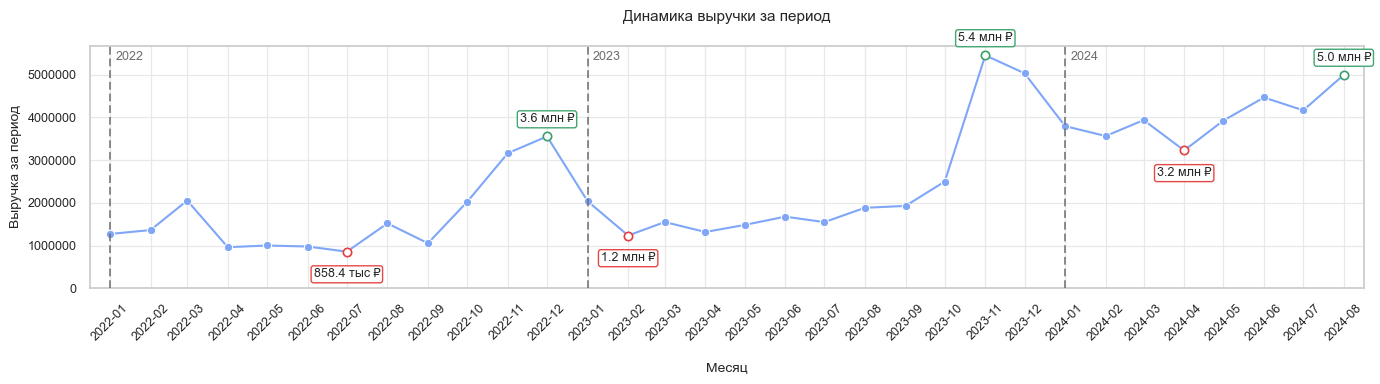

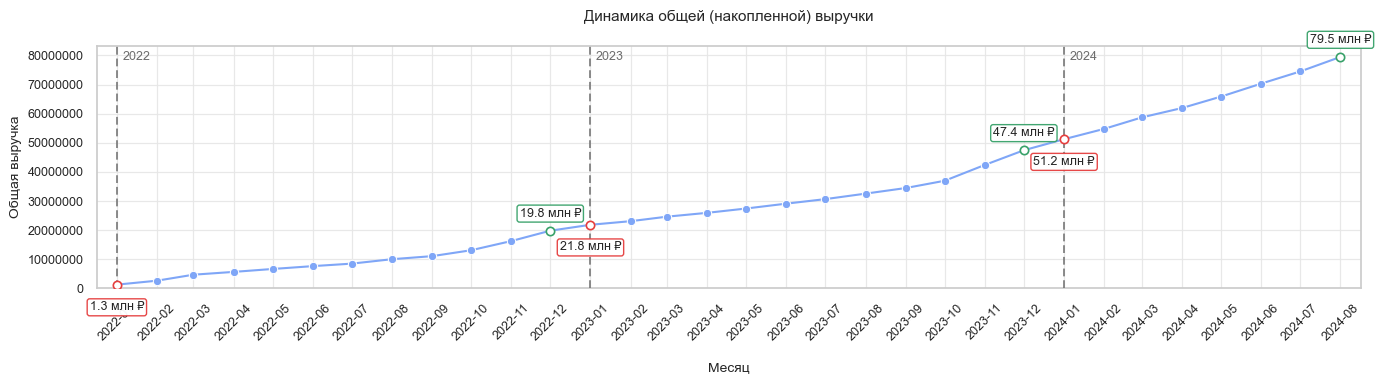

In [73]:
lineplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='Revenue', value_type='money', freq='m',
                  y_label="Выручка за период", title="Динамика выручки за период\n")

lineplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='R_cum', value_type='money', freq='m',
                  y_label="Общая выручка", title="Динамика общей (накопленной) выручки\n")

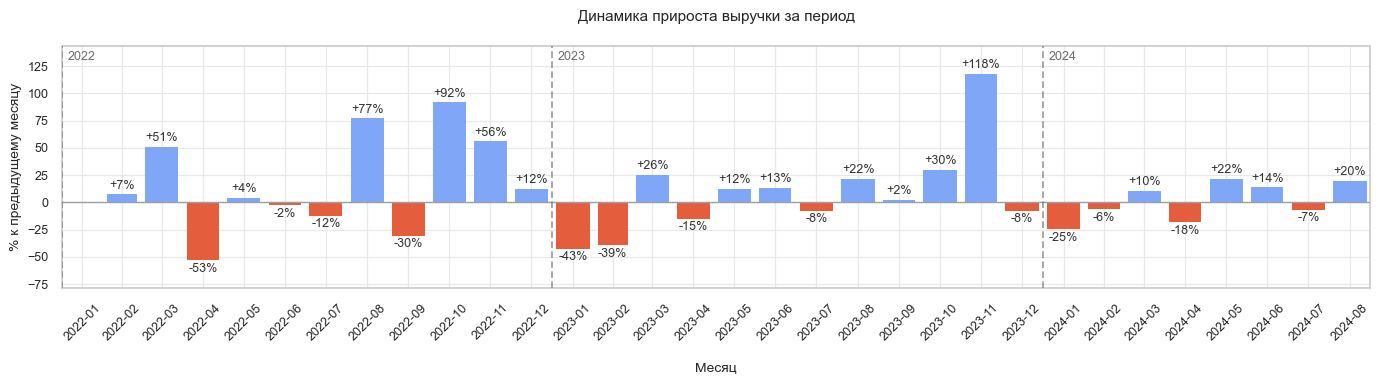

In [74]:
barplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='R_pct_chg',                 
                 x_label='\nМесяц', y_label='% к предыдущему месяцу', 
                  title='Динамика прироста выручки за период\n', freq='m')

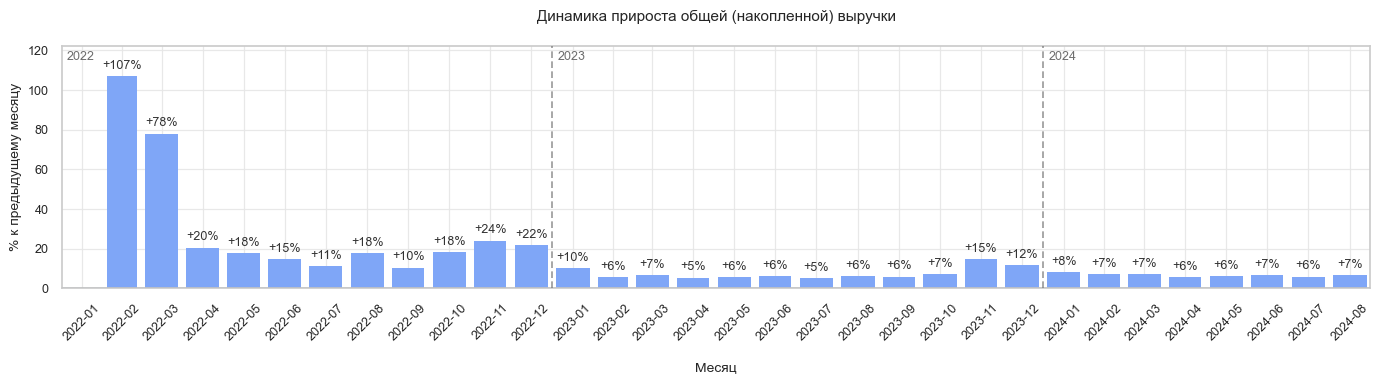

In [75]:
barplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='R_cum_pct_chg',                 
                 x_label='\nМесяц', y_label='% к предыдущему месяцу', 
                  title='Динамика прироста общей (накопленной) выручки\n', freq='m')

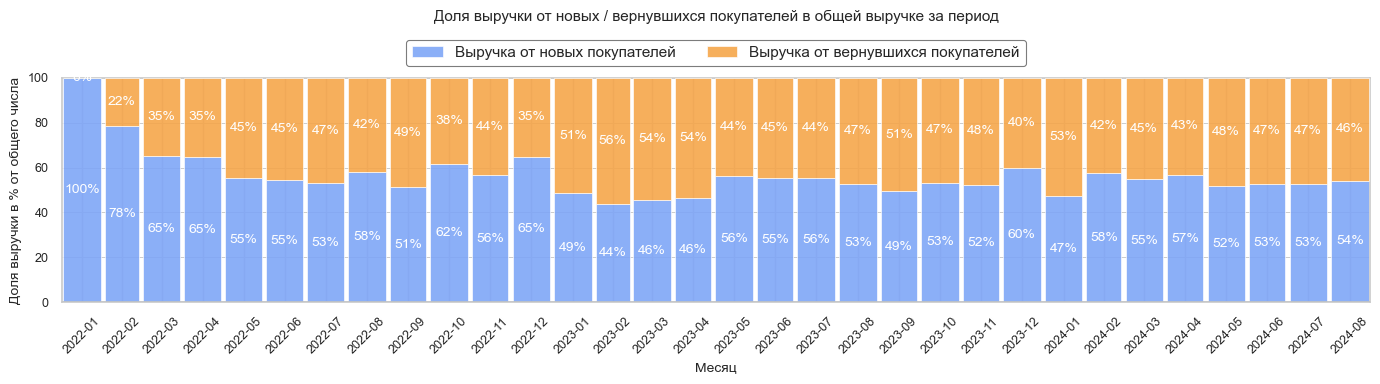

In [76]:
stacked_bars_by_period(df=key_metrics_m, x_col='purch_month', y_bottom_col='Rev_New_Cust_pct', y_top_col='Rev_Ret_Cust_pct',
                   title='Доля выручки от новых / вернувшихся покупателей в общей выручке за период\n\n\n', x_label='Месяц',
                   y_label='Доля выручки в % от общего числа', bottom_label='Выручка от новых покупателей', 
                       top_label='Выручка от вернувшихся покупателей', freq='m')

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  1.2 Orders
</div>

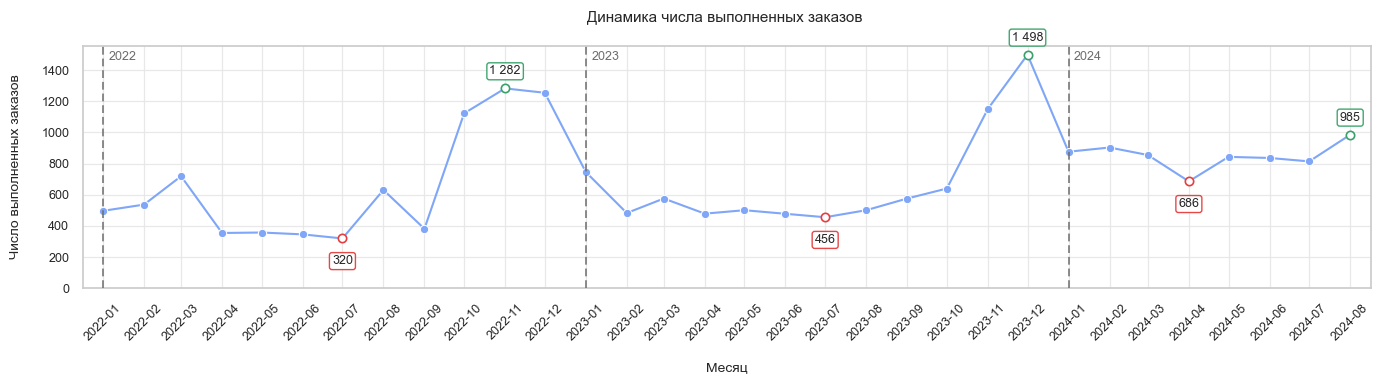

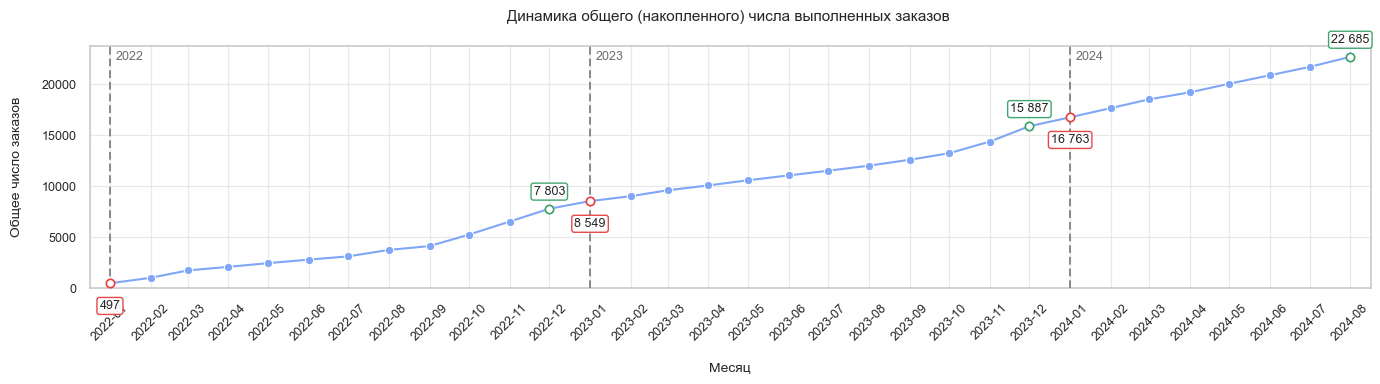

In [77]:
lineplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='Orders', freq='m',
                  y_label="Число выполненных заказов\n", title="Динамика числа выполненных заказов \n")
lineplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='O_cum', freq='m',
                  y_label="Общее число заказов\n", title="Динамика общего (накопленного) числа выполненных заказов \n")

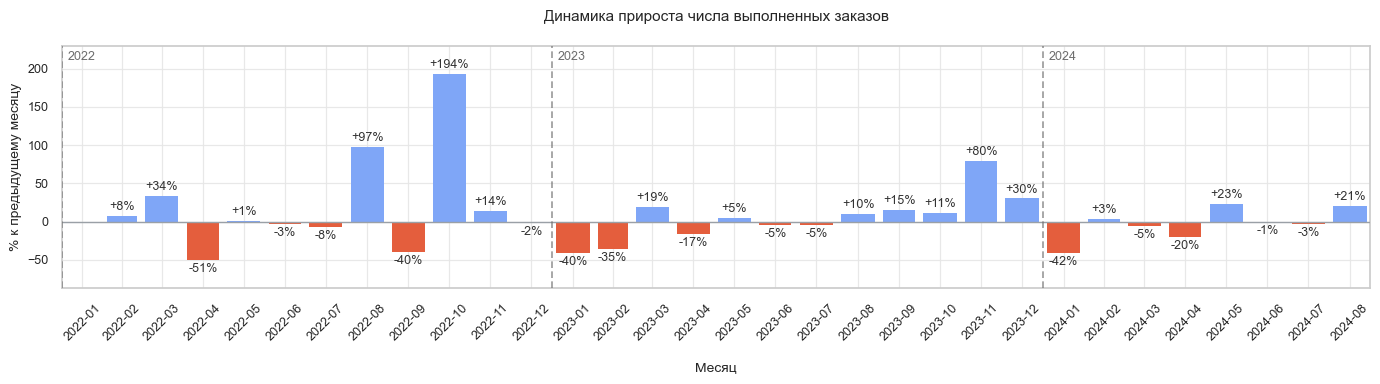

In [78]:
barplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='O_pct_chg',                 
                 x_label='\nМесяц', y_label='% к предыдущему месяцу', 
                  title='Динамика прироста числа выполненных заказов\n', freq='m')

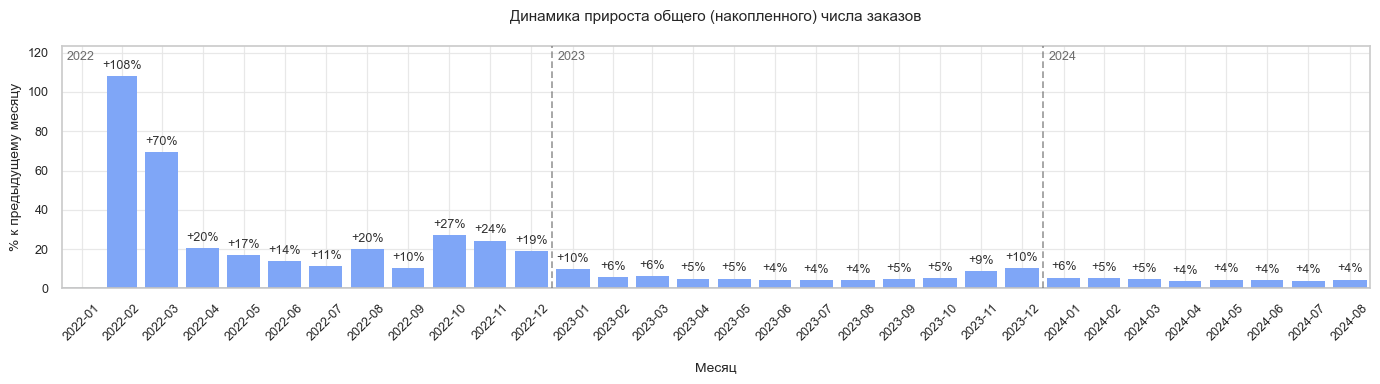

In [79]:
barplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='O_cum_pct_chg',                 
                 x_label='\nМесяц', y_label='% к предыдущему месяцу', 
                  title='Динамика прироста общего (накопленного) числа заказов\n', freq='m')

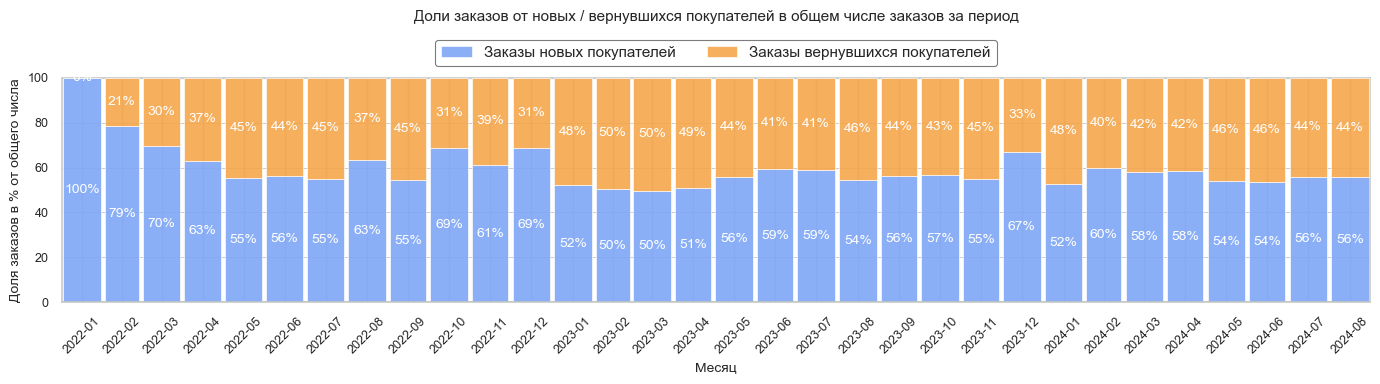

In [80]:
stacked_bars_by_period(df=key_metrics_m, x_col='purch_month', y_bottom_col='Ords_New_Cust_pct', y_top_col='Ords_Ret_Cust_pct',
                   title='Доли заказов от новых / вернувшихся покупателей в общем числе заказов за период\n\n\n', x_label='Месяц',
                   y_label='Доля заказов в % от общего числа',
                       bottom_label='Заказы новых покупателей', top_label='Заказы вернувшихся покупателей')

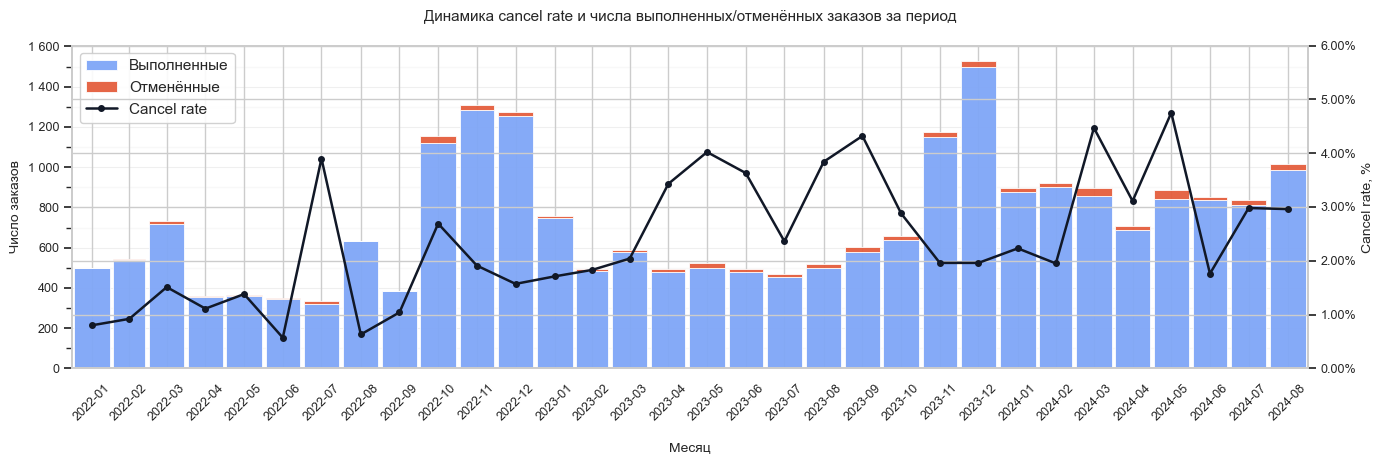

In [81]:
bars_and_line_by_period(key_metrics_m, x_label='\nМесяц', y_left='Число заказов', y_right='Cancel rate, %',
    x_col='purch_month', y_bottom='Orders', y_top='Ords_Canc', y_rate='Cancel_rate',
    title='Динамика cancel rate и числа выполненных/отменённых заказов за период\n',
    label_y_bottom='Выполненные', label_y_top='Отменённые', label_y_rate='Cancel rate', freq='m')

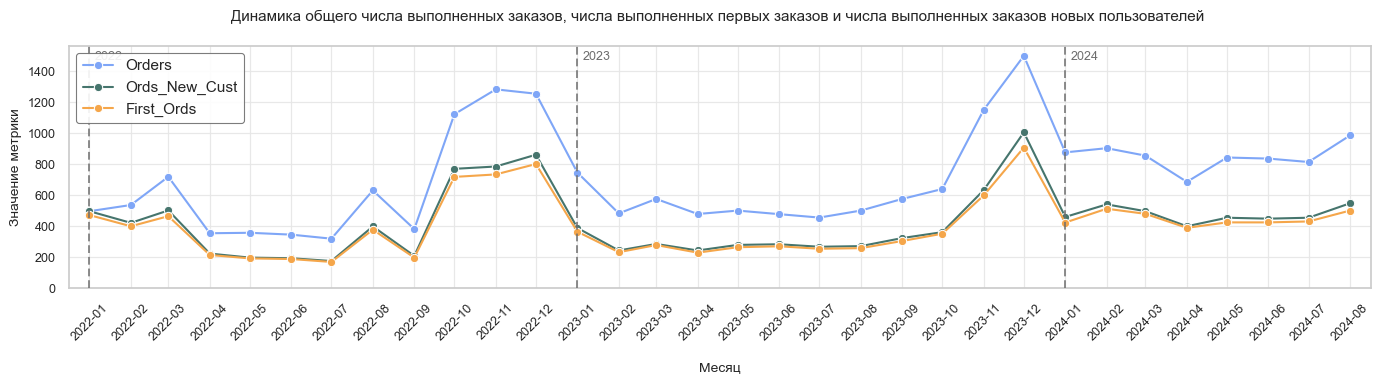

In [82]:
lineplot_by_period(df=key_metrics_m[['purch_month','Orders','First_Ords','Ords_New_Cust']].melt
                   (id_vars='purch_month', value_vars=['Orders', 'First_Ords', 'Ords_New_Cust'], var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value', hue_col='metric', 
                   y_label="Значение метрики", title="Динамика общего числа выполненных заказов, числа выполненных первых заказов и числа выполненных заказов новых пользователей \n",
                  freq='m')

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  1.3 Customers
</div>

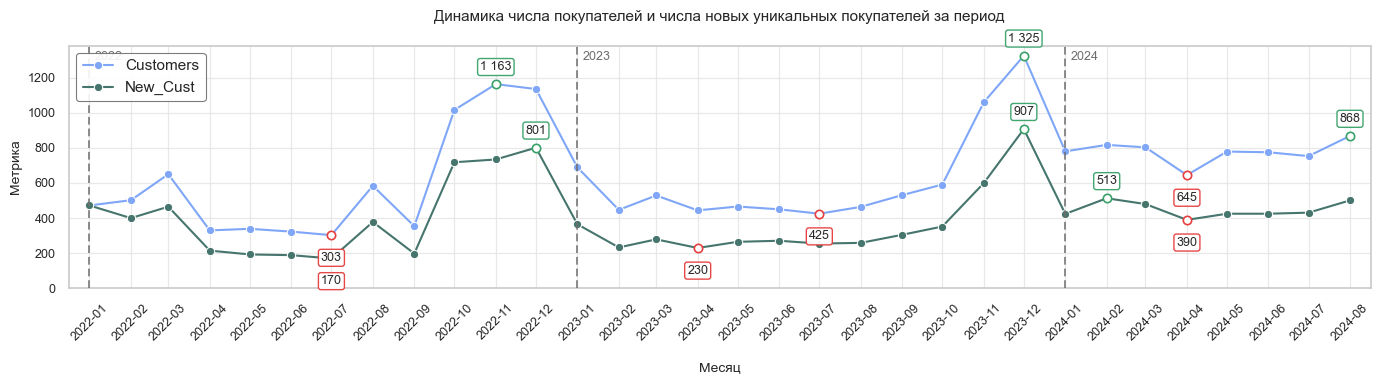

In [83]:
lineplot_by_period(df=key_metrics_m[['purch_month','Customers','New_Cust']].melt(id_vars='purch_month',
                                                                                 value_vars=['Customers', 'New_Cust'],
                                                                                 var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value', hue_col='metric', freq='m',
                   x_label="\nМесяц", y_label="Метрика", title="Динамика числа покупателей и числа новых уникальных покупателей за период\n")

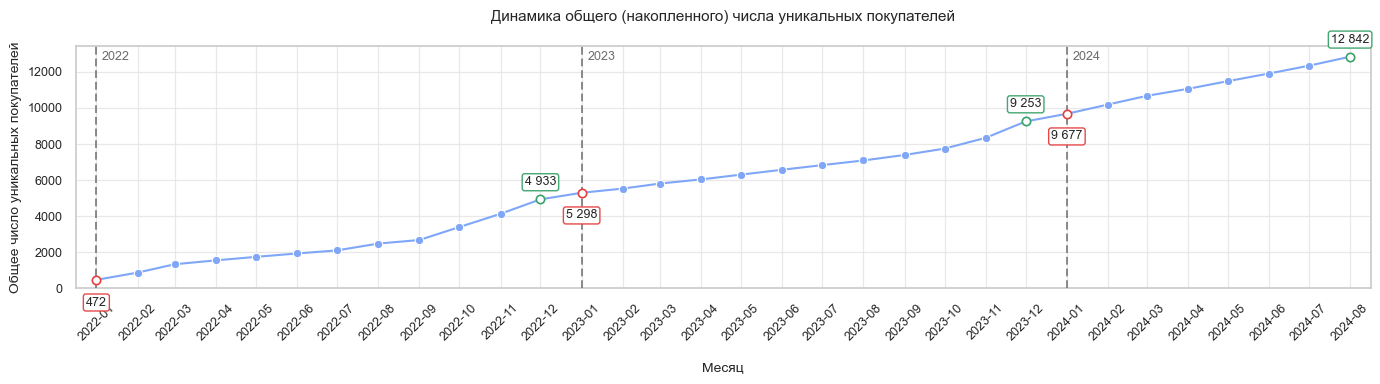

In [84]:
lineplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='New_C_cum',
                   y_label='Общее число уникальных покупателей', 
                   title='Динамика общего (накопленного) числа уникальных покупателей\n', freq='m')

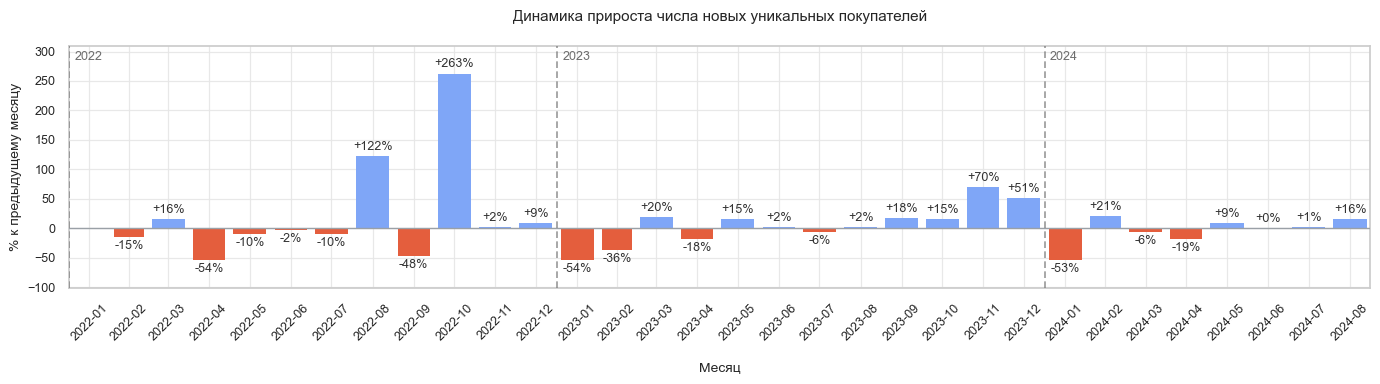

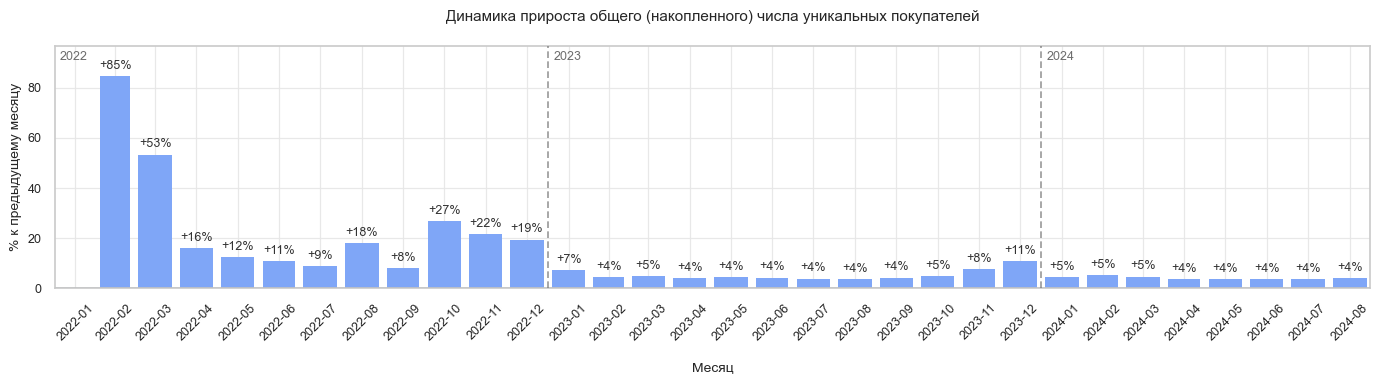

In [85]:
barplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='New_Cust_pct_chg',                 
                 x_label='\nМесяц', y_label='% к предыдущему месяцу', 
                  title='Динамика прироста числа новых уникальных покупателей\n', freq='m')
barplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='New_C_cum_pct_chg',                 
                 x_label='\nМесяц', y_label='% к предыдущему месяцу', 
                  title='Динамика прироста общего (накопленного) числа уникальных покупателей\n', freq='m')

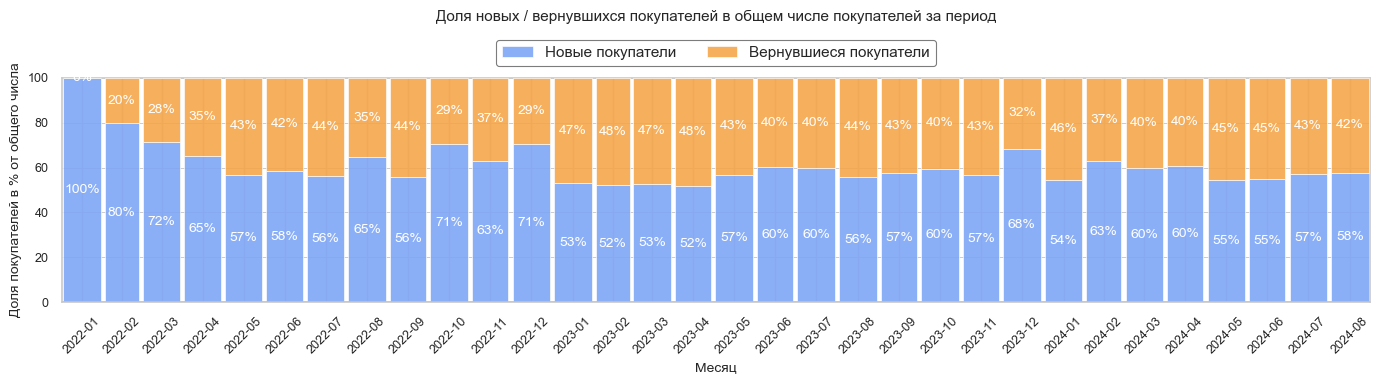

In [86]:
stacked_bars_by_period(df=key_metrics_m, x_col='purch_month', y_bottom_col='New_Cust_pct', y_top_col='Ret_Cust_pct',
                   title='Доля новых / вернувшихся покупателей в общем числе покупателей за период\n\n\n', x_label='Месяц',
                   y_label='Доля покупателей в % от общего числа', bottom_label='Новые покупатели', 
                       top_label='Вернувшиеся покупатели', freq='m')

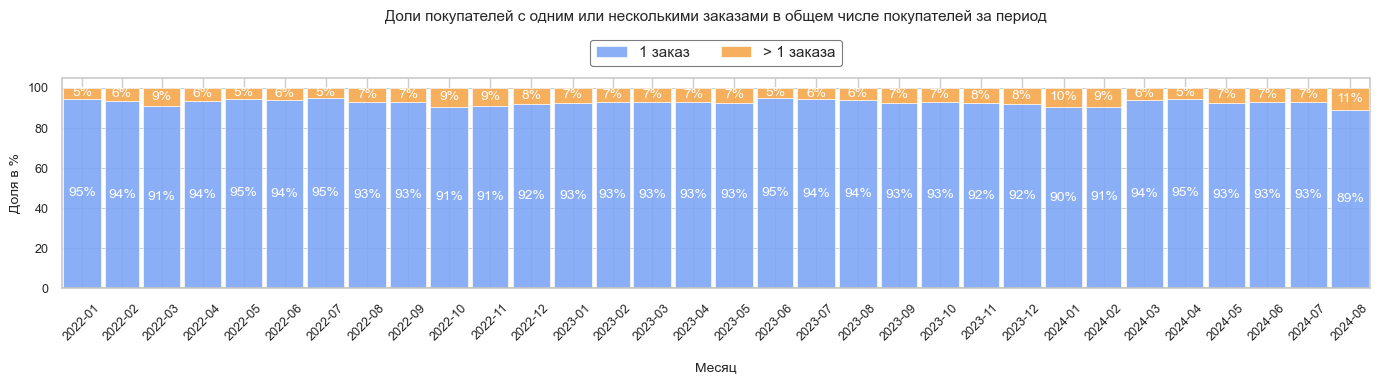

In [87]:
stacked_bars_by_period(df=key_metrics_m, x_col='purch_month', y_bottom_col='One_ord_cust_pct', y_top_col='Rep_ord_cust_pct',
                   title='Доли покупателей с одним или несколькими заказами в общем числе покупателей за период\n\n\n', x_label='\nМесяц',
                   y_label='Доля в %', bottom_label='1 заказ', top_label='> 1 заказа', freq='m')

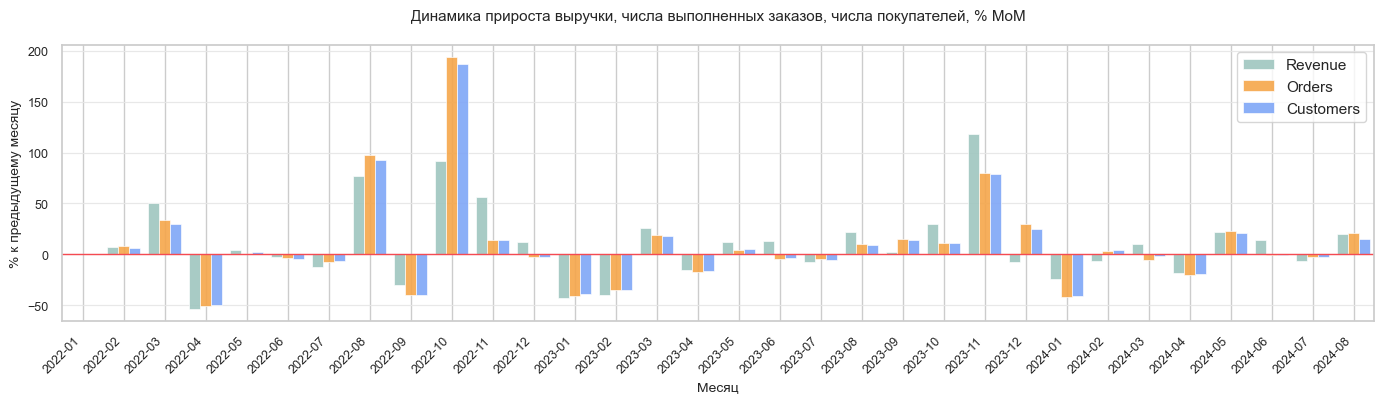

In [88]:
growth_bars_by_period(key_metrics_m, 'purch_month', y_cols=[('R_pct_chg','Revenue'), ('O_pct_chg','Orders'), ('C_pct_chg','Customers')],
                      freq='m', title='Динамика прироста выручки, числа выполненных заказов, числа покупателей, % MoM\n',
                      x_label='Месяц', y_label='% к предыдущему месяцу')

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  1.4 Монетизация на пользователя и заказ и поведенческие метрики (AOV, ARPPU, APC, AUP, Stickiness ratio)
</div>

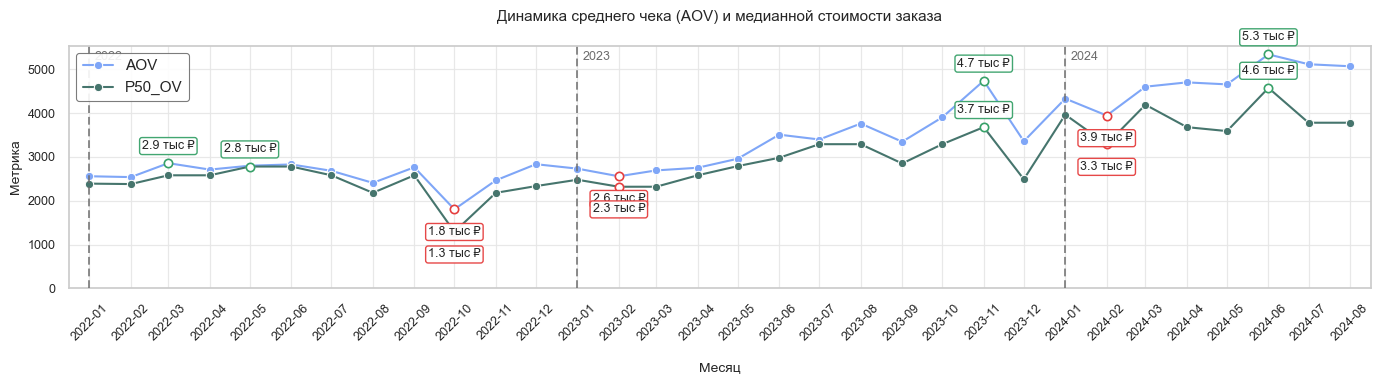

In [89]:
lineplot_by_period(df=key_metrics_m[['purch_month','AOV','P50_OV']].melt(id_vars='purch_month',
                                                                                 value_vars=['AOV', 'P50_OV'],
                                                                                 var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value',  value_type='money', hue_col='metric', freq='m',
                   x_label="\nМесяц", y_label="Метрика", title="Динамика среднего чека (AOV) и медианной стоимости заказа\n")

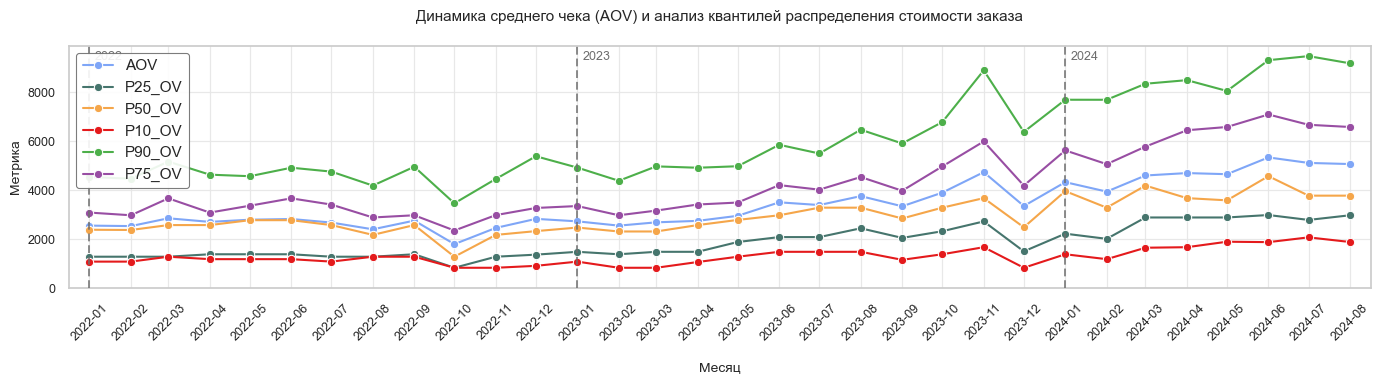

In [90]:
lineplot_by_period(df=key_metrics_m[['purch_month','AOV','P10_OV','P25_OV','P50_OV','P75_OV','P90_OV']] \
                   .melt(id_vars='purch_month', value_vars=['AOV','P10_OV','P25_OV','P50_OV','P75_OV','P90_OV'],
                    var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value',  value_type='money', hue_col='metric', freq='m',
                   x_label="\nМесяц", y_label="Метрика", title="Динамика среднего чека (AOV) и анализ квантилей распределения стоимости заказа\n")

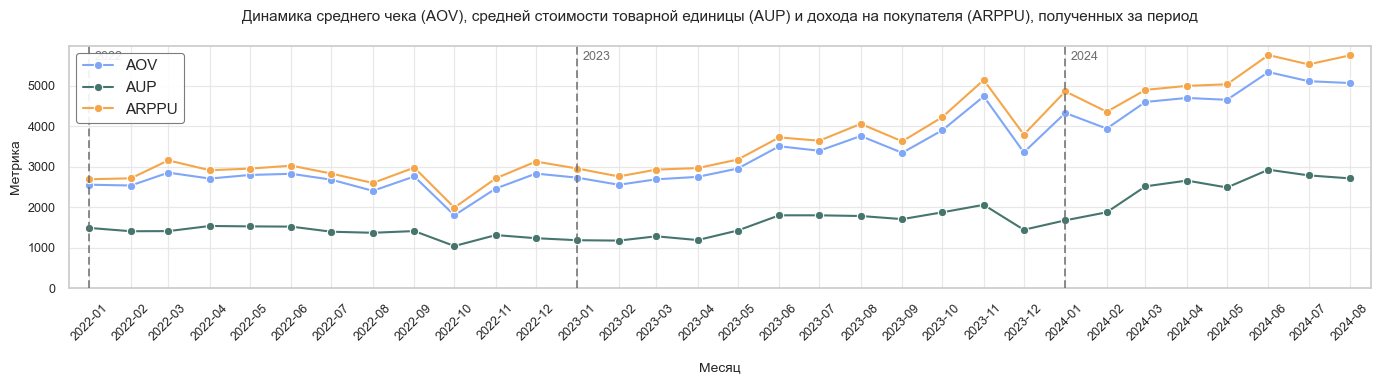

In [91]:
lineplot_by_period(df=key_metrics_m[['purch_month','AOV','ARPPU', 'AUP']].melt(id_vars='purch_month',
                                                                                 value_vars=['AOV', 'ARPPU', 'AUP'],
                                                                                 var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value',  value_type='money', hue_col='metric', freq='m',
                   x_label="\nМесяц", y_label="Метрика", title="Динамика среднего чека (AOV), средней стоимости товарной единицы (AUP) и дохода на покупателя (ARPPU), полученных за период\n")

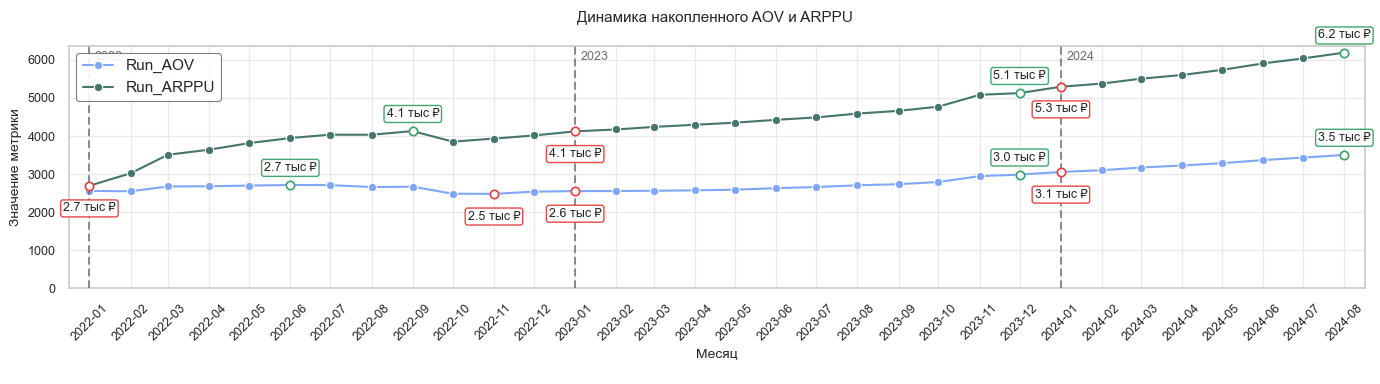

In [92]:
lineplot_by_period(df=key_metrics_m[['purch_month','Run_AOV','Run_ARPPU']].melt(id_vars='purch_month', value_vars=['Run_AOV', 'Run_ARPPU'],
                                                                        var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value',  value_type='money', hue_col='metric', freq='m',
                   x_label="Месяц\n", y_label="Значение метрики", title="Динамика накопленного AOV и ARPPU \n")

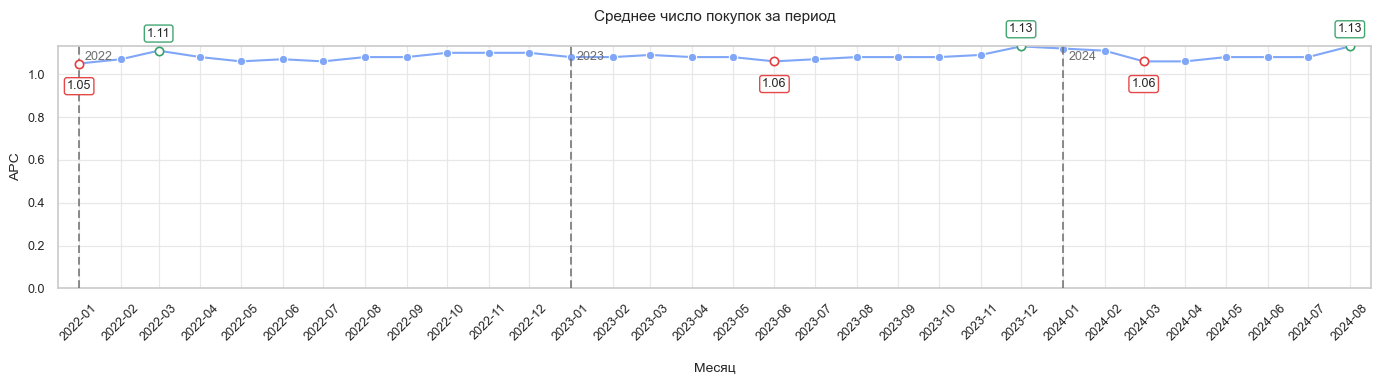

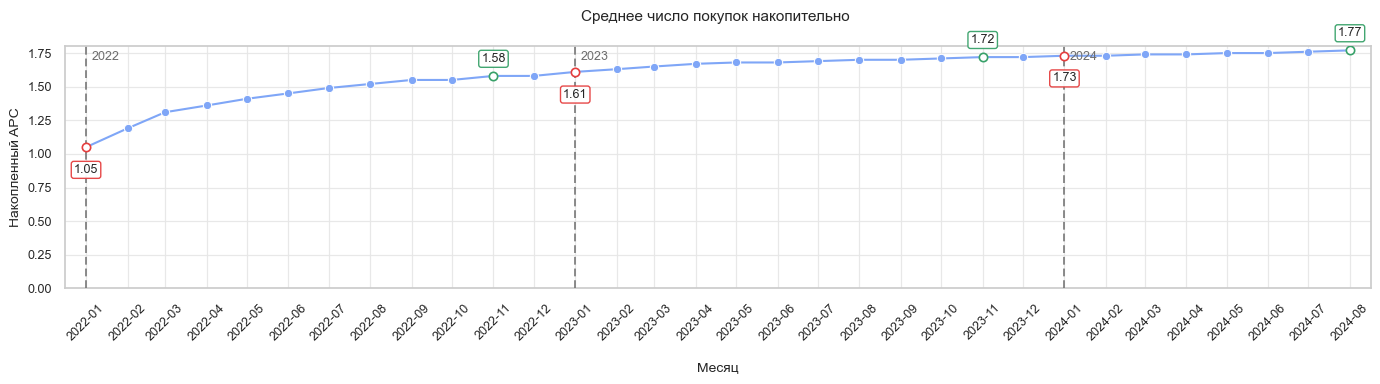

In [93]:
lineplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='APC', freq='m',
                  y_label="APC", title="Среднее число покупок за период\n", value_type='apc')
lineplot_by_period(df=key_metrics_m, x_col='purch_month', y_col='Run_APC', freq='m',
                  y_label="Накопленный APC", title="Среднее число покупок накопительно \n", value_type='apc')

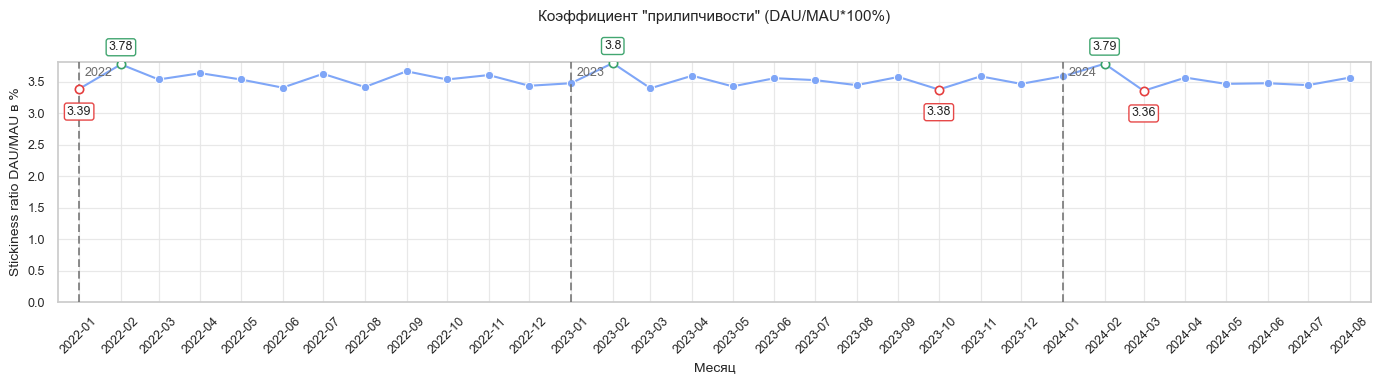

In [94]:
# Рассчитаем и визуализируем коэффициент "прилипчивости" пользователей

# Сначала найдем среднее значение DAU по месяцам
mdau = successful_orders \
            .groupby(['purch_month', 'purch_day']).customer_id.nunique().reset_index(name='DAU') \
            .groupby(['purch_month'], as_index=False).DAU.mean().round() 
# Рассчитаем MAU по месяцам
mau = successful_orders \
            .groupby('purch_month').customer_id.nunique().reset_index(name='MAU')
# Выведем коэффициент DAU/MAU
stickiness = mdau.merge(mau).assign(k_stickiness = lambda df: round(100*(df.DAU / df.MAU),2))
# Визуализируем коэффциент DAU/MAU
lineplot_by_period(df=stickiness, x_col='purch_month', y_col='k_stickiness', value_type='apc',
                  x_label="Месяц", y_label="Stickiness ratio DAU/MAU в %", title='Коэффициент "прилипчивости" (DAU/MAU*100%)\n\n')

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  1.5 Сравнение ARPPU, AOV, APC, AUP, UPT по новым / вернувшимся покупателям
</div>

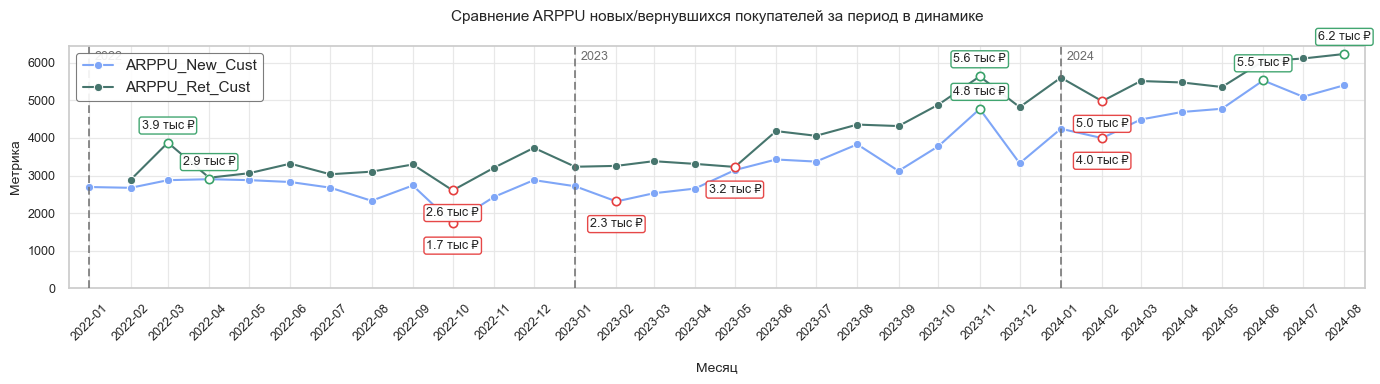

In [95]:
lineplot_by_period(df=key_metrics_m[['purch_month','ARPPU_New_Cust','ARPPU_Ret_Cust']].melt(id_vars='purch_month',
                                                                                        value_vars=['ARPPU_New_Cust', 'ARPPU_Ret_Cust'], 
                                                                                        var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value',  value_type='money', hue_col='metric', freq='m',
                   y_label="Метрика", title="Сравнение ARPPU новых/вернувшихся покупателей за период в динамике\n")

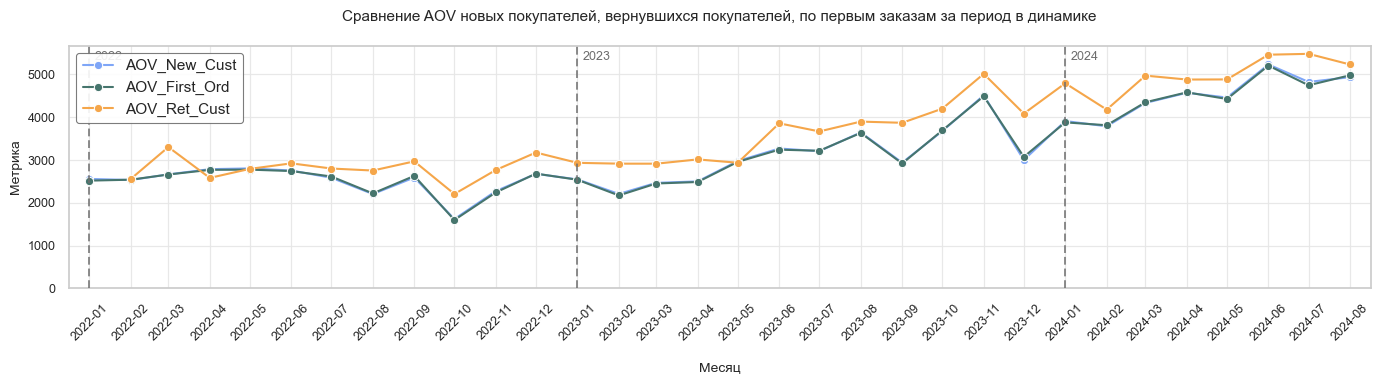

In [96]:
lineplot_by_period(df=key_metrics_m[['purch_month','AOV_New_Cust','AOV_Ret_Cust','AOV_First_Ord']].melt(id_vars='purch_month',
value_vars=['AOV_New_Cust', 'AOV_Ret_Cust', 'AOV_First_Ord'], var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value',  value_type='money', hue_col='metric', freq='m',
                   y_label="Метрика", title="Сравнение AOV новых покупателей, вернувшихся покупателей, по первым заказам за период в динамике\n")

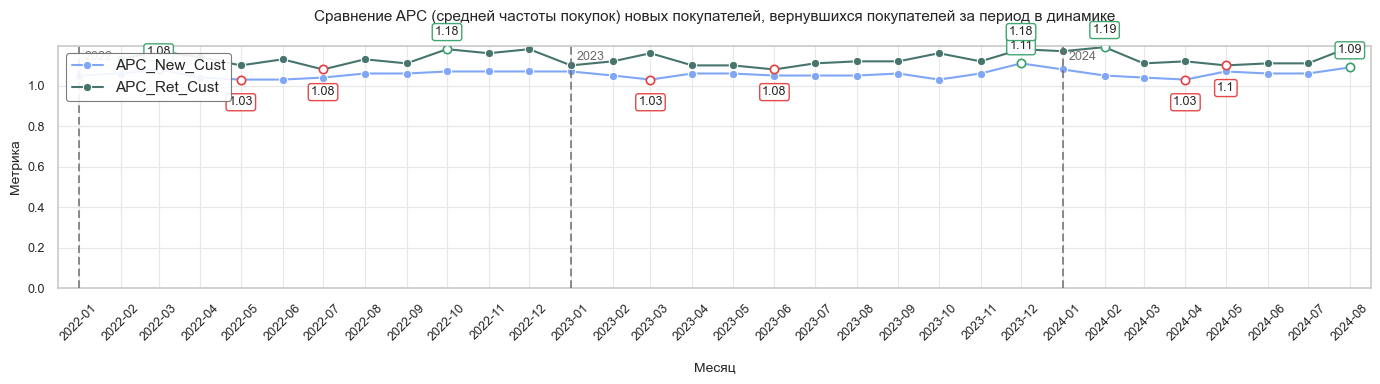

In [97]:
lineplot_by_period(df=key_metrics_m[['purch_month','APC_New_Cust','APC_Ret_Cust']].melt(id_vars='purch_month',
value_vars=['APC_New_Cust','APC_Ret_Cust'], var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value',  value_type='apc', hue_col='metric', freq='m',
                   y_label="Метрика", title="Сравнение APC (средней частоты покупок) новых покупателей, вернувшихся покупателей за период в динамике\n")

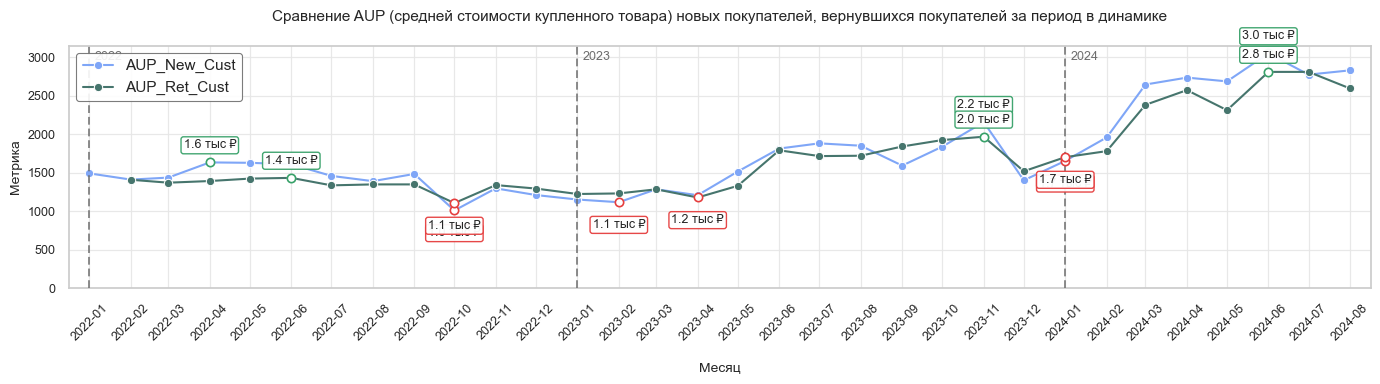

In [98]:
lineplot_by_period(df=key_metrics_m[['purch_month','AUP_New_Cust','AUP_Ret_Cust']].melt(id_vars='purch_month',
value_vars=['AUP_New_Cust', 'AUP_Ret_Cust'], var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value',  value_type='money', hue_col='metric', freq='m',
                   y_label="Метрика", title="Сравнение AUP (средней стоимости купленного товара) новых покупателей, вернувшихся покупателей за период в динамике\n")

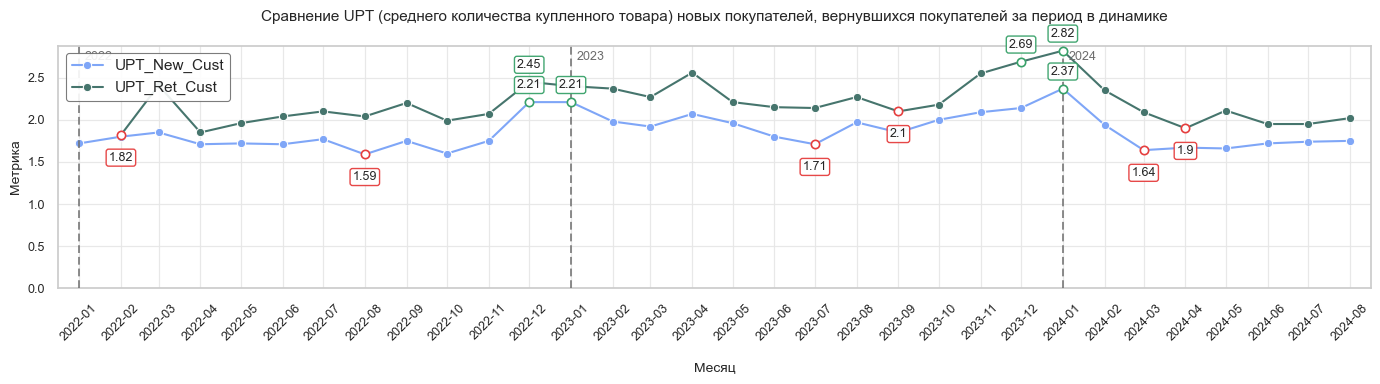

In [99]:
lineplot_by_period(df=key_metrics_m[['purch_month','UPT_New_Cust','UPT_Ret_Cust']].melt(id_vars='purch_month',
value_vars=['UPT_New_Cust', 'UPT_Ret_Cust'], var_name='metric', value_name='value'), 
                   x_col='purch_month', y_col='value',  value_type='apc', hue_col='metric', freq='m',
                   y_label="Метрика", title="Сравнение UPT (среднего количества купленного товара) новых покупателей, вернувшихся покупателей за период в динамике\n")

<div 
style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.8em 0; padding:1em 1.2em; background:#ebf1ee; border:1px solid #48735a; border-radius:8px; line-height:1.5;">

##### 🌿 Обзор витрины ключевых метрик по месяцам: основные моменты 
__________________

1. **Выручка** с 2022 г. по 2024 г. выросла в разы, пиковые значения в месяц выросли с ~3,6 млн ₽ в декабре 2022 г. до ~5,4 млн ₽ в ноябре 2023 г. и ~5,0 млн ₽ в августе 2024 г. _(прим.: данные за 2024 г. неполные)_      
2. Заметна **сильная сезонность бизнеса:** октябрь-декабрь в заметном отрыве по выручке, числу заказов и покупателей, при этом в первые месяцы года наступает заметный спад показателей (период охлаждения после сильного спроса)
3. **Базовый "несезонный" уровень метрик растёт год от года**, особенно это заметно в 2024 г. (выручка, заказы, покупатели). 
4. **Рост выручки** объясняется увеличением средней стоимости заказа и числа покупателей (и как следствие числа заказов) при практически неизменной частоте покупок.  
5. **Основной драйвер роста — новые покупатели**, но повторные особенно ценны: **ARPPU, APC, AOV повторных существенно выше**.
6. **Средний чек (AOV) и доход на покупателя (ARPPU) растут устойчиво:**  
   - AOV: с ~2,5 тыс ₽ до ~5 тыс ₽ в 2024 г.;  
   - ARPPU: с ~2,7 тыс ₽ до ~5,7 тыс ₽.  
7. **Ассортиментная матрица и ценовая политика работают на рост монетизации.**  
   Анализ стоимости заказа по квантилям распределения показывает рост всех уровней. Это говорит не о единичных дорогих заказах, а о выравнивании вверх всей структуры чеков. Растёт и "типичный" заказ, и дорогой сегмент.
8. **Частота покупок остаётся практически неизменной:**  
   - В месяц 90-95% покупателей делают 1 заказ, и только 5-10% больше одного. 
   - Накопительная частота покупок примерно 1,77, то есть за всё время (2,5 года) средний клиент сделал меньше 2 заказов. 
9. **Качество исполнения:** Cancel rate стабилен на уровне 2-5% без ухудшений.    
<br>

**Итого:**  
Уже сложившиеся драйверы роста — **привлечение новых покупателей и рост среднего чека**, при этом наибольший нереализованный потенциал в **частоте покупок и удержании**. 
</div>

<div style="background:#3b5e4a; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  2. Динамика ключевых метрик по кварталам
</div>

In [100]:
# Посчитаем витрину ключевых метрик по кварталам
key_metrics_q = build_key_metrics(df=successful_orders, df_of_canc=cancelled_orders, time_col='purch_quarter', cohort_col='cohort_quarter')
key_metrics_q

purch_quarter   Revenue  R_pct_chg     R_cum  R_cum_pct_chg  Rev_New_Cust  \
0     2022-01-01   4689006        NaN   4689006            NaN       4689006   
1     2022-04-01   2942766      -37.2   7631772           62.8       1875594   
2     2022-07-01   3432641       16.6  11064413           45.0       2106085   
3     2022-10-01   8736535      154.5  19800948           79.0       6007760   
4     2023-01-01   4823868      -44.8  24624816           24.4       2476498   
5     2023-04-01   4477061       -7.2  29101877           18.2       2582807   
6     2023-07-01   5360413       19.7  34462290           18.4       3085876   
7     2023-10-01  12976363      142.1  47438653           37.7       7791222   
8     2024-01-01  11290100      -13.0  58728753           23.8       6567146   
9     2024-04-01  11612342        2.9  70341095           19.8       6788476   
10    2024-07-01   9155792      -21.2  79496887           13.0       5186363   

    Rev_New_Cust_pct  Rev_Ret_Cust_pct  Orders  O_pct_chg  O_cum  \
0              100.0               0.0    1753        NaN   1753   
1               63.7              36.3    1059      -39.6   2812   
2               61.4              38.6    1333       25.9   4145   
3               68.8              31.2    3658      174.4   7803   
4               51.3              48.7    1805      -50.7   9608   
5               57.7              42.3    1458      -19.2  11066   
6               57.6              42.4    1533        5.1  12599   
7               60.0              40.0    3288      114.5  15887   
8               58.2              41.8    2634      -19.9  18521   
9               58.5              41.5    2365      -10.2  20886   
10              56.6              43.4    1799      -23.9  22685   

    O_cum_pct_chg  First_Ords  First_Ords_pct  Ords_New_Cust  \
0             NaN        1337            76.3           1753   
1            60.4         597            56.4            674   
2            47.4         746            56.0            869   
3            88.3        2253            61.6           2658   
4            23.1         877            48.6           1007   
5            15.2         766            52.5            866   
6            13.9         819            53.4            933   
7            26.1        1858            56.5           2123   
8            16.6        1417            53.8           1623   
9            12.8        1240            52.4           1421   
10            8.6         932            51.8           1057   

    Ords_New_Cust_pct  Ords_Ret_Cust_pct  Ords_Canc  Cancel_rate  Customers  \
0               100.0                0.0         20       0.0113       1337   
1                63.6               36.4         11       0.0103        822   
2                65.2               34.8         21       0.0155       1062   
3                72.7               27.3         76       0.0204       2868   
4                55.8               44.2         34       0.0185       1447   
5                59.4               40.6         56       0.0370       1204   
6                60.9               39.1         57       0.0358       1249   
7                64.6               35.4         72       0.0214       2679   
8                61.6               38.4         78       0.0288       2102   
9                60.1               39.9         79       0.0323       1923   
10               58.8               41.2         55       0.0297       1513   

    C_pct_chg  New_Cust  New_Cust_pct_chg  New_C_cum  New_C_cum_pct_chg  \
0         NaN      1337               NaN       1337                NaN   
1       -38.5       597             -55.3       1934               44.7   
2        29.2       746              25.0       2680               38.6   
3       170.1      2253             202.0       4933               84.1   
4       -49.5       877             -61.1       5810               17.8   
5       -16.8       766             -12.7       6576     

In [101]:
# Выведем витрину в более удобном интерактивном виде
show(key_metrics_q, scrollX=True, fixedColumns={"leftColumns": 1})

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  2.1. Revenue
</div>

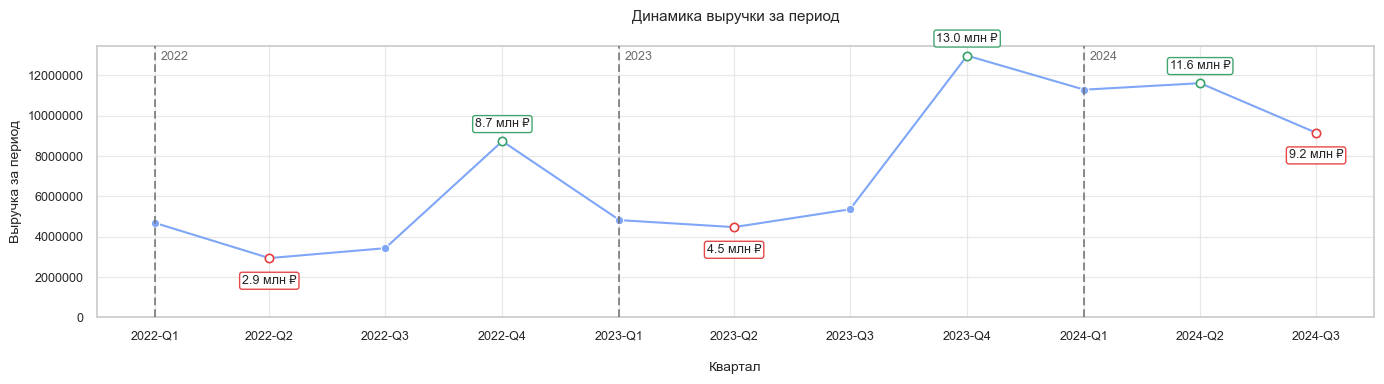

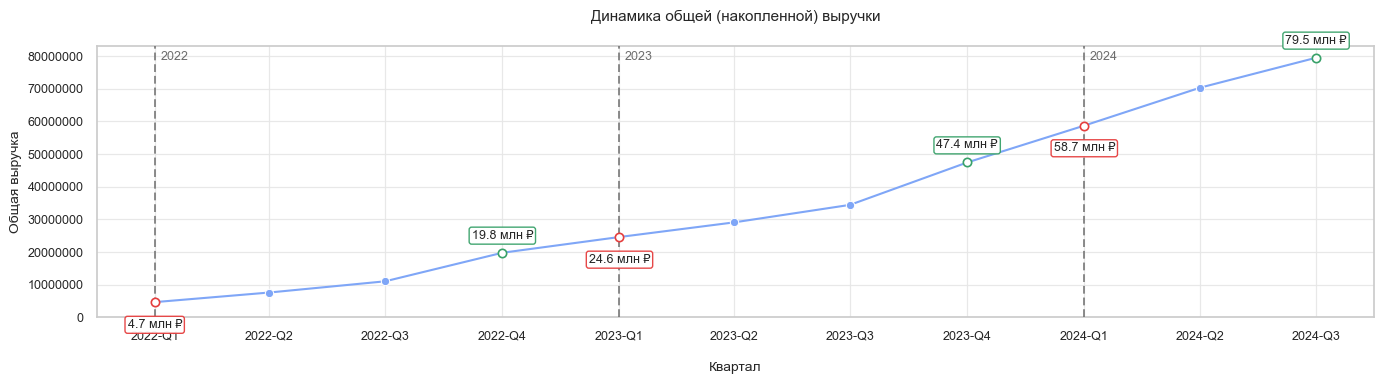

In [102]:
lineplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='Revenue', value_type='money', freq='q',
                  y_label="Выручка за период", title="Динамика выручки за период\n")

lineplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='R_cum', value_type='money', freq='q',
                  y_label="Общая выручка", title="Динамика общей (накопленной) выручки\n")

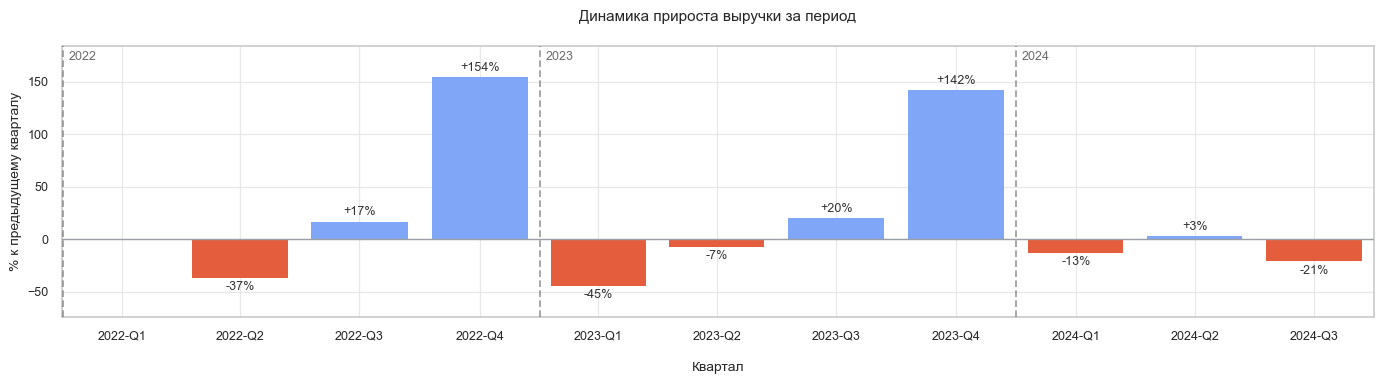

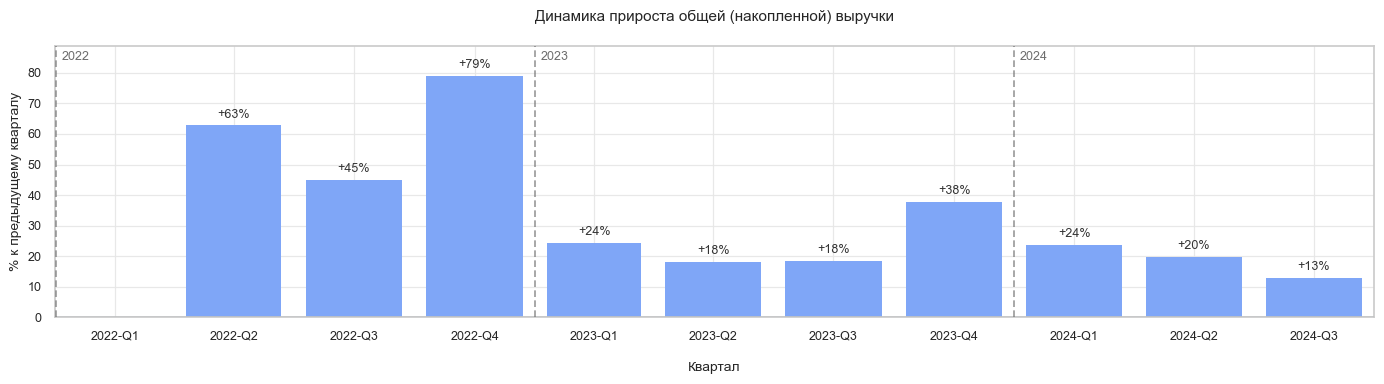

In [103]:
barplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='R_pct_chg',                 
                 x_label='\nКвартал', y_label='% к предыдущему кварталу', 
                  title='Динамика прироста выручки за период\n', freq='q')
barplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='R_cum_pct_chg',                 
                 x_label='\nКвартал', y_label='% к предыдущему кварталу', 
                  title='Динамика прироста общей (накопленной) выручки\n', freq='q')

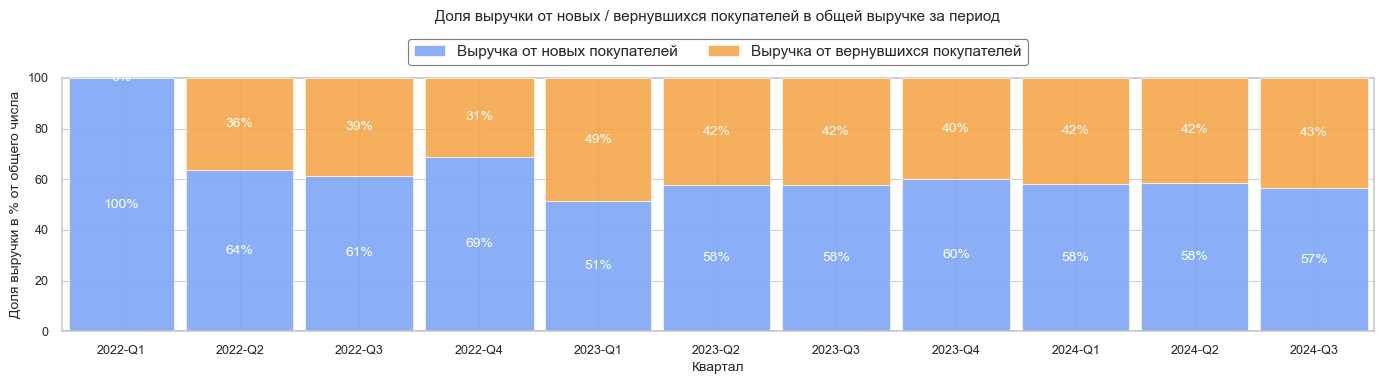

In [104]:
stacked_bars_by_period(df=key_metrics_q, x_col='purch_quarter', y_bottom_col='Rev_New_Cust_pct', y_top_col='Rev_Ret_Cust_pct',
                   title='Доля выручки от новых / вернувшихся покупателей в общей выручке за период\n\n\n', x_label='Квартал',
                   y_label='Доля выручки в % от общего числа', bottom_label='Выручка от новых покупателей', 
                       top_label='Выручка от вернувшихся покупателей', freq='q')

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  2.2 Orders
</div>

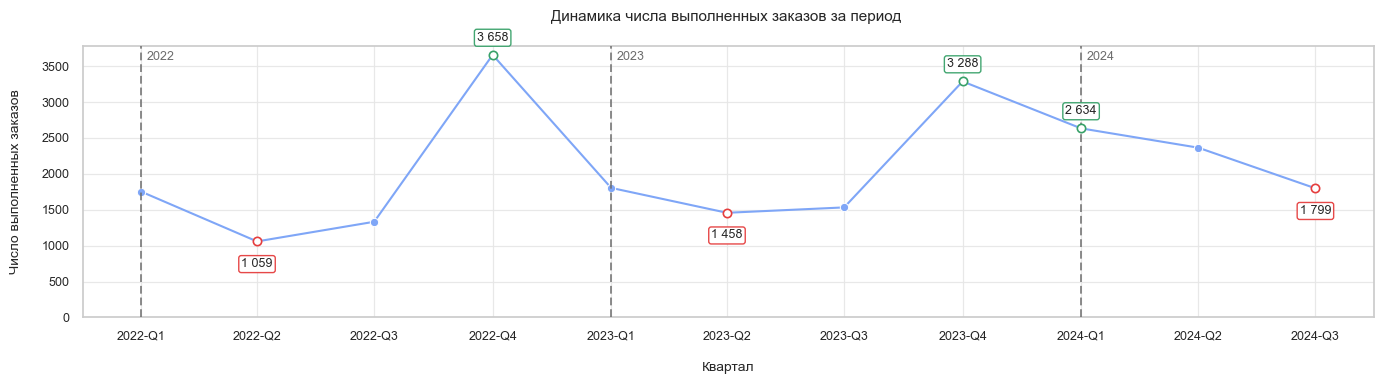

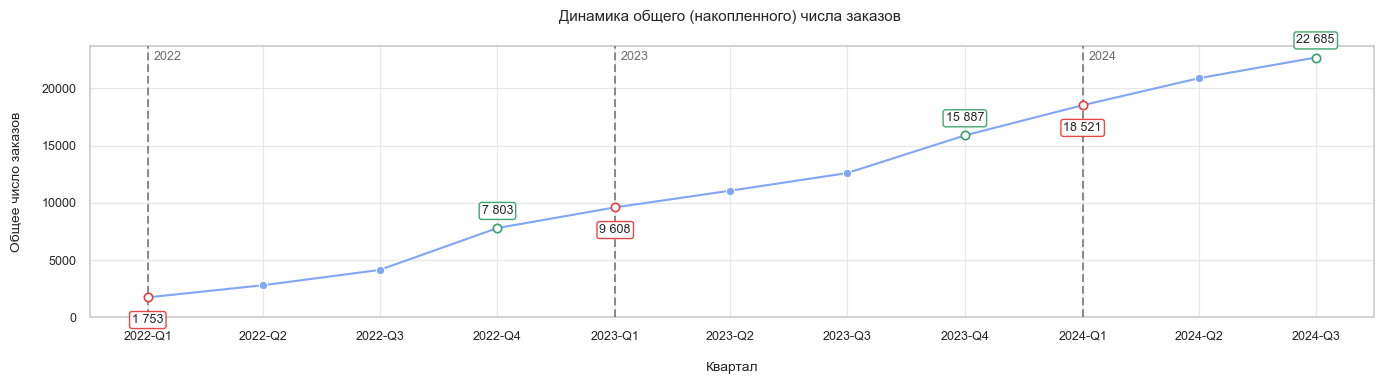

In [105]:
lineplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='Orders', freq='q',
                  y_label="Число выполненных заказов\n", title="Динамика числа выполненных заказов за период \n")
lineplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='O_cum', freq='q',
                  y_label="Общее число заказов\n", title="Динамика общего (накопленного) числа заказов \n")

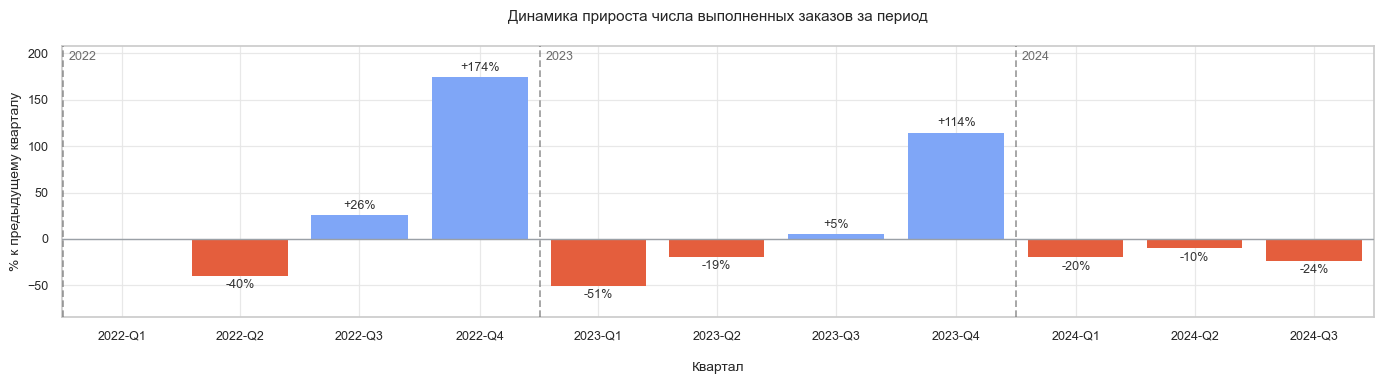

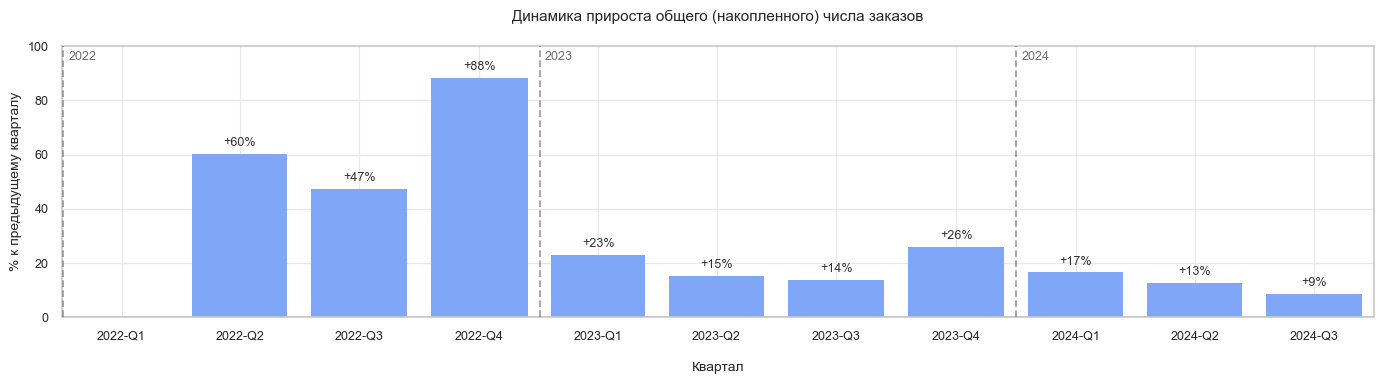

In [106]:
barplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='O_pct_chg',                 
                 x_label='\nКвартал', y_label='% к предыдущему кварталу', 
                  title='Динамика прироста числа выполненных заказов за период\n', freq='q')
barplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='O_cum_pct_chg',                 
                 x_label='\nКвартал', y_label='% к предыдущему кварталу', 
                  title='Динамика прироста общего (накопленного) числа заказов\n', freq='q')

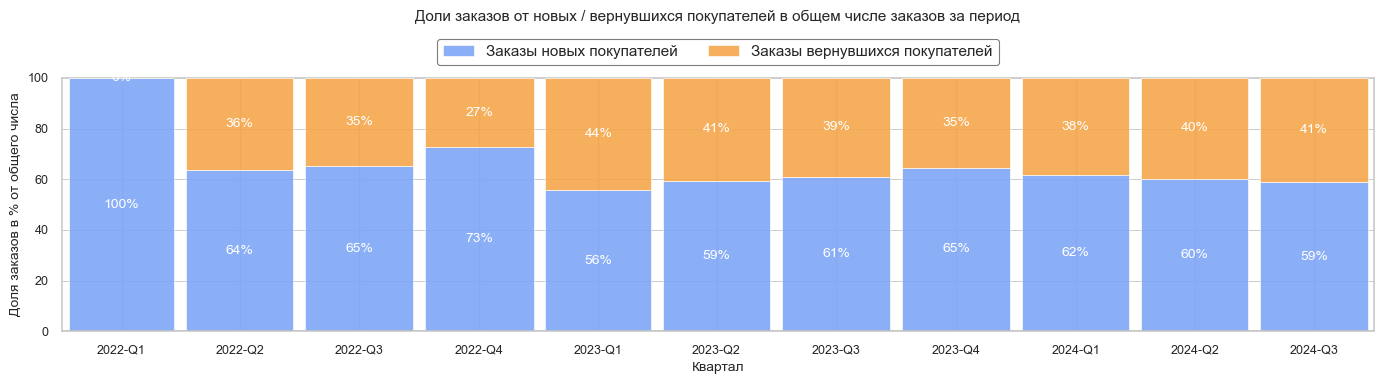

In [107]:
stacked_bars_by_period(df=key_metrics_q, x_col='purch_quarter', y_bottom_col='Ords_New_Cust_pct', y_top_col='Ords_Ret_Cust_pct',
                   title='Доли заказов от новых / вернувшихся покупателей в общем числе заказов за период\n\n\n', x_label='Квартал',
                   y_label='Доля заказов в % от общего числа',
                       bottom_label='Заказы новых покупателей', top_label='Заказы вернувшихся покупателей', freq='q')

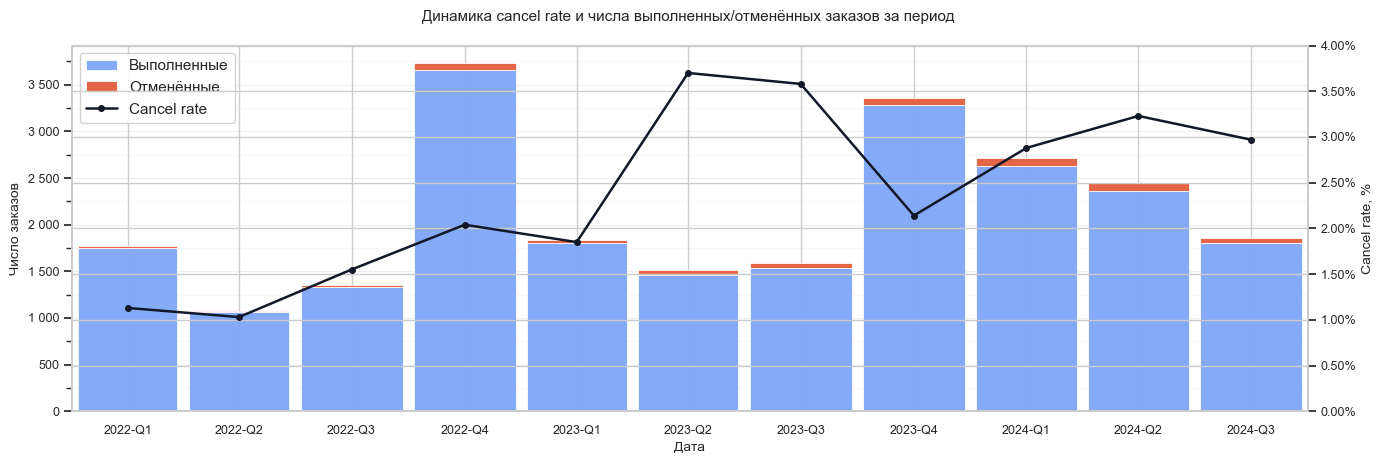

In [108]:
bars_and_line_by_period(key_metrics_q, x_label='Дата', y_left='Число заказов', y_right='Cancel rate, %',
    x_col='purch_quarter', y_bottom='Orders', y_top='Ords_Canc', y_rate='Cancel_rate',
    title='Динамика cancel rate и числа выполненных/отменённых заказов за период \n',
    label_y_bottom='Выполненные', label_y_top='Отменённые', label_y_rate='Cancel rate', freq='q')

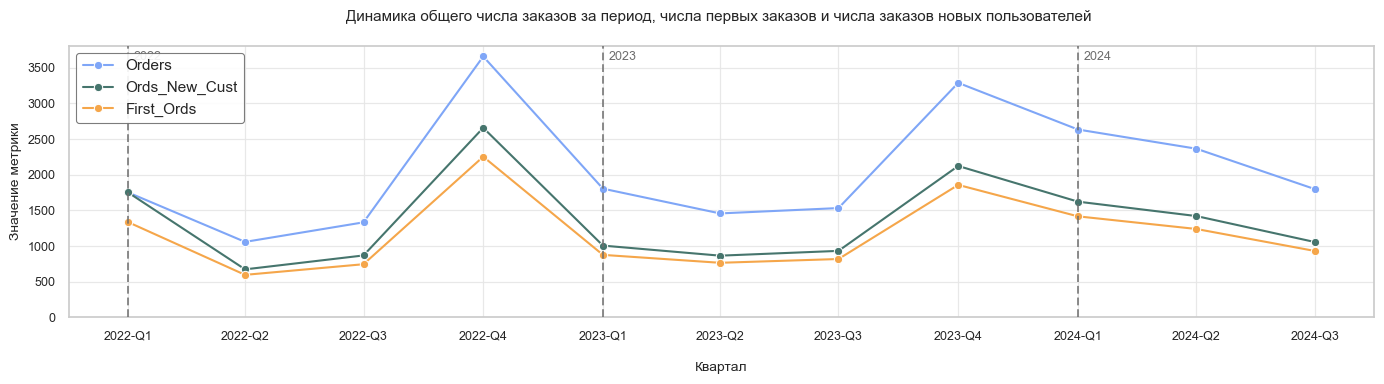

In [109]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','Orders','First_Ords','Ords_New_Cust']].melt
                   (id_vars='purch_quarter', value_vars=['Orders', 'First_Ords', 'Ords_New_Cust'], var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value', hue_col='metric', 
                   y_label="Значение метрики",
                   title="Динамика общего числа заказов за период, числа первых заказов и числа заказов новых пользователей \n", freq='q')

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  2.3 Customers
</div>

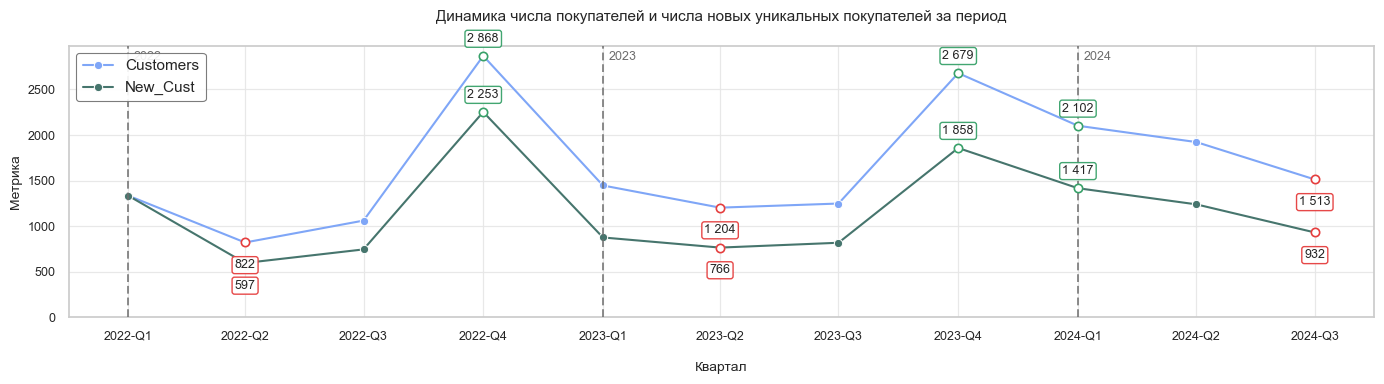

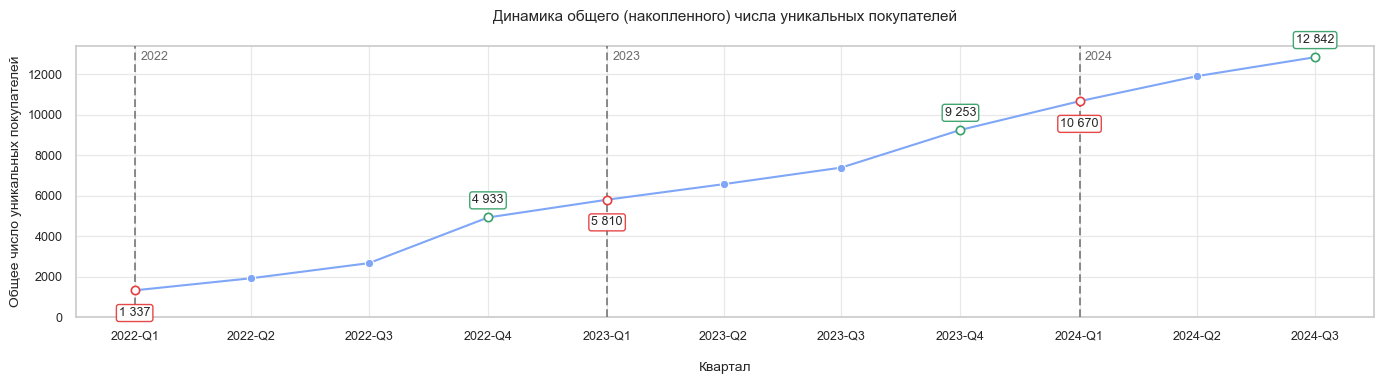

In [110]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','Customers','New_Cust']].melt(id_vars='purch_quarter',
                                                                                 value_vars=['Customers', 'New_Cust'],
                                                                                 var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value', hue_col='metric', freq='q',
                   x_label="\nКвартал", y_label="Метрика", title="Динамика числа покупателей и числа новых уникальных покупателей за период\n")
lineplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='New_C_cum',
                   y_label='Общее число уникальных покупателей', 
                   title='Динамика общего (накопленного) числа уникальных покупателей\n', freq='q')

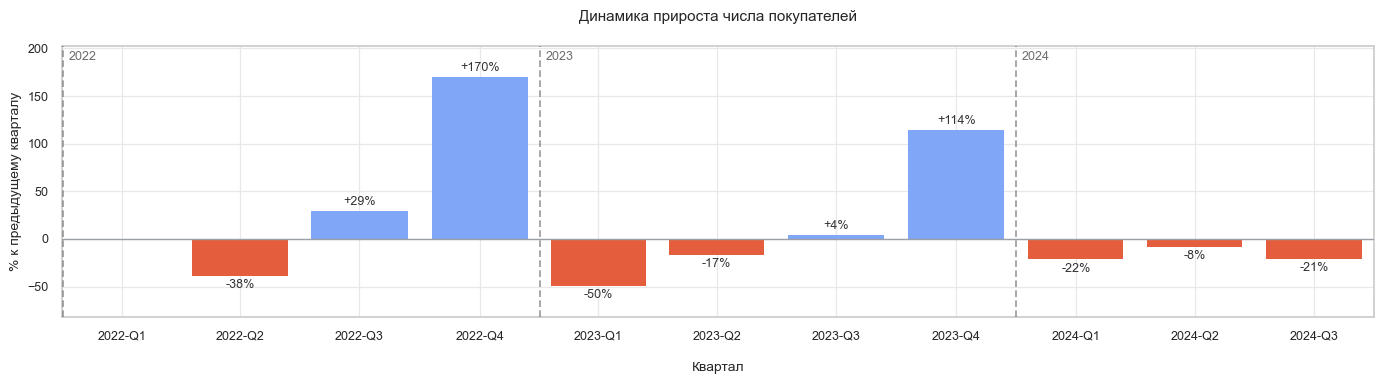

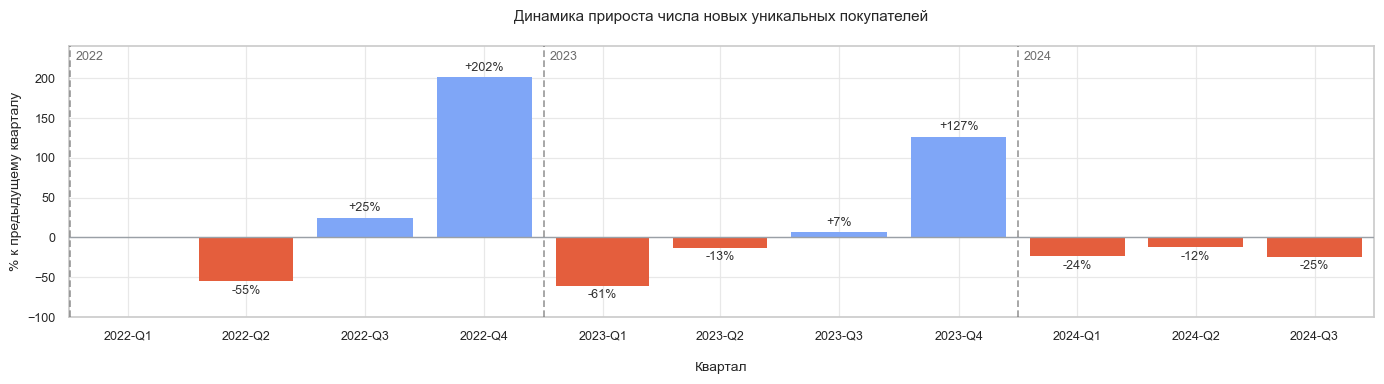

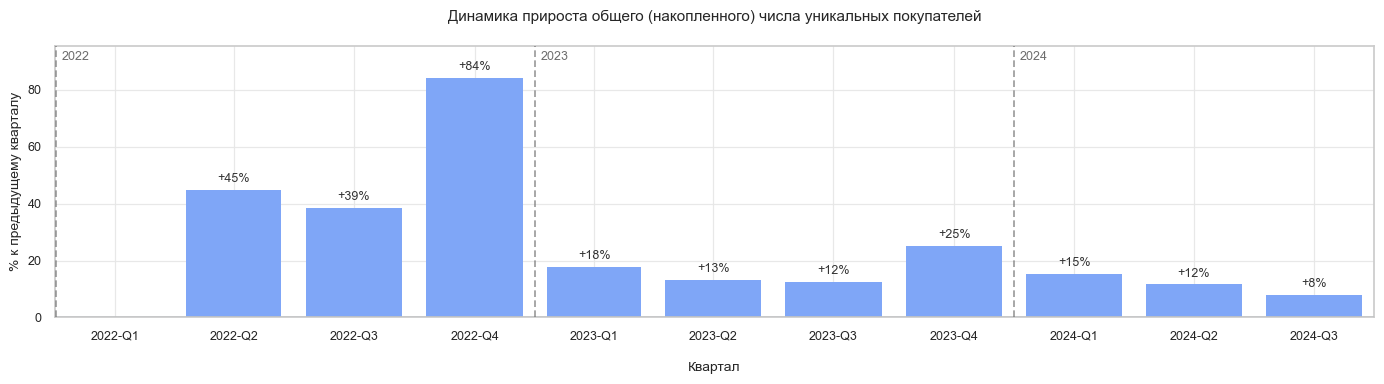

In [111]:
barplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='C_pct_chg',                 
                 x_label='\nКвартал', y_label='% к предыдущему кварталу', 
                  title='Динамика прироста числа покупателей\n', freq='q')
barplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='New_Cust_pct_chg',                 
                 x_label='\nКвартал', y_label='% к предыдущему кварталу', 
                  title='Динамика прироста числа новых уникальных покупателей\n', freq='q')
barplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='New_C_cum_pct_chg',                 
                 x_label='\nКвартал', y_label='% к предыдущему кварталу', 
                  title='Динамика прироста общего (накопленного) числа уникальных покупателей\n', freq='q')

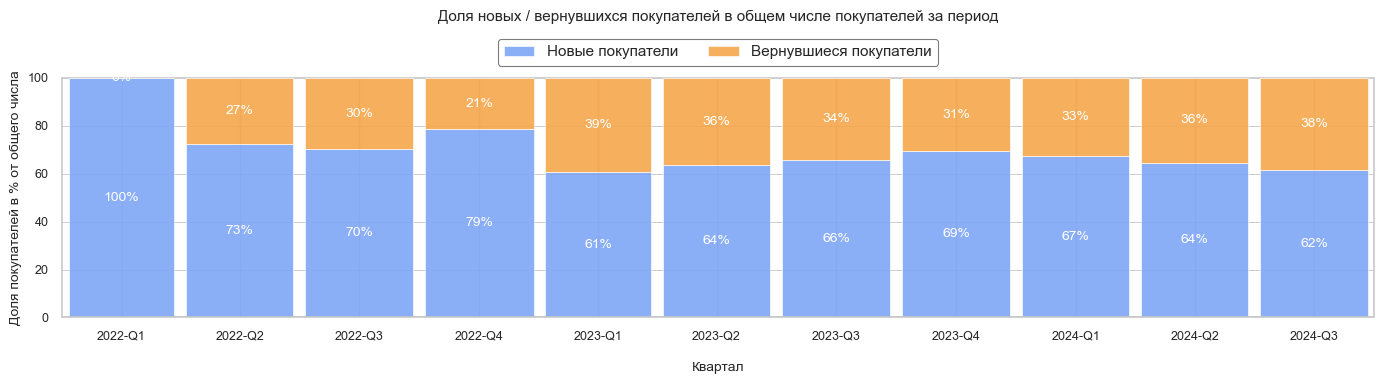

In [112]:
stacked_bars_by_period(df=key_metrics_q, x_col='purch_quarter', y_bottom_col='New_Cust_pct', y_top_col='Ret_Cust_pct',
                   title='Доля новых / вернувшихся покупателей в общем числе покупателей за период\n\n\n', x_label='\nКвартал',
                   y_label='Доля покупателей в % от общего числа', bottom_label='Новые покупатели', 
                       top_label='Вернувшиеся покупатели', freq='q')

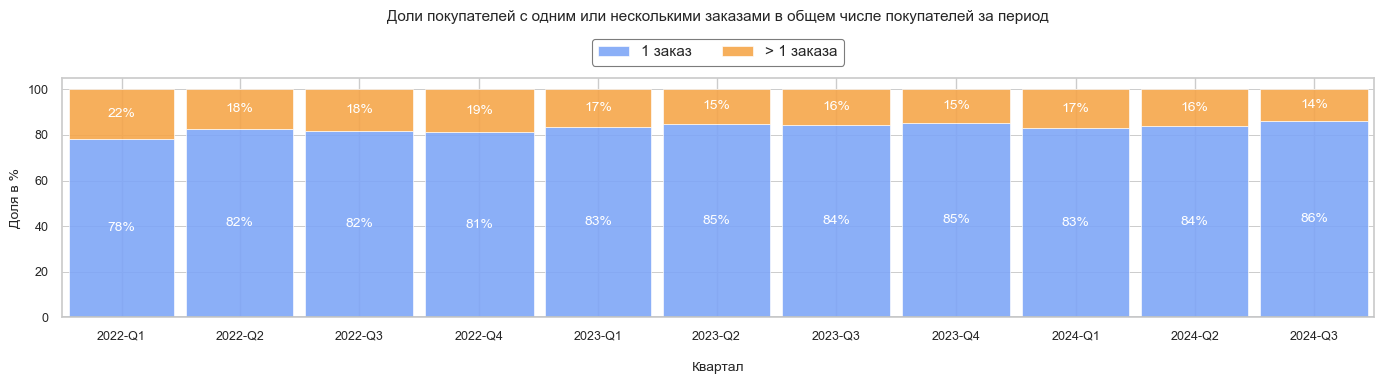

In [113]:
stacked_bars_by_period(df=key_metrics_q, x_col='purch_quarter', y_bottom_col='One_ord_cust_pct', y_top_col='Rep_ord_cust_pct',
                   title='Доли покупателей с одним или несколькими заказами в общем числе покупателей за период\n\n\n', x_label='\nКвартал',
                   y_label='Доля в %', bottom_label='1 заказ', top_label='> 1 заказа', freq='q')

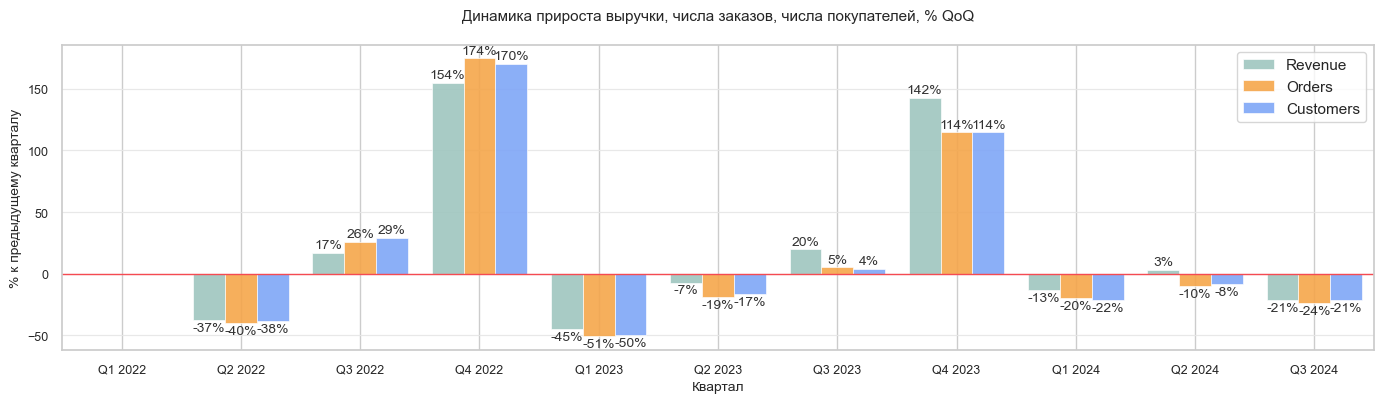

In [114]:
growth_bars_by_period(key_metrics_q, 'purch_quarter', y_cols=[('R_pct_chg','Revenue'), ('O_pct_chg','Orders'), ('C_pct_chg','Customers')],
                      freq='q', title='Динамика прироста выручки, числа заказов, числа покупателей, % QoQ\n',
                      x_label='Квартал', y_label='% к предыдущему кварталу', value_labels=True)

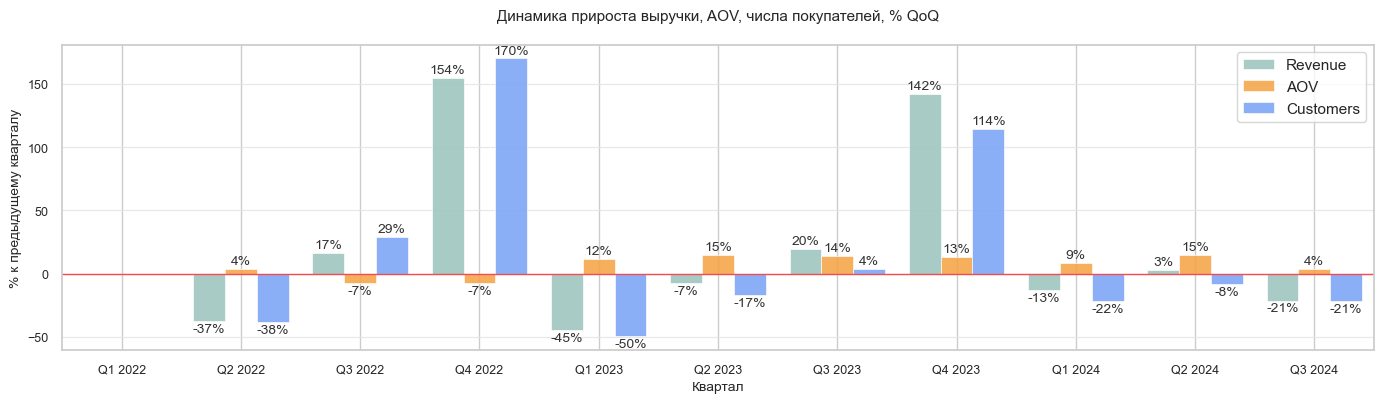

In [115]:
growth_bars_by_period(key_metrics_q, 'purch_quarter', y_cols=[('R_pct_chg','Revenue'), ('AOV_pct_chg','AOV'), ('C_pct_chg','Customers')],
                      freq='q', title='Динамика прироста выручки, AOV, числа покупателей, % QoQ\n',
                      x_label='Квартал', y_label='% к предыдущему кварталу', value_labels=True)

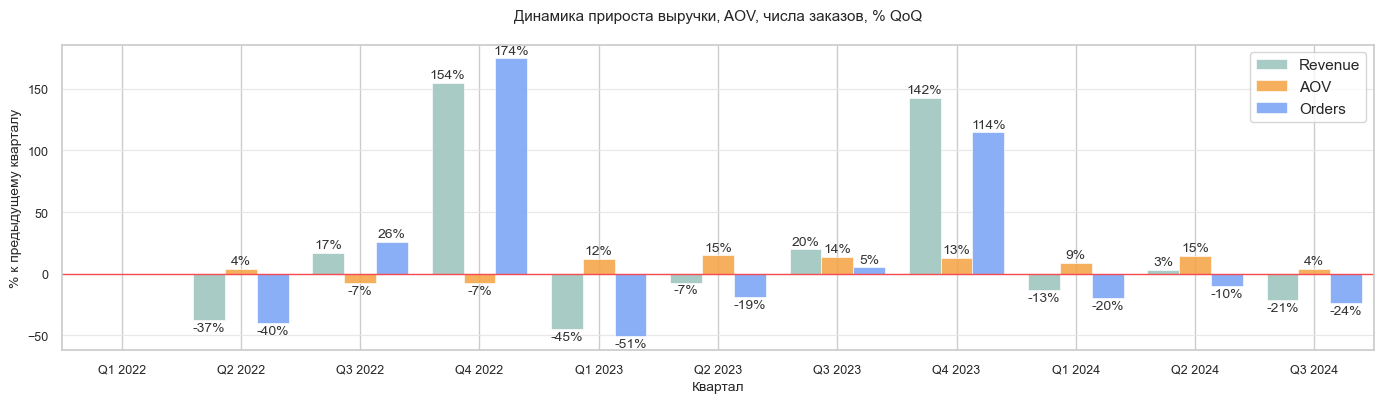

In [116]:
growth_bars_by_period(key_metrics_q, 'purch_quarter', y_cols=[('R_pct_chg','Revenue'), ('AOV_pct_chg','AOV'), ('O_pct_chg','Orders')],
                      freq='q', title='Динамика прироста выручки, AOV, числа заказов, % QoQ\n',
                      x_label='Квартал', y_label='% к предыдущему кварталу', value_labels=True)

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  2.4 Монетизация на пользователя и заказ и поведенческие метрики (AOV, ARPPU, APC, AUP, Stickiness ratio)
</div>

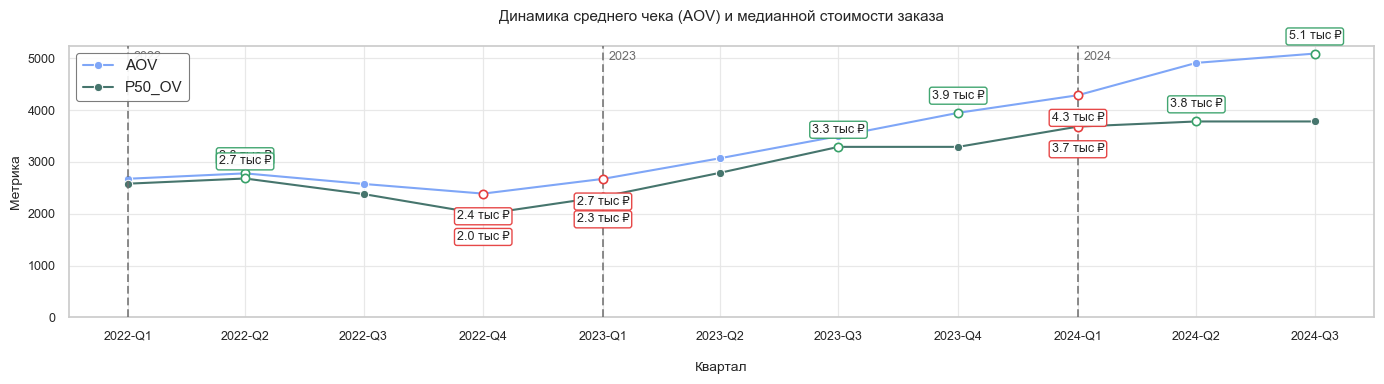

In [117]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','AOV','P50_OV']].melt(id_vars='purch_quarter',
                                                                                 value_vars=['AOV', 'P50_OV'],
                                                                                 var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value',  value_type='money', hue_col='metric', freq='q',
                   x_label="\nКвартал", y_label="Метрика", title="Динамика среднего чека (AOV) и медианной стоимости заказа\n")

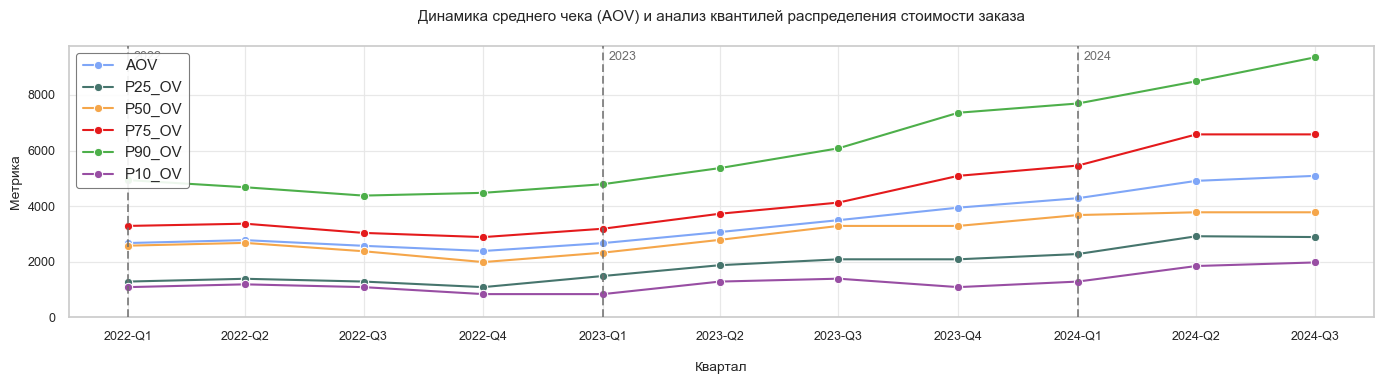

In [118]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','AOV','P10_OV','P25_OV','P50_OV','P75_OV','P90_OV']] \
                   .melt(id_vars='purch_quarter', value_vars=['AOV','P10_OV','P25_OV','P50_OV','P75_OV','P90_OV'],
                    var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value',  value_type='money', hue_col='metric', freq='q',
                   x_label="\nКвартал", y_label="Метрика", title="Динамика среднего чека (AOV) и анализ квантилей распределения стоимости заказа\n")

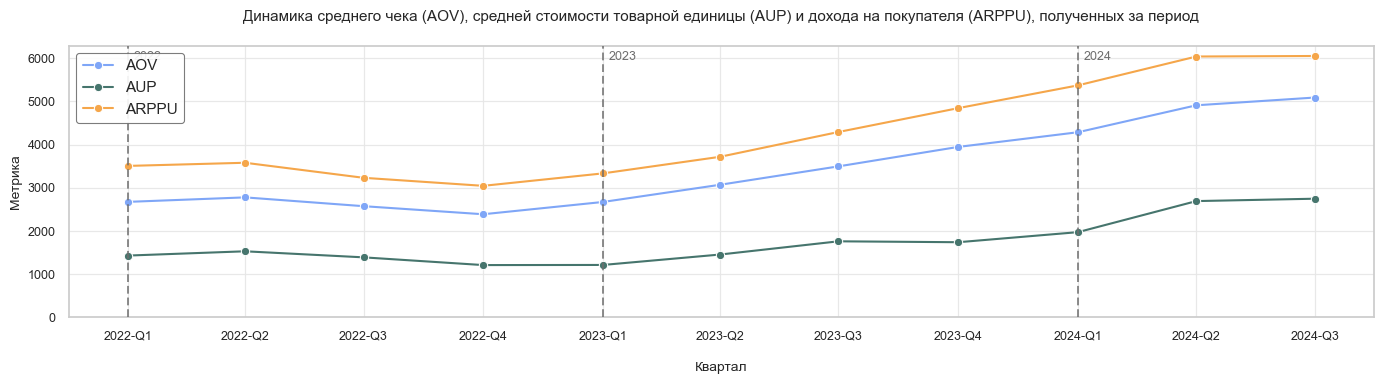

In [119]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','AOV','ARPPU', 'AUP']].melt(id_vars='purch_quarter',
                                                                                 value_vars=['AOV', 'ARPPU', 'AUP'],
                                                                                 var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value',  value_type='money', hue_col='metric', freq='q',
                   x_label="\nКвартал", y_label="Метрика", title="Динамика среднего чека (AOV), средней стоимости товарной единицы (AUP) и дохода на покупателя (ARPPU), полученных за период\n")

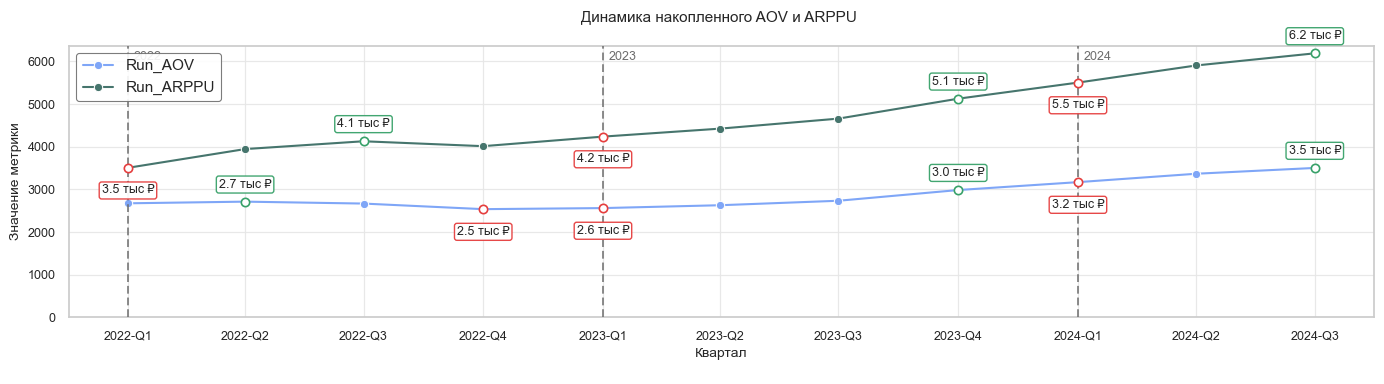

In [120]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','Run_AOV','Run_ARPPU']].melt(id_vars='purch_quarter', value_vars=['Run_AOV', 'Run_ARPPU'],
                                                                        var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value',  value_type='money', hue_col='metric', freq='q',
                   x_label="Квартал\n", y_label="Значение метрики", title="Динамика накопленного AOV и ARPPU \n")

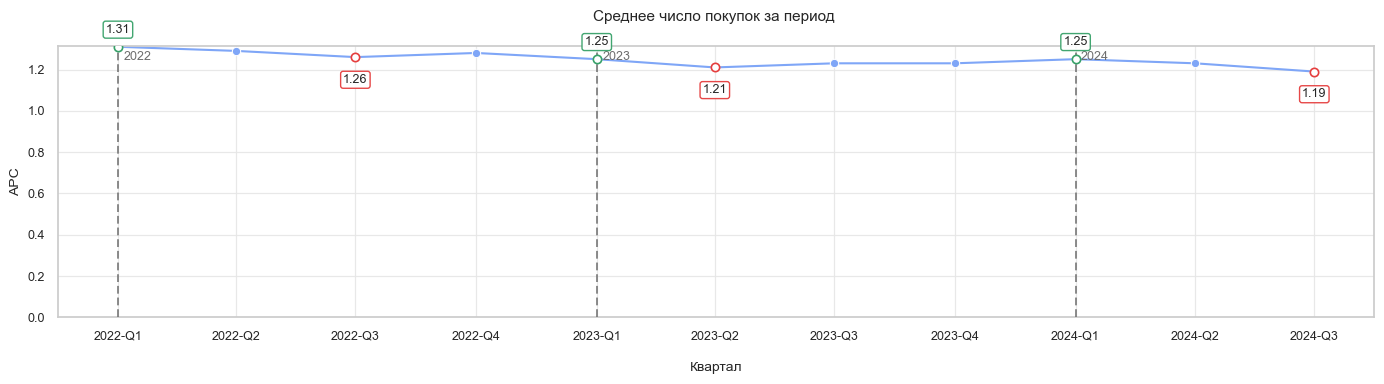

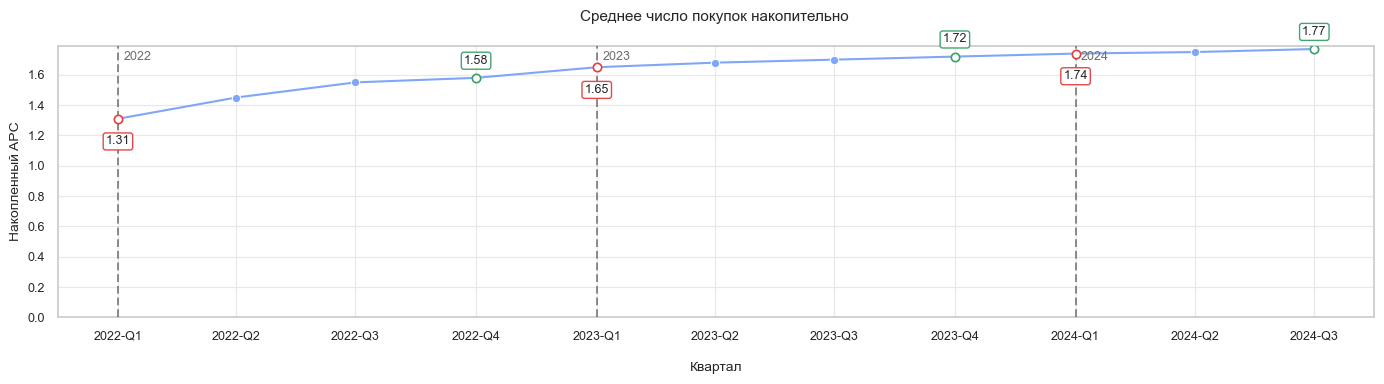

In [121]:
lineplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='APC', freq='q',
                  y_label="APC", title="Среднее число покупок за период \n", value_type='apc')
lineplot_by_period(df=key_metrics_q, x_col='purch_quarter', y_col='Run_APC', freq='q',
                  y_label="Накопленный APC", title="Среднее число покупок накопительно \n", value_type='apc')

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  2.5 Сравнение ARPPU, AOV, APC, AUP, UPT по новым / вернувшимся покупателям
</div>

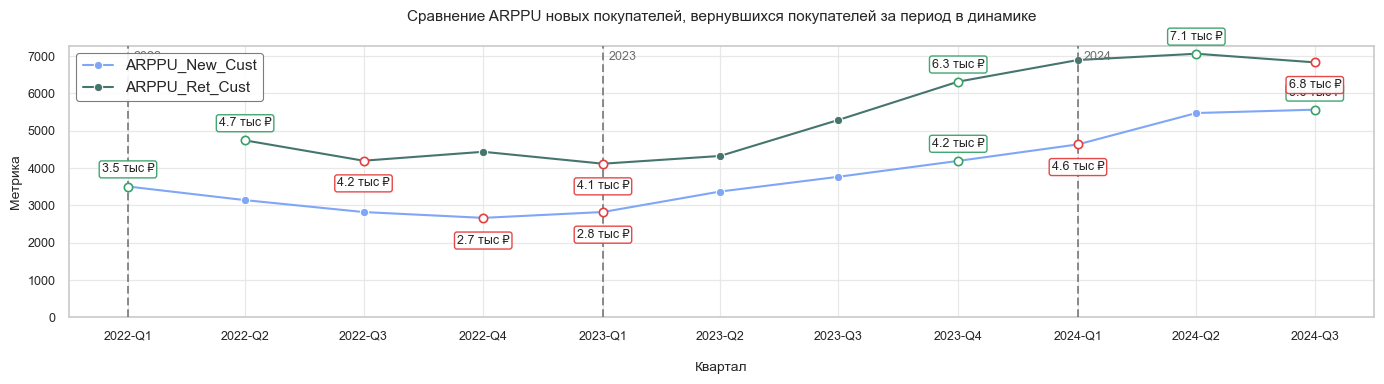

In [122]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','ARPPU_New_Cust','ARPPU_Ret_Cust']].melt(id_vars='purch_quarter',
                                                                                        value_vars=['ARPPU_New_Cust', 'ARPPU_Ret_Cust'], 
                                                                                        var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value',  value_type='money', hue_col='metric', freq='q',
                   y_label="Метрика", title="Сравнение ARPPU новых покупателей, вернувшихся покупателей за период в динамике\n")

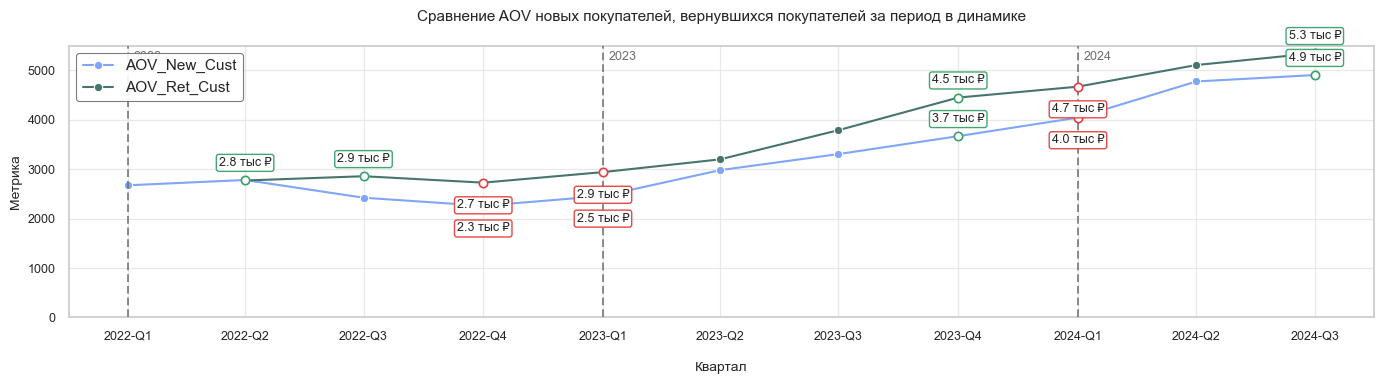

In [123]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','AOV_New_Cust','AOV_Ret_Cust']].melt(id_vars='purch_quarter',
value_vars=['AOV_New_Cust', 'AOV_Ret_Cust'], var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value',  value_type='money', hue_col='metric', freq='q',
                   y_label="Метрика", title="Сравнение AOV новых покупателей, вернувшихся покупателей за период в динамике\n")

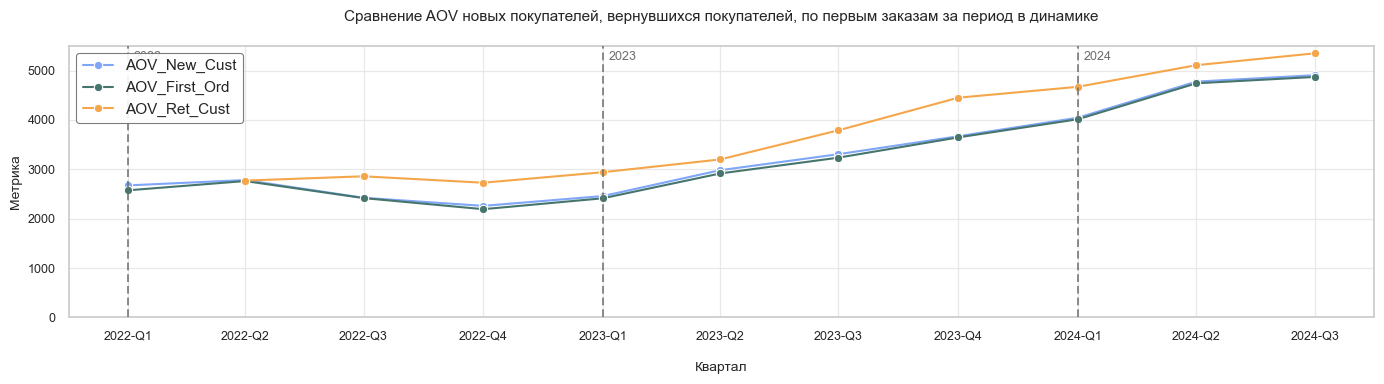

In [124]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','AOV_New_Cust','AOV_Ret_Cust','AOV_First_Ord']].melt(id_vars='purch_quarter',
value_vars=['AOV_New_Cust', 'AOV_Ret_Cust', 'AOV_First_Ord'], var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value',  value_type='money', hue_col='metric', freq='q',
                   y_label="Метрика", title="Сравнение AOV новых покупателей, вернувшихся покупателей, по первым заказам за период в динамике\n")

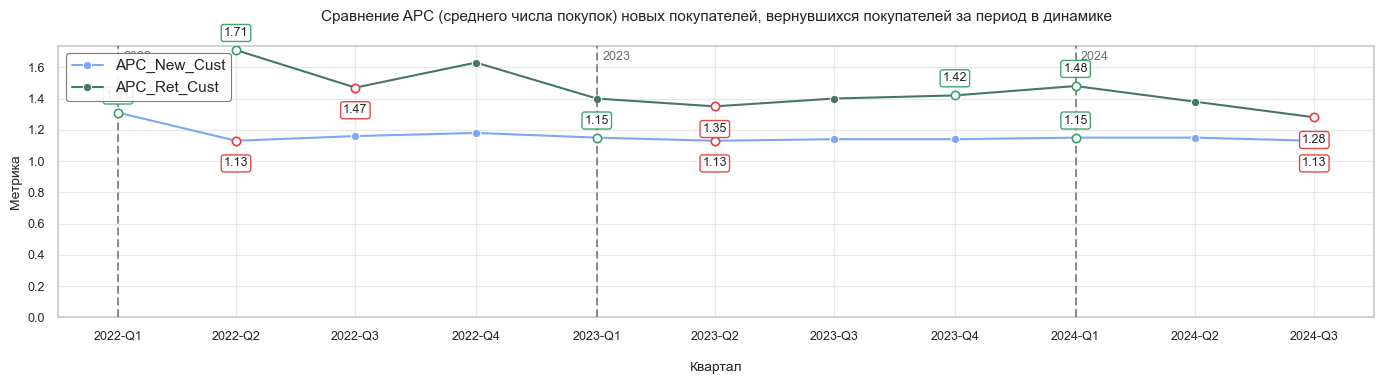

In [125]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','APC_New_Cust','APC_Ret_Cust']].melt(id_vars='purch_quarter',
value_vars=['APC_New_Cust', 'APC_Ret_Cust'], var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value',  value_type='apc', hue_col='metric', freq='q',
                   y_label="Метрика", title="Сравнение APC (среднего числа покупок) новых покупателей, вернувшихся покупателей за период в динамике\n")

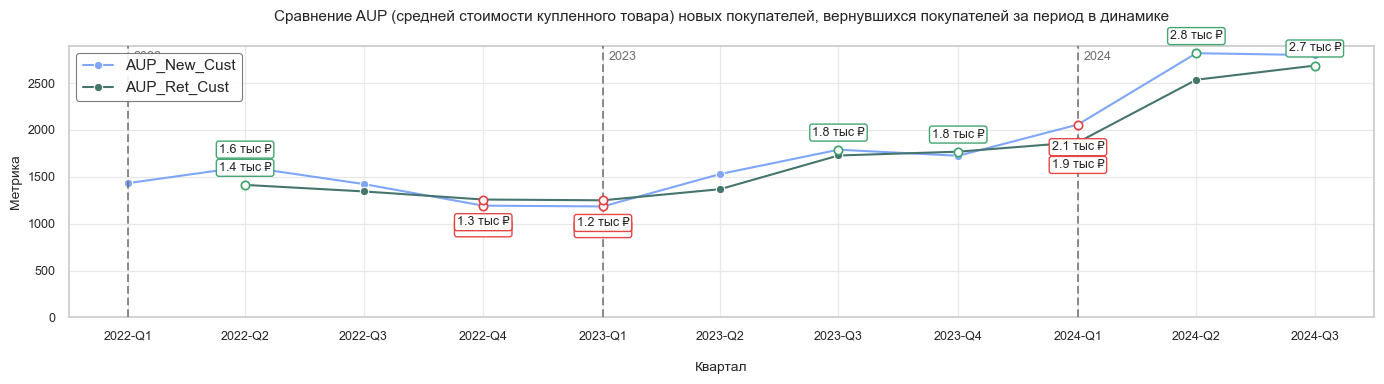

In [126]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','AUP_New_Cust','AUP_Ret_Cust']].melt(id_vars='purch_quarter',
value_vars=['AUP_New_Cust', 'AUP_Ret_Cust'], var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value',  value_type='money', hue_col='metric', freq='q',
                   y_label="Метрика", title="Сравнение AUP (средней стоимости купленного товара) новых покупателей, вернувшихся покупателей за период в динамике\n")

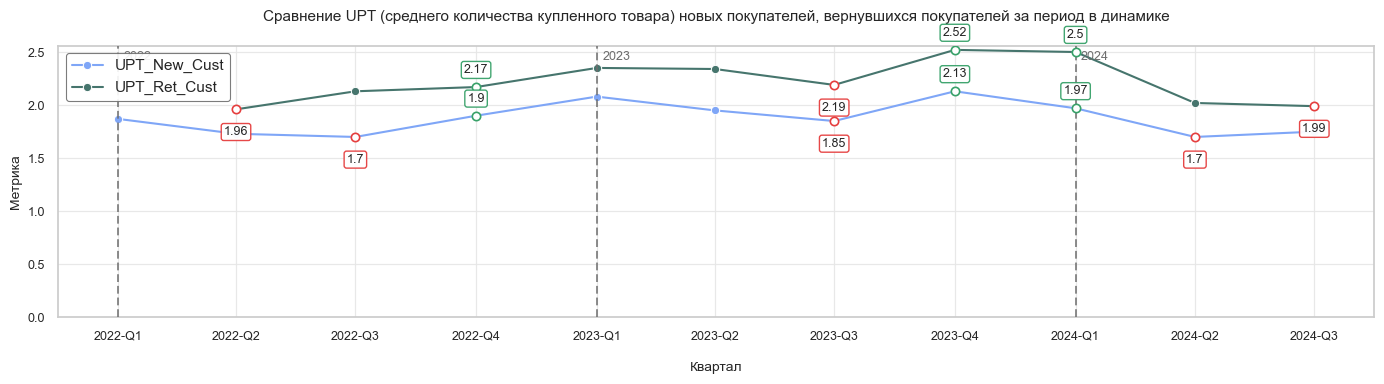

In [127]:
lineplot_by_period(df=key_metrics_q[['purch_quarter','UPT_New_Cust','UPT_Ret_Cust']].melt(id_vars='purch_quarter',
value_vars=['UPT_New_Cust', 'UPT_Ret_Cust'], var_name='metric', value_name='value'), 
                   x_col='purch_quarter', y_col='value',  value_type='apc', hue_col='metric', freq='q',
                   y_label="Метрика", title="Сравнение UPT (среднего количества купленного товара) новых покупателей, вернувшихся покупателей за период в динамике\n")

<div 
style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.8em 0; padding:1em 1.2em; background:#ebf1ee; border:1px solid #48735a; border-radius:8px; line-height:1.5;">

##### 🌿 Аналитические выводы: динамика ключевых метрик по кварталам  
__________________

##### **1. Выручка и сезонность**
- Квартальная выручка демонстрирует выраженную сезонность: в Q4 ежегодный пик, в Q1 наблюдается спад после высокого спроса.  
- В 2024 г. спад после высокого сезона минимален: выручка стабилизировалась на новом уровне >11 млн ₽ за квартал (Q3 2024 выглядит слабее только потому, что квартал неполный).
- За период 2022-2024 гг. выручка выросла кратно: каждый следующий год приносит больше денег, и это устойчивый тренд. 
- Q4 даёт почти половину годовой выручки (44% в 2022 г., 47% в 2023 г.).  
- С Q2 2023 доля выручки от вернувшихся покупателей стабилизировалась на уровне 40-43% от ежеквартальной выручки, 57-60% от ежеквартальной выручки приносят новые покупатели.

##### **2. Заказы и операционная эффективность**
- Число заказов следует тому же сезонному паттерну: пик в Q4, откат в Q1, в 2024 г. спад после высокого спроса минимальный (Q3 2024 неполный).
- Темпы прироста заказов в 2023-2024 гг. немного ниже темпов прироста выручки, но направление изменений практически всегда совпадает.  
- В 2023-2024 гг базовый уровень заказов стал выше: внесезонные кварталы значительно сильнее год от года.
- Более 40% годового числа заказов дает Q4 (в 2022 г. 47%, в 2023 г. 41%). 
- Cancel rate держится стабильно в диапазоне 2-4% без ухудшения качества операций.  
- Доля заказов вернувшихся покупателей стабилизировалась на уровне 35-40% от ежеквартального числа, 60-65% заказов делают новые покупатели.

##### **3. Покупатели**
- Число покупателей (как в общем, так и новых) подчиняется той же сезонной логике: рост в Q4, откат в Q1 (в Q1 2024 г. откат минимальный, Q3 2024 неполный).  
- Новые дают примерно 2/3 квартальной базы, возвращающиеся 1/3.  
- Более 40% от числа новых уникальных покупателей, привлеченных за год, приходится на Q4 (в 2022 г. 46%, в 2023 г. 43%)
- 15-17% покупателей делают более одного заказа в квартал, 83-85% только один заказ

##### **4. Монетизация и пользовательская активность**
- ARPPU растёт практически в 2 раза: на конец наблюдений закрепляется на отметке около 6 тыс ₽ на покупателя.
- То же самое с AOV: на конец наблюдений составляет около 5 тыс ₽ на заказ.
- Анализ квантилей распределения стоимости заказов показывает, что стоимость заказа повышается не только за счёт редких дорогих заказов, растет также и стоимость типичного заказа.   
- AUP также растёт => вклад товарной политики и улучшения ассортимента подтверждается. 
- Среднее число покупок за квартал остается практически без изменений (есть небольшой спад относительно начала наблюдений), при этом в 2022 г. квартальные показатели колеблются на уровне 1,26-1,31 покупок на пользователя в квартал, а в 2023-2024 1,21-1,25.
- Накопительная частота покупок = 1,77 => средний клиент делает меньше двух заказов за весь жизненный цикл => значительный потенциал LTV в удержании.

##### **5. Монетизация новых и возвращающихся покупателей**
- ARPPU вернувшихся покупателей стабильно выше ARPPU новых во всех кварталах без исключений.
- Растет AOV как вернувшихся покупателей, так и новых, но у новых всегда остаётся ниже, чем у вернувшихся.
- Поведенческая разница очевидна:  
  - Частота покупок (APC) у новых стабильно низкая и практически неизменна: 1,13-1,15 заказов на покупателя в квартал.  
  - APC возвращающихся выше: 1,35-1,48  заказов на покупателя в квартал.
- По средней цене товара в заказе (AUP) наблюдается минимальный разрыв в большинстве кварталов в пользу новых покупателей (чуть более выраженный в 2024 г., но в целом AUP практически идентичен), но при этом вернувшиеся покупатели лидируют по количеству товаров в заказе
  - UPT 2-2,5 товара в заказе при ежеквартальном расчете у вернувшихся против 1,7-2,1 у новых.

##### **Итоговая интерпретация**
- Основной драйвер масштабирования — новые покупатели.    
- Основной драйвер монетизации —  возвращающиеся покупатели: делают больше заказов, покупают больше товаров и приносят больше денег.  
- Разрыв в пользу returning-аудитории усиливается => удержание становится ключевой точкой роста LTV.  
- Огромный потенциал заложен в увеличении частоты покупок: сейчас средний клиент делает менее двух заказов за весь жизненный цикл.  
- Бизнес растёт за счёт привлечения, ассортиментной политики и роста среднего чека; следующий шаг — системная работа с ретеншеном.

</div>


<div style="background:#3b5e4a; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  3. Сравнение ключевых метрик год к году и декомпозиция выручки
</div>

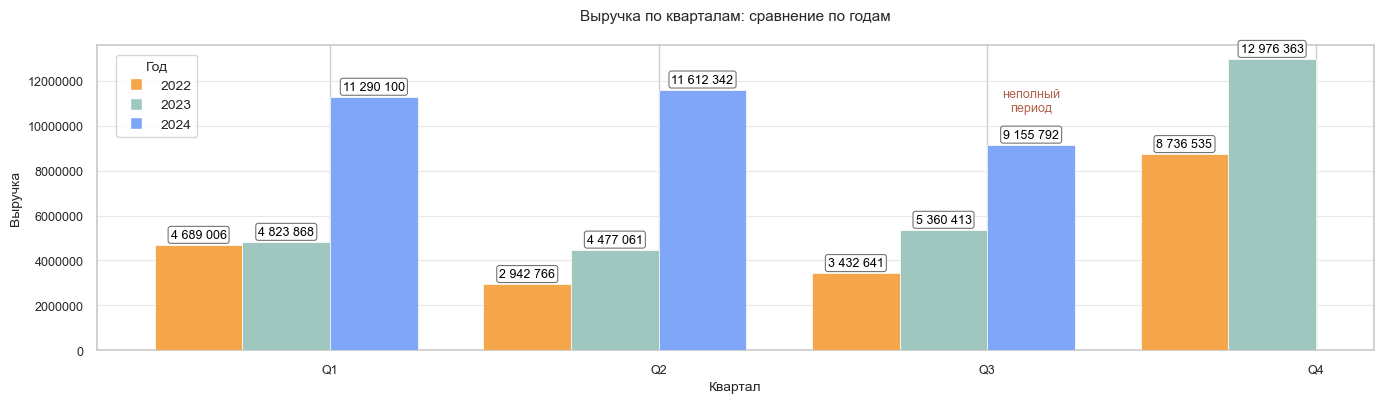

In [128]:
barplot_yoy_quarters(df_q=key_metrics_q, period_col='purch_quarter', y_col='Revenue',
                     y_label='Выручка', title="Выручка по кварталам: сравнение по годам\n")

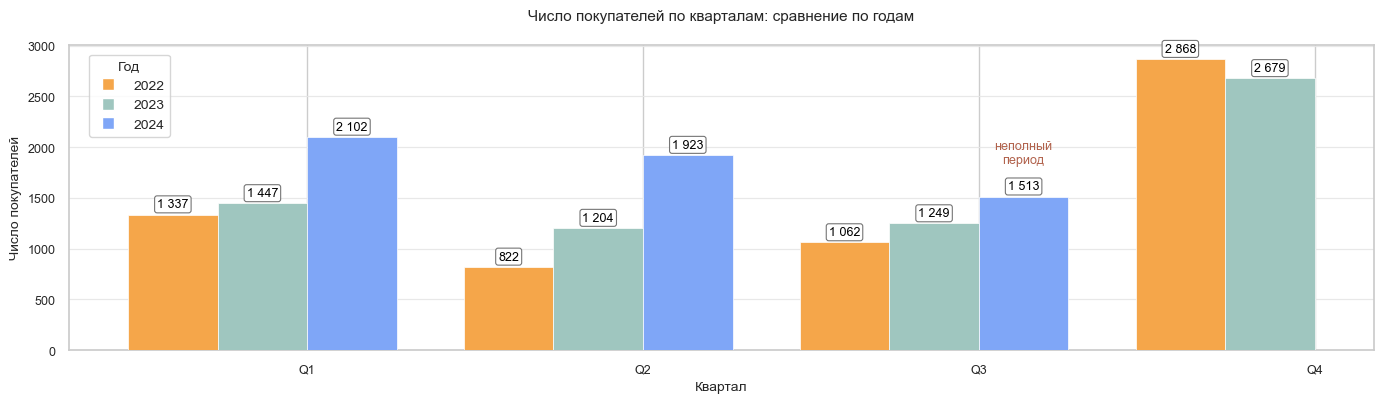

In [129]:
barplot_yoy_quarters(df_q=key_metrics_q, period_col='purch_quarter', y_col='Customers',
    title='Число покупателей по кварталам: сравнение по годам\n', y_label='Число покупателей')

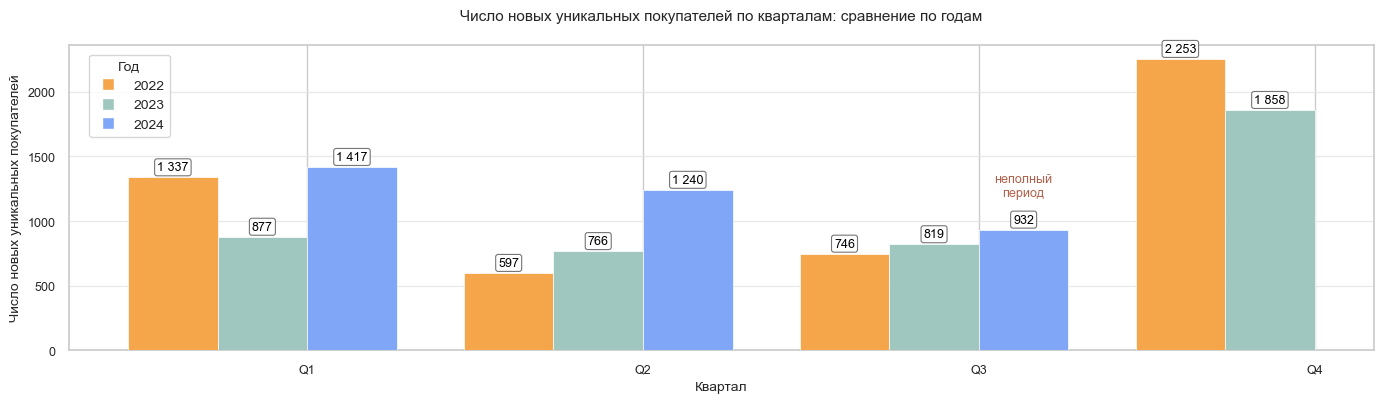

In [130]:
barplot_yoy_quarters(df_q=key_metrics_q, period_col='purch_quarter', y_col='New_Cust',
    title='Число новых уникальных покупателей по кварталам: сравнение по годам\n', y_label='Число новых уникальных покупателей')

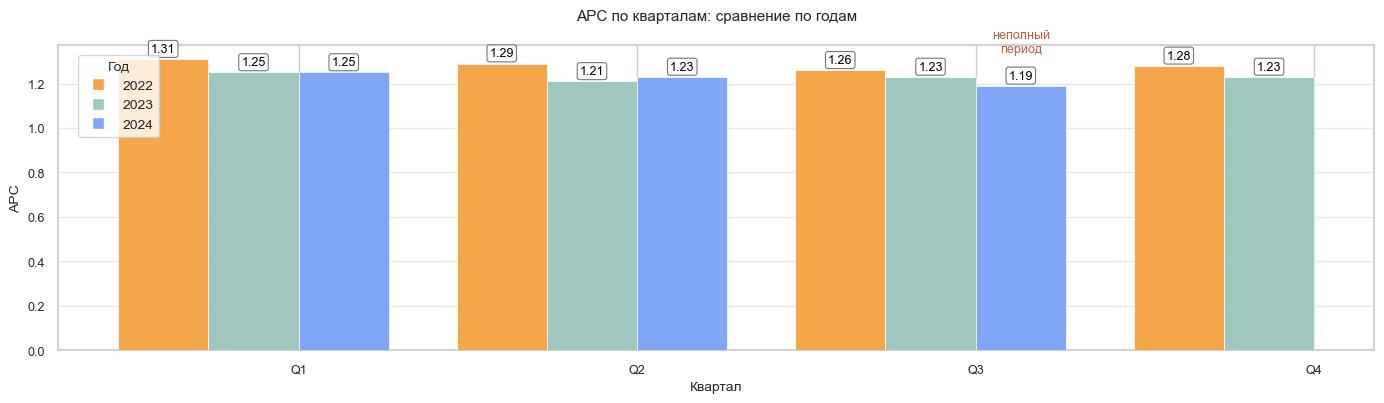

In [131]:
barplot_yoy_quarters(df_q=key_metrics_q, period_col='purch_quarter', y_col='APC', apc_metric=True,
    title='APC по кварталам: сравнение по годам\n', y_label='APC')

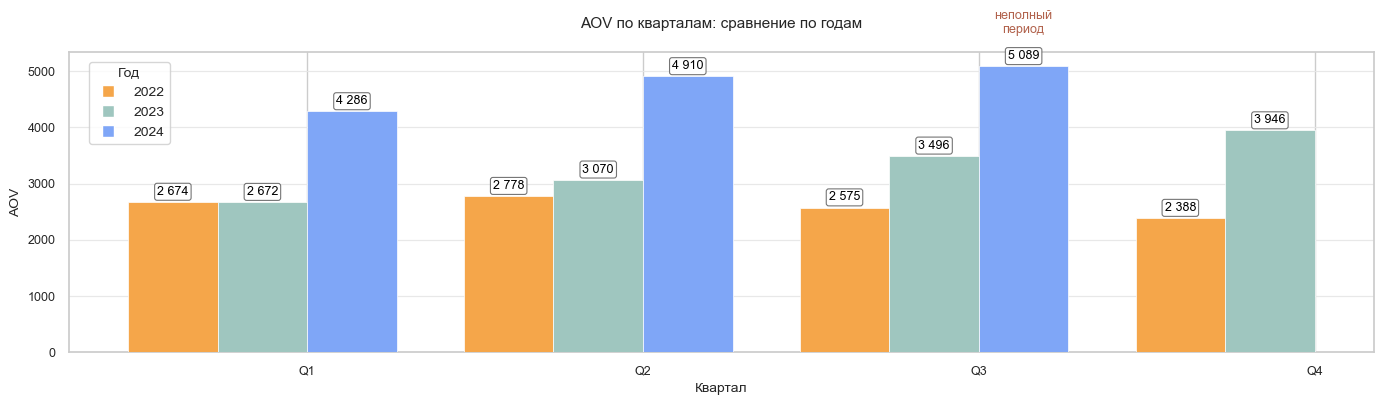

In [132]:
barplot_yoy_quarters(df_q=key_metrics_q, period_col='purch_quarter', y_col='AOV',
    title='AOV по кварталам: сравнение по годам\n', y_label='AOV')

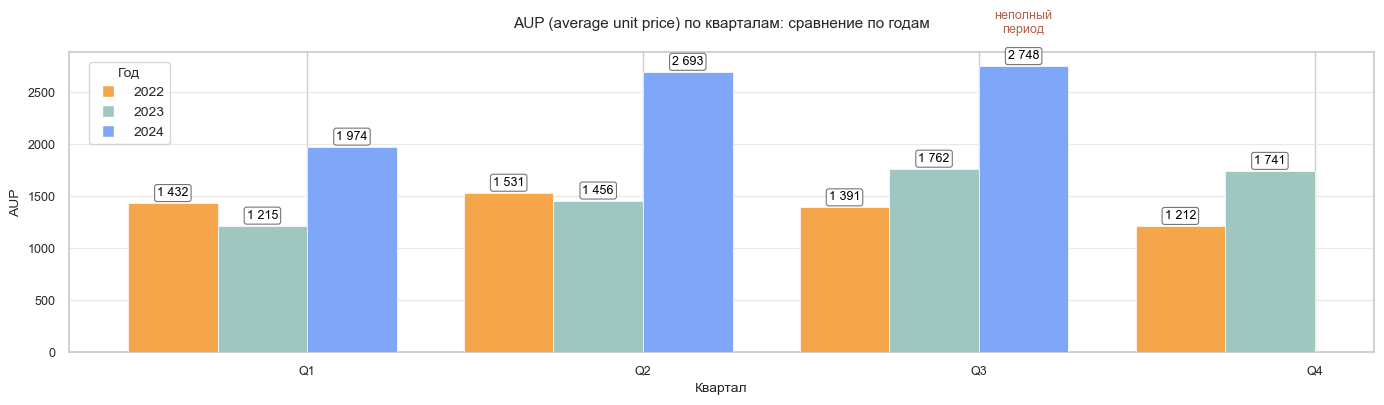

In [133]:
barplot_yoy_quarters(df_q=key_metrics_q, period_col='purch_quarter', y_col='AUP',
    title='AUP (average unit price) по кварталам: сравнение по годам\n', y_label='AUP')

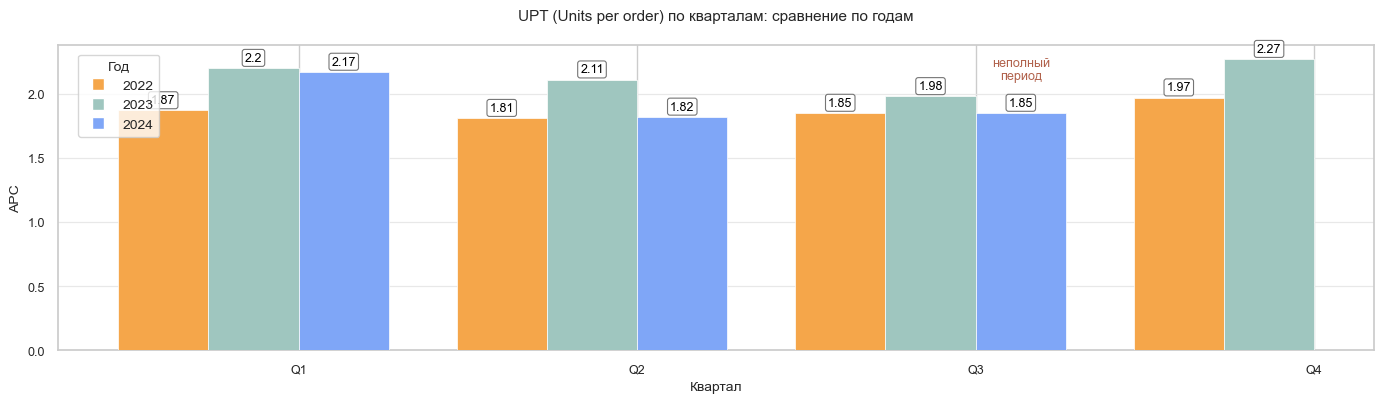

In [134]:
barplot_yoy_quarters(df_q=key_metrics_q, period_col='purch_quarter', y_col='UPT', apc_metric=True,
    title='UPT (Units per order) по кварталам: сравнение по годам\n', y_label='APC')

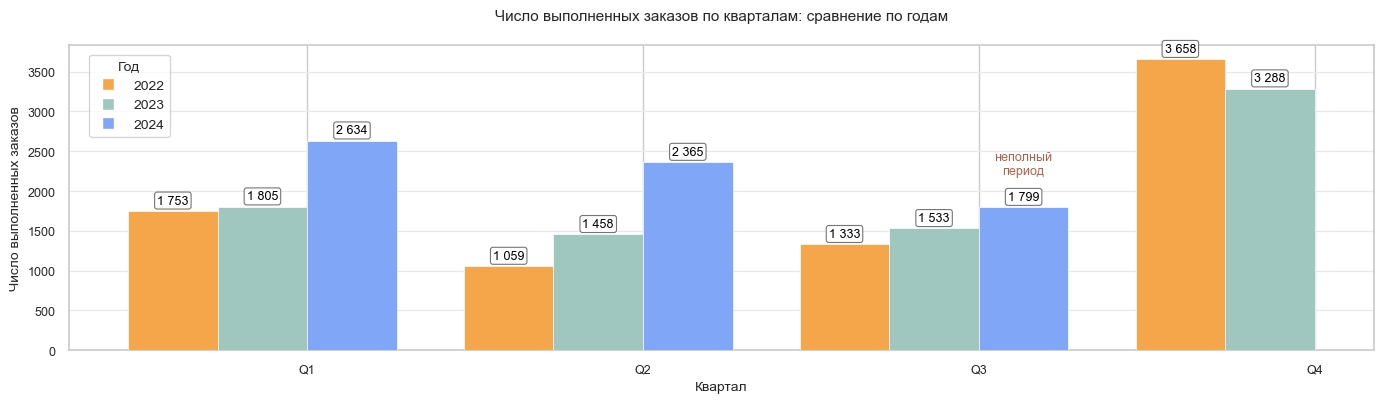

In [135]:
barplot_yoy_quarters(df_q=key_metrics_q, period_col='purch_quarter', y_col='Orders',
    title='Число выполненных заказов по кварталам: сравнение по годам\n', y_label='Число выполненных заказов')

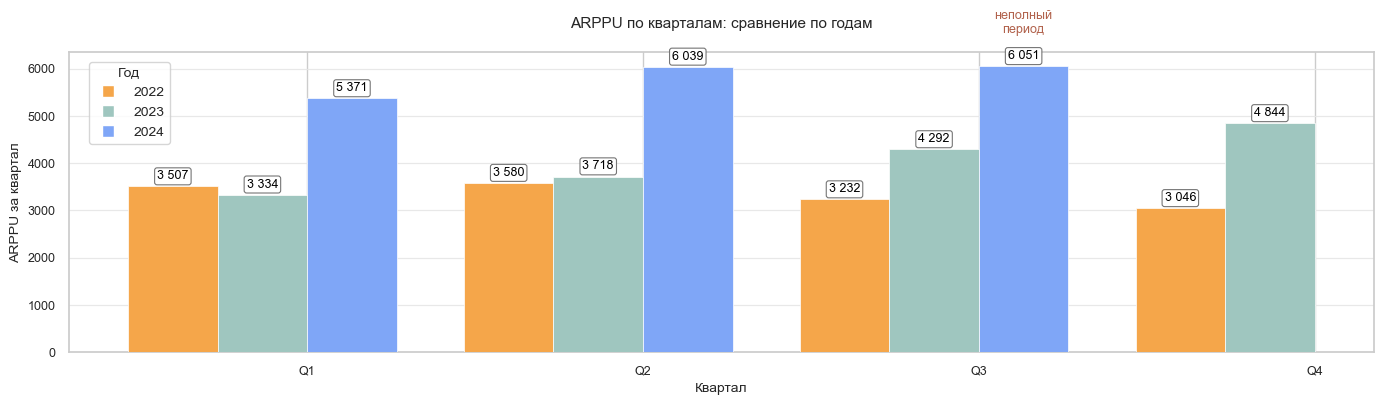

In [136]:
barplot_yoy_quarters(df_q=key_metrics_q, period_col='purch_quarter', y_col='ARPPU',
    title='ARPPU по кварталам: сравнение по годам\n', y_label='ARPPU за квартал')

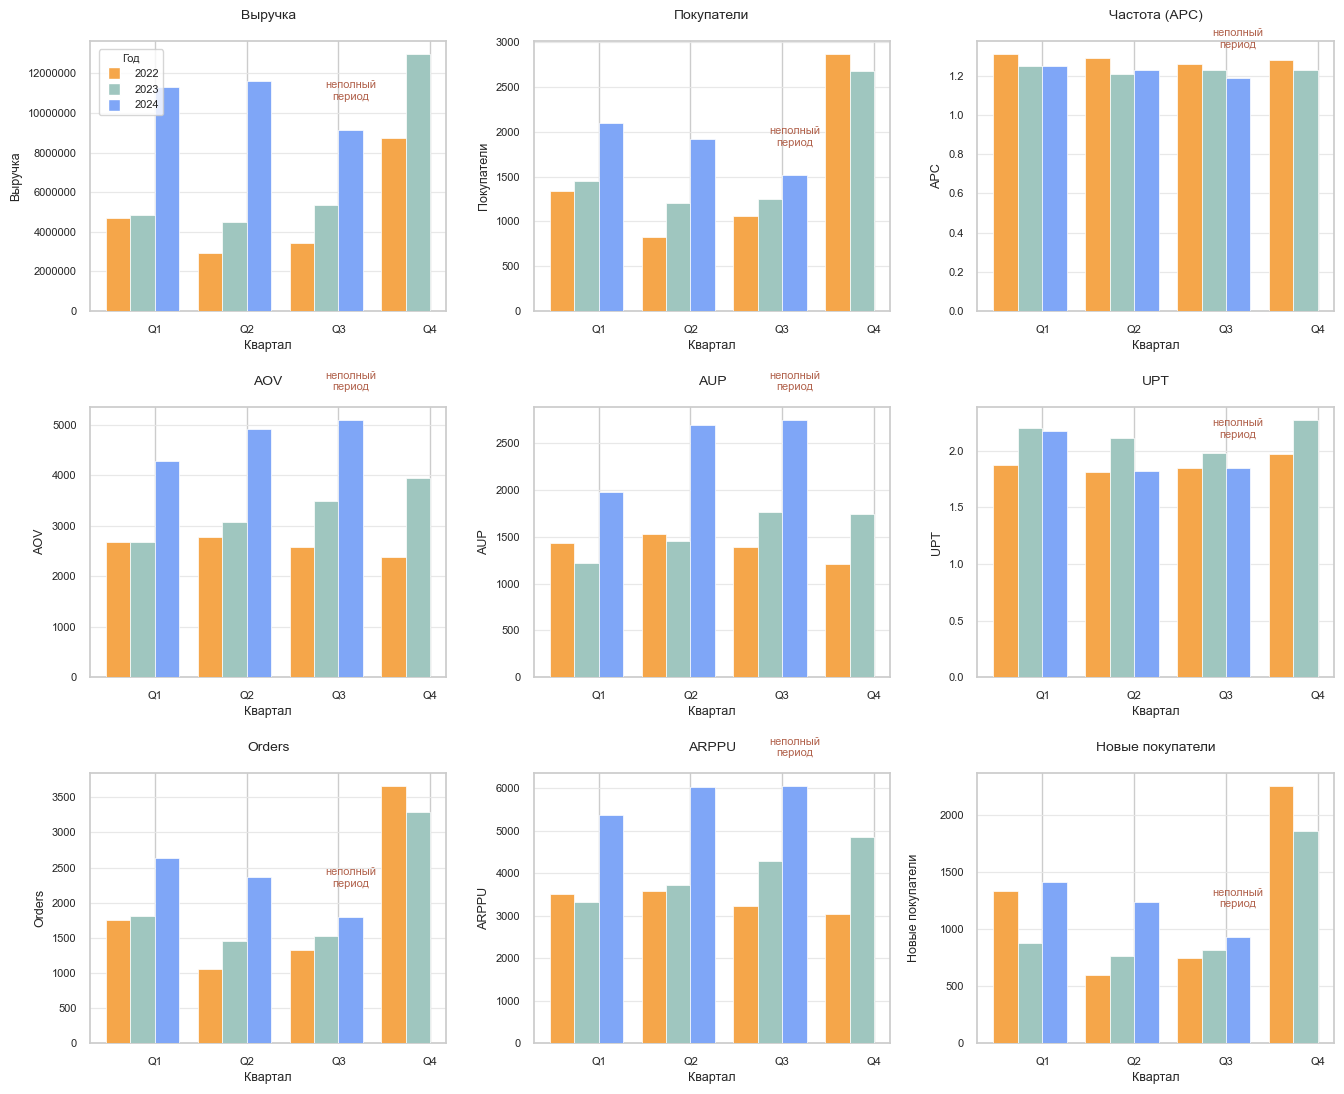

In [137]:
# Общая картина: декомпозиция выручки
barplot_yoy_quarters_grid(
    df_q=key_metrics_q,
    period_col='purch_quarter',
    y_cols=['Revenue', 'Customers', 'APC', 'AOV', 'AUP', 'UPT', 'Orders', 'ARPPU', 'New_Cust'],
    titles=['Выручка\n', 'Покупатели\n', 'Частота (APC)\n', 'AOV\n', 'AUP\n', 'UPT\n', 'Orders\n', 'ARPPU\n', 'Новые покупатели\n'],
    y_labels=['Выручка', 'Покупатели', 'APC', 'AOV', 'AUP', 'UPT', 'Orders', 'ARPPU', 'Новые покупатели\n'],
    apc_metrics=[False, False, True, False, False, True, False, False, False])

In [138]:
# Выведем также ключевые метрики по годам
# Прим.: данные за 2024 год неполные (не включают период высокого сезона сентябрь - декабрь)
successful_orders.groupby('purch_year', as_index=False) \
               .agg(Revenue   = ('rev', 'sum'), 
                    Orders    = ('order_id', 'nunique'),
                    Customers = ('customer_id', 'nunique'),
                    Units     = ('cnt', 'sum')) \
               .assign(ARPPU  = lambda d: (d['Revenue'] / d['Customers']).round(),
                       AOV    = lambda d: (d['Revenue'] / d['Orders']),        
                       APC    = lambda d: (d['Orders']  / d['Customers']).round(2),                           
                       AUP    = lambda d: (d['Revenue'] / d['Units']).round(),
                       UPT    = lambda d: (d['Units']  / d['Orders']).round(2)) 

purch_year   Revenue  Orders  Customers  Units   ARPPU          AOV   APC  \
0        2022  19800948    7803       4933  14872  4014.0  2537.607074  1.58   
1        2023  27637705    8084       5481  17539  5042.0  3418.815562  1.47   
2        2024  32058234    6798       4732  13364  6775.0  4715.833186  1.44   

      AUP   UPT  
0  1331.0  1.91  
1  1576.0  2.17  
2  2399.0  1.97

In [139]:
# Сохраним в отдельный датафрейм все заказы и их cтоимость
order_value = successful_orders.groupby(['purch_year', 'order_id'], as_index=False) \
                               .agg(Ord_value = ('rev', 'sum'),
                                    UPT       = ('cnt','sum')) \
                               .assign(AUP = lambda df: df['Ord_value'] / df['UPT'])
order_value['UPT_group'] = order_value['UPT'].apply(lambda x: "1" if x == 1 else ("2" if x == 2 else ("3" if x == 3 else "4+")))
order_value.head()

purch_year      order_id  Ord_value  UPT     AUP UPT_group
0        2022  OA1000000001       1418    2   709.0         2
1        2022  OA1000000027        659    1   659.0         1
2        2022  OA1000000079       2180    2  1090.0         2
3        2022  OA1000000105       1290    1  1290.0         1
4        2022  OA1000000235       2180    2  1090.0         2

In [140]:
# Посчитаем по годам, сколько заказов состояли из 1, 2, 3, 4+ товаров
upt_dist = order_value.groupby(['purch_year', 'UPT_group']).agg(orders=('order_id', 'count')).reset_index() 
upt_dist['year_total'] = upt_dist.groupby('purch_year')['orders'].transform('sum')
upt_dist['pct'] = (upt_dist['orders'] / upt_dist['year_total'] * 100).round(2)
upt_dist

purch_year UPT_group  orders  year_total    pct
0         2022         1    3625        7803  46.46
1         2022         2    2523        7803  32.33
2         2022         3    1049        7803  13.44
3         2022        4+     606        7803   7.77
4         2023         1    3132        8084  38.74
5         2023         2    2535        8084  31.36
6         2023         3    1395        8084  17.26
7         2023        4+    1022        8084  12.64
8         2024         1    3171        6798  46.65
9         2024         2    1992        6798  29.30
10        2024         3     939        6798  13.81
11        2024        4+     696        6798  10.24

In [141]:
# Сохраним в отдельный датафрейм количество заказов, сделанных пользователями
apc = successful_orders.groupby(['purch_year', 'customer_id'], as_index=False) \
                       .agg(APC = ('order_id','nunique'))
apc['APC_group'] = apc['APC'].apply(lambda x: "1" if x == 1 else ("2" if x == 2 else ("3" if x == 3 else "4+")))
apc.head()

purch_year customer_id  APC APC_group
0        2022   ФЛ0001276    1         1
1        2022   ФЛ0001538    1         1
2        2022   ФЛ0002707    3         3
3        2022   ФЛ0003533    3         3
4        2022   ФЛ0007247    3         3

In [142]:
# Посчитаем по годам, сколько покупателей делали 1, 2, 3, 4+ заказов
apc_dist = apc.groupby(['purch_year', 'APC_group']).agg(customers=('customer_id', 'count')).reset_index()
apc_dist['year_total'] = apc_dist.groupby('purch_year')['customers'].transform('sum')
apc_dist['pct'] = (apc_dist['customers'] / apc_dist['year_total'] * 100).round(2)
apc_dist

purch_year APC_group  customers  year_total    pct
0         2022         1       3578        4933  72.53
1         2022         2        746        4933  15.12
2         2022         3        288        4933   5.84
3         2022        4+        321        4933   6.51
4         2023         1       4210        5481  76.81
5         2023         2        752        5481  13.72
6         2023         3        259        5481   4.73
7         2023        4+        260        5481   4.74
8         2024         1       3666        4732  77.47
9         2024         2        636        4732  13.44
10        2024         3        201        4732   4.25
11        2024        4+        229        4732   4.84

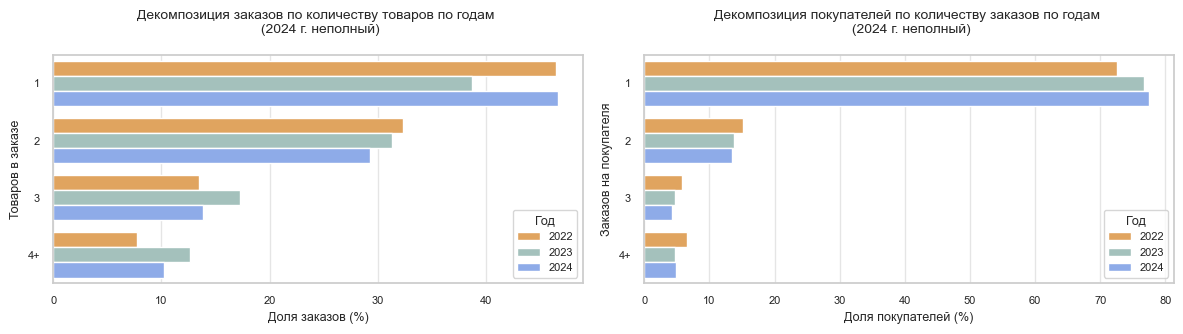

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
barplot_discrete_unit(data=upt_dist, x='pct', y='UPT_group', hue='purch_year', 
                      title="Декомпозиция заказов по количеству товаров по годам \n (2024 г. неполный)\n",
                      xlabel="Доля заказов (%)", ylabel="Товаров в заказе", ax=axes[0]) 
barplot_discrete_unit(data=apc_dist, x='pct', y='APC_group', hue='purch_year',
                      title="Декомпозиция покупателей по количеству заказов по годам \n (2024 г. неполный)\n",
                      xlabel="Доля покупателей (%)", ylabel="Заказов на покупателя", ax=axes[1])
plt.tight_layout()

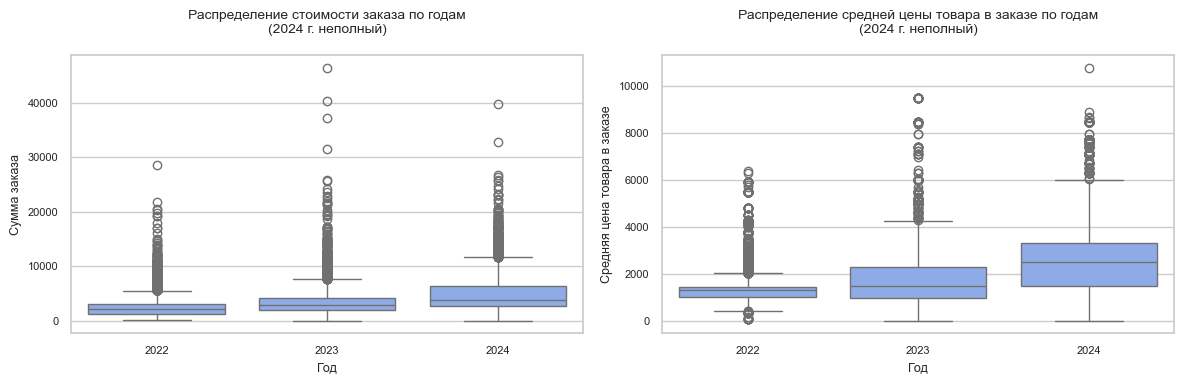

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
boxplot_money(data=order_value, x='purch_year', y='Ord_value', title="Распределение стоимости заказа по годам\n(2024 г. неполный)\n",
              xlabel="Год", ylabel="Сумма заказа", ax=axes[0]) 
boxplot_money(data=order_value, x='purch_year', y='AUP', title="Распределение средней цены товара в заказе по годам\n(2024 г. неполный)\n",
               xlabel="Год", ylabel="Средняя цена товара в заказе", ax=axes[1])
plt.tight_layout()

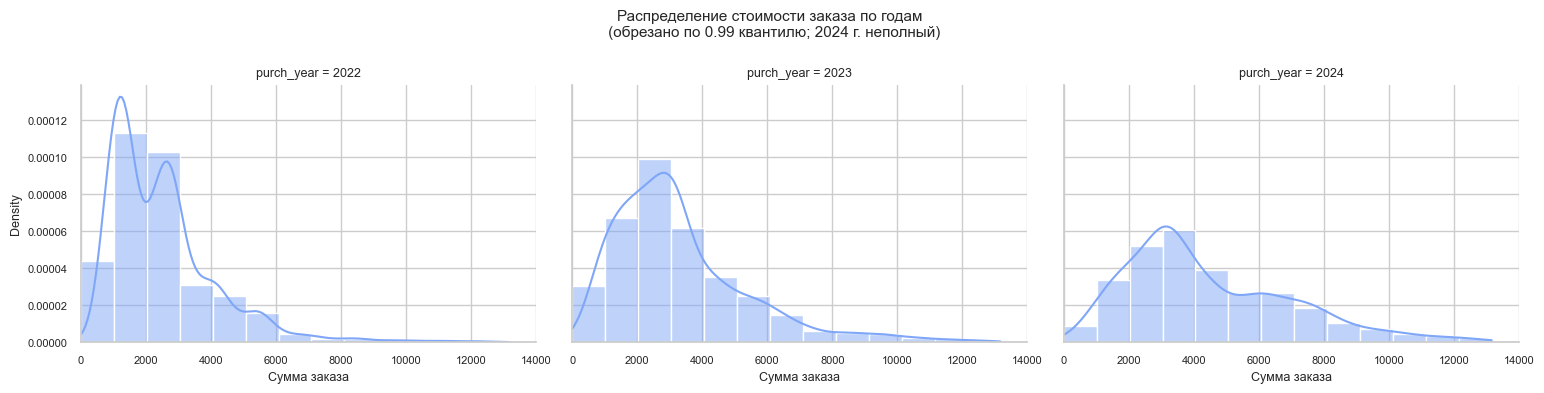

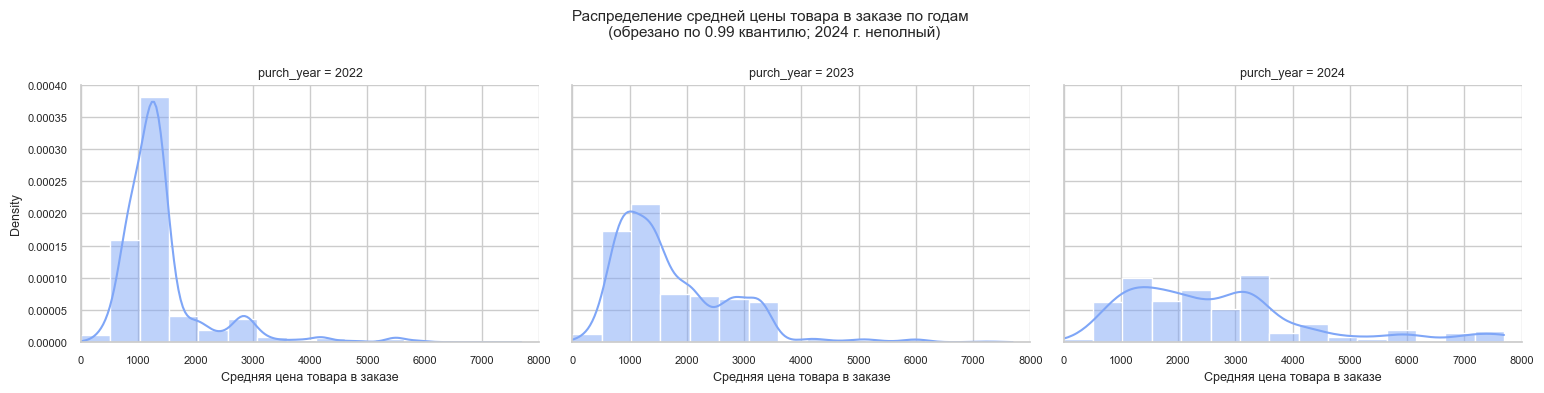

In [145]:
plot_order_value_by_year(order_value, x_col='Ord_value', x_label='Сумма заказа', facet_col='purch_year', metric='money', 
                         quant=0.99, title='Распределение стоимости заказа по годам \n (обрезано по 0.99 квантилю; 2024 г. неполный)')
plot_order_value_by_year(order_value, x_col='AUP', x_label='Средняя цена товара в заказе', facet_col='purch_year', 
                         quant=0.99, title='Распределение средней цены товара в заказе по годам \n (обрезано по 0.99 квантилю; 2024 г. неполный)')

In [146]:
# Напишем функцию для декомпозиции выручки
# Декомпозиция выручки: Revenue = Customers * APC * AOV
# Декомпозиция среднего чека: AOV = AUP * UPT

def yoy_decomposition(df, q=1, period_col='purch_quarter'):    
    # Подготовим данные
    g = (df.groupby(period_col, as_index=False)
           .agg(Revenue=('rev', 'sum'),
                Orders=('order_id', 'nunique'),
                Customers=('customer_id', 'nunique'),
                Units=('cnt', 'sum'))
           .assign(
               AOV=lambda x: x['Revenue'] / x['Orders'],
               APC=lambda x: x['Orders'] / x['Customers'],
               AUP=lambda x: x['Revenue'] / x['Units'],
               UPT=lambda x: x['Units'] / x['Orders'],
               p_year=lambda x: x[period_col].dt.year,
               p_quarter=lambda x: x[period_col].dt.quarter))          
    
    t = (g.loc[g['p_quarter'] == q, 
         ['p_year', 'Revenue', 'Customers', 'APC', 'AOV', 'AUP', 'UPT']].sort_values('p_year').reset_index(drop=True))

    # Напишем функцию для расчета логарифмического среднего
    L = lambda a, b: (a - b) / (np.log(a) - np.log(b)) if a != b else a
    
    # Декомпозируем выручку и AOV
    rows = []
    for i in range(1, len(t)):
        prev, curr = t.iloc[i-1], t.iloc[i]
        y1, y2     = int(prev['p_year']), int(curr['p_year'])
        R1, R2     = float(prev['Revenue']), float(curr['Revenue'])
        C1, C2     = float(prev['Customers']), float(curr['Customers'])
        F1, F2     = float(prev['APC']), float(curr['APC'])
        AOV1, AOV2 = float(prev['AOV']), float(curr['AOV'])
        P1, P2     = float(prev['AUP']), float(curr['AUP'])
        U1, U2     = float(prev['UPT']), float(curr['UPT'])
    
        # Декомпозиция выручки
        dR = R2 - R1
        if all(v > 0 for v in [R1, R2, C1, C2, F1, F2, AOV1, AOV2]):
            LM_R      = L(R2, R1)
            eff_C_R   = LM_R * np.log(C2/C1)
            eff_APC_R = LM_R * np.log(F2/F1)
            eff_AOV_R = LM_R * np.log(AOV2/AOV1)
        else:
            eff_C_R = eff_APC_R = eff_AOV_R = 0
        share_R = lambda x: 0 if dR == 0 else 100 * x / dR

        # Декомпозиция AOV
        dAOV = AOV2 - AOV1
        if all(v > 0 for v in [AOV1, AOV2, P1, P2, U1, U2]):
            LM_AOV = L(AOV2, AOV1)
            eff_price_AOV = LM_AOV * np.log(P2/P1)   
            eff_units_AOV = LM_AOV * np.log(U2/U1)  
        else:
            eff_price_AOV = eff_units_AOV = 0
        share_AOV = lambda x: 0 if dAOV == 0 else 100 * x / dAOV

        # Соберем единую витрину
        row = {
            'Quarter': f'Q{q}',
            'YOY': f'{y1}→{y2}',
            'Revenue': f"{round(R1)}→{round(R2)}",
            'Customers': f"{round(C1)}→{round(C2)}",
            'APC': f"{round(F1,2)}→{round(F2,2)}",
            'AOV': f"{round(AOV1)}→{round(AOV2)}",
            'AUP': f"{round(P1)}→{round(P2)}",
            'UPT': f"{round(U1,2)}→{round(U2,2)}",
            'ΔRevenue': round(dR),
            'ΔRev_%': None if R1 == 0 else round(dR/R1*100, 1),
            # Вклады факторов уровня выручки
            'Shr_Cust_R': round(share_R(eff_C_R), 2),
            'Shr_APC_R': round(share_R(eff_APC_R), 2),
            'Shr_AOV_R': round(share_R(eff_AOV_R), 2),

            'ΔAOV': round(dAOV, 2),
            'ΔAOV_%': None if AOV1 == 0 else round(dAOV/AOV1*100, 1),
            # Вклады факторов внутри AOV
            'Shr_AUP_on_AOV': round(share_AOV(eff_price_AOV), 2),
            'Shr_UPT_on_AOV': round(share_AOV(eff_units_AOV), 2)}
        
        rows.append(row)
        
    out = pd.DataFrame(rows)
    
    return out

In [147]:
# Декомпозируем выручку: проанализируем значения показателей YoY по кварталам (Q3 2024 неполный, Q4 2024 отсутстует в данных)
df_decomp = pd.concat([
           yoy_decomposition(successful_orders, q=1),
           yoy_decomposition(successful_orders, q=2),
           yoy_decomposition(successful_orders, q=3),
           yoy_decomposition(successful_orders, q=4)]).reset_index(drop=True)
df_decomp

Quarter        YOY           Revenue  Customers        APC        AOV  \
0      Q1  2022→2023   4689006→4823868  1337→1447  1.31→1.25  2675→2673   
1      Q1  2023→2024  4823868→11290100  1447→2102  1.25→1.25  2673→4286   
2      Q2  2022→2023   2942766→4477061   822→1204  1.29→1.21  2779→3071   
3      Q2  2023→2024  4477061→11612342  1204→1923  1.21→1.23  3071→4910   
4      Q3  2022→2023   3432641→5360413  1062→1249  1.26→1.23  2575→3497   
5      Q3  2023→2024   5360413→9155792  1249→1513  1.23→1.19  3497→5089   
6      Q4  2022→2023  8736535→12976363  2868→2679  1.28→1.23  2388→3947   

         AUP        UPT  ΔRevenue  ΔRev_%  Shr_Cust_R  Shr_APC_R  Shr_AOV_R  \
0  1432→1215   1.87→2.2    134862     2.9      278.83    -175.74      -3.09   
1  1215→1974   2.2→2.17   6466232   134.0       43.91       0.53      55.55   
2  1531→1456  1.81→2.11   1534295    52.1       90.96     -14.76      23.80   
3  1456→2693  2.11→1.82   7135281   159.4       49.13       1.62      49.25   
4  1391→1762  1.85→1.98   1927772    56.2       36.39      -5.02      68.64   
5  1762→2748  1.98→1.85   3795379    70.8       35.82      -5.93      70.11   
6  1212→1741  1.97→2.27   4239828    48.5      -17.23      -9.72     126.95   

      ΔAOV  ΔAOV_%  Shr_AUP_on_AOV  Shr_UPT_on_AOV  
0    -2.34    -0.1        18784.73       -18684.73  
1  1613.79    60.4          102.75           -2.75  
2   291.87    10.5          -50.06          150.06  
3  1839.39    59.9          130.95          -30.95  
4   921.56    35.8           77.21           22.79  
5  1592.70    45.5          118.37          -18.37  
6  1558.25    65.2           72.17           27.83

<div 
style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.8em 0; padding:1em 1.2em; background:#ebf1ee; border:1px solid #48735a; border-radius:8px; line-height:1.5;">

##### 🌿 Декомпозиция изменений выручки: ключевые выводы 
__________________

Анализ строится на следующей декомпозиции:  **Revenue = Customers × APC × AOV**, где **AOV = AUP × UPT**.
__________________
##### **Q1: изменения YoY**  
**2023 к 2022**    
- Выручка: +2.9%  
- Драйвер: рост числа покупателей  
- APC: отрицательный вклад  
- AOV: почти нулевое влияние
<div style="margin-top:0.2em; font-size:0.85rem; color:#365949;">
   →  Незначительный (околонулевой) рост выручки в основном за счёт прироста покупателей
 </div>

**2024 к 2023**  
- Выручка: +134%  
- Драйверы: Customers + AOV  
- APC: почти нулевое влияние  
- Драйвер внутри AOV: AUP, почти нулевое влияние UPT
<div style="margin-top:0.2em; font-size:0.85rem; color:#365949;">
   →  Взрывной рост выручки из-за увеличения числа покупателей и резкого увеличения AUP.
 </div>
__________________

##### **Q2: изменения YoY**

**2023 к 2022**  
- Выручка: +52.1%  
- Главный драйвер: Customers  
- APC: отрицательное влияние  
- AOV: умеренный рост  
- Драйвер внутри AOV: UPT, отрицательное влияние AUP
<div style="margin-top:0.2em; font-size:0.85rem; color:#365949;">
   →  Рост выручки обеспечен увеличившимся спросом, а не ценовым фактором.
 </div>

**2024 к 2023**  
- Выручка: +159.4%    
- Драйверы: Customers + AOV  
- APC: слабый +  
- Драйвер внутри AOV: AUP, отрицательное влияние UPT
<div style="margin-top:0.2em; font-size:0.85rem; color:#365949;">
   →  Взрывной рост выручки обеспечен почти поровну от числа покупателей и увеличения среднего чека, чек растёт за счёт ценового фактора.
 </div>
__________________

##### **Q3: изменения YoY**  
*(Q3 2024 — неполный период => рост занижен)*

**2023 к 2022**  
- Выручка: +56.2%  
- Customers: положительное влияние  
- APC: отрицательное  
- AOV: доминирующий драйвер  
- Драйвер внутри AOV: доминирующий AUP, но также положительное влияние UPT
<div style="margin-top:0.2em; font-size:0.85rem; color:#365949;">
   →  Рост выручки обеспечен в основном за счет увеличения среднего чека (также при позитивном влиянии числа покупателей), чек растёт в основном за счёт ценового фактора (но также поддерживается ростом UPT).
 </div>

**2024 к 2023**  
- Выручка: +70.8% *(занижено, так как посчитано на неполных данных, реальное значение должно быть выше)*  
- Customers: положительный вклад  
- APC: отрицательный  
- AOV: главный драйвер роста  
- Драйвер внутри AOV: AUP, отрицательное влияние UPT 
<div style="margin-top:0.2em; font-size:0.85rem; color:#365949;">
   →  Рост выручки обеспечен ростом AOV за счет ценового фактора
 </div>
__________________

##### **Q4: изменения YoY**
*Доступно только 2023 к 2022*

**2023 к 2022**  
- Выручка: +48.5%  
- Customers: отрицательное влияние  
- APC: отрицательное влияние  
- AOV: основной (и единственный) драйвер  
- Драйвер внутри AOV: доминирующий AUP, но также положительное влияние UPT
<div style="margin-top:0.2em; font-size:0.85rem; color:#365949;">
   →  Рост выручки обеспечен за счет увеличения среднего чека, чек растёт в основном за счёт ценового фактора (но также поддерживается ростом UPT). Средний чек полностью компенсировал падение числа покупателей и APC.
 </div> 
__________________

##### **Вывод**

На текущий момент бизнес растёт за счёт увеличения числа покупателей и роста среднего чека. Частота покупок является сдерживающим фактором роста выручки. По результатам сравнения 2023 г. к 2022 г., 2024 г. к 2023 г. по кварталам обнаружено, что чаще всего:
  - приток покупателей сильно драйвит рост 
  - частота покупок либо не оказывает влияние на рост выручки, либо влияет отрицательно
  - средний чек растет очень сильно в основном за счет ценового фактора, при этом в ряде кварталов увеличение числа товаров в заказе поддерживает рост AOV

</div>

<div style="background:#3b5e4a; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  4. Прочая аналитика (доп.)
</div>

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  4.1 Аналитика по категориям товаров: ABC-анализ
</div>

In [148]:
# Построим ABC-анализ по категориями товаров
sku_cat = successful_orders.groupby(['p_category'], as_index=False) \
                           .agg(Revenue     = ('rev','sum'),
                                Orders      = ('order_id','nunique'),
                                Customers   = ('customer_id','nunique'),
                                Product_ids = ('product_id','nunique'),
                                Units       = ('cnt','sum')) \
                           .assign(ARPPU  = lambda d: (d['Revenue'] / d['Customers']).round(2), 
                                   APC    = lambda d: (d['Orders']  / d['Customers']).round(2),
                                   AOV    = lambda d: (d['Revenue']  / d['Orders']).round(2),
                                   AUP    = lambda d: (d['Revenue'] / d['Units']).round(2),
                                   UPT    = lambda d: (d['Units']  / d['Orders']).round(2)) \
                           .sort_values('Revenue', ascending=False)
sku_cat['Revenue_share'] = sku_cat['Revenue']/sku_cat['Revenue'].sum()
sku_cat['Revenue_cumshare'] = sku_cat['Revenue_share'].cumsum()
sku_cat['ABC'] = pd.cut(sku_cat['Revenue_cumshare'], bins=[0,0.8,0.95,1.1], labels=list("ABC"))
sku_cat

p_category   Revenue  Orders  Customers  Product_ids  Units    ARPPU   APC  \
2      cat_3  32788949    7744       5302           31   9845  6184.26  1.46   
5      cat_6  29443161   14049       8059           65  23526  3653.45  1.74   
0      cat_1   7829858    4486       3597           34   5917  2176.77  1.25   
3      cat_4   3761246    1136       1018           17   1283  3694.74  1.12   
4      cat_5   3249785    1473       1265           27   2477  2569.00  1.16   
7      cat_8   2229682    2011       1476           13   2420  1510.62  1.36   
8    unknown     92077      42         41            1     43  2245.78  1.02   
6      cat_7     74370      33         28            1     33  2656.07  1.18   
1      cat_2     27759     215        201            3    231   138.10  1.07   

       AOV      AUP   UPT  Revenue_share  Revenue_cumshare ABC  
2  4234.11  3330.52  1.27       0.412456          0.412456   A  
5  2095.75  1251.52  1.67       0.370369          0.782824   A  
0  1745.40  1323.28  1.32       0.098493          0.881317   B  
3  3310.96  2931.60  1.13       0.047313          0.928630   B  
4  2206.24  1311.98  1.68       0.040879          0.969510   C  
7  1108.74   921.36  1.20       0.028047          0.997557   C  
8  2192.31  2141.33  1.02       0.001158          0.998715   C  
6  2253.64  2253.64  1.00       0.000936          0.999651   C  
1   129.11   120.17  1.07       0.000349          1.000000   C

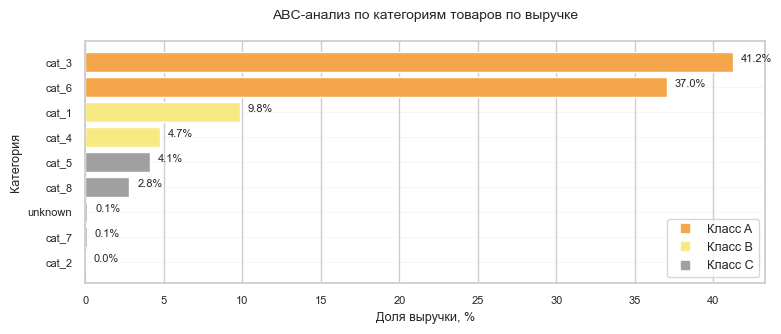

In [149]:
# Визуализируем ABC анализ
palette_abc = {'A': '#f5a64a', 'B': '#f8e984', 'C': '#a0a0a0'}
plot_df = sku_cat.sort_values('Revenue', ascending=False).copy()
plot_df['color'] = plot_df['ABC'].map(palette_abc)
fig, ax = plt.subplots(figsize=(8, 3.5))
bars = ax.barh(plot_df['p_category'], plot_df['Revenue_share'] * 100, color=plot_df['color'])
for bar, share in zip(bars, plot_df['Revenue_share'] * 100):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f"{share:.1f}%", fontsize=8)
ax.set_xlabel('Доля выручки, %')
ax.set_ylabel('Категория')
ax.set_title('ABC-анализ по категориям товаров по выручке\n')
ax.invert_yaxis()
# легенда
handles = [plt.Line2D([0], [0], marker='s', linestyle='', color=c, label=f'Класс {k}') for k, c in palette_abc.items()]
ax.grid(True, axis='y', color='0.9', alpha=0.5, linewidth=0.5)
ax.legend(handles=handles, loc='lower right', fontsize=9)
plt.tight_layout()

<div style="background:#5e7f6d; color:#ffffff; padding:6px 10px; border-radius:6px; font-weight:600;">            
  4.2 Анализ Retention
</div>

<div 
style="font-size:0.9 rem; font-weight:500; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#E7F0F0; border:1px solid #e5e7eb; border-radius:8px;line-height:1.3;">     
    Анализ User Retention пользователей по когортам 
</div>

Посчитаем долю вернувшихся клиентов для понимания поведения и привычек пользователей

In [150]:
# Когорты для анализа были выведены в отдельные поля датафрейма на этапе подготовки данных (по первой дате успешной покупки)
# Сейчас создадим поле с номером периода в днях 
# Для получения месячных периодов разделим разницу в днях между днем первой успешной покупки и днем текущей покупки целочисленно на 30
# Далее агрегируем данные по когортам и рассчитанному номеру периода и посчитаем число уникальных покупателей
for_cohort_analysis = successful_orders.assign(period_n_m = (successful_orders.purch_day - successful_orders.cohort_day).dt.days // 30)  \
                                       .groupby(['cohort', 'period_n_m']) \
                                       .agg(n_customers=('customer_id', 'nunique')).reset_index()
for_cohort_analysis

cohort  period_n_m  n_customers
0   2022-01-01           0          472
1   2022-01-01           1           93
2   2022-01-01           2           73
3   2022-01-01           3           49
4   2022-01-01           4           35
..         ...         ...          ...
530 2024-06-01           1           31
531 2024-06-01           2           18
532 2024-07-01           0          431
533 2024-07-01           1           15
534 2024-08-01           0          501

[535 rows x 3 columns]

In [151]:
# Создадим сводную таблицу для когортного анализа
retention = for_cohort_analysis.pivot_table(index='cohort', columns='period_n_m', values='n_customers') \
                               .sort_index()
retention

period_n_m     0     1     2     3     4     5     6     7     8     9     10  \
cohort                                                                          
2022-01-01  472.0  93.0  73.0  49.0  35.0  35.0  37.0  43.0  36.0  40.0  40.0   
2022-02-01  400.0  87.0  38.0  44.0  35.0  37.0  31.0  24.0  57.0  52.0  38.0   
2022-03-01  465.0  41.0  30.0  29.0  32.0  36.0  35.0  60.0  56.0  36.0  26.0   
2022-04-01  215.0  17.0  13.0   8.0  13.0  12.0  20.0  19.0  19.0   9.0   8.0   
2022-05-01  193.0  20.0  12.0  18.0  14.0  11.0  21.0  13.0   9.0  10.0   4.0   
2022-06-01  189.0  20.0  13.0  14.0  12.0  19.0  11.0   8.0   4.0   4.0   6.0   
2022-07-01  170.0  21.0  15.0  18.0  19.0  17.0  15.0   7.0   7.0   3.0   8.0   
2022-08-01  378.0  30.0  44.0  45.0  29.0  23.0  16.0  12.0  11.0  17.0   8.0   
2022-09-01  198.0  32.0  25.0  16.0  12.0   7.0  12.0   8.0  11.0   8.0   3.0   
2022-10-01  718.0  72.0  49.0  32.0  24.0  25.0  24.0  15.0  13.0  15.0  14.0   
2022-11-01  734.0  53.0  34.0  32.0  22.0  15.0  19.0  17.0  16.0  14.0  22.0   
2022-12-01  801.0  30.0  15.0  13.0  11.0   6.0   5.0   8.0   5.0  12.0  15.0   
2023-01-01  365.0  25.0  17.0   9.0   6.0  11.0   4.0   6.0   9.0   6.0  16.0   
2023-02-01  233.0  19.0  11.0   8.0   3.0   3.0   3.0   8.0  12.0   9.0   8.0   
2023-03-01  279.0  12.0  10.0   2.0   2.0   3.0   5.0   1.0   9.0  11.0   4.0   
2023-04-01  230.0  15.0  13.0   7.0  11.0  10.0   7.0  14.0   8.0   8.0   9.0   
2023-05-01  265.0  22.0  10.0  12.0   7.0  10.0  12.0   7.0   9.0   3.0   3.0   
2023-06-01  271.0  16.0  24.0  10.0  17.0  12.0  11.0  13.0   7.0   4.0   9.0   
2023-07-01  255.0  20.0  12.0  13.0  19.0  13.0  14.0  12.0   9.0   5.0  10.0   
2023-08-01  259.0  24.0  27.0  17.0  16.0  10.0  16.0   4.0   8.0  15.0   8.0   
2023-09-01  305.0  22.0  18.0  13.0  10.0  10.0   5.0   4.0   8.0  12.0   4.0   
2023-10-01  352.0  33.0  21.0  18.0  12.0   5.0  14.0  11.0   7.0   7.0   6.0   
2023-11-01  599.0  35.0  33.0  22.0  13.0  19.0  29.0  19.0  17.0  11.0   NaN   
2023-12-01  907.0  36.0  30.0  19.0  18.0  17.0  12.0  15.0  12.0   NaN   NaN   
2024-01-01  424.0  35.0  21.0  19.0  18.0  15.0  11.0  11.0   NaN   NaN   NaN   
2024-02-01  513.0  30.0  23.0  19.0  10.0  14.0   6.0   NaN   NaN   NaN   NaN   
2024-03-01  480.0  21.0  21.0  14.0  17.0  13.0   NaN   NaN   NaN   NaN   NaN   
2024-04-01  390.0  31.0  30.0  22.0  11.0   NaN   NaN   NaN   NaN   NaN   NaN   
2024-05-01  425.0  35.0  28.0  17.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-06-01  425.0  31.0  18.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-07-01  431.0  15.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2024-08-01  501.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

period_n_m    11    12    13    14    15    16    17    18    19    20    21  \
cohort                                                                         
2022-01-01  38.0  29.0  31.0  19.0  20.0  16.0  18.0  15.0  13.0  15.0  18.0   
2022-02-01  40.0  23.0  29.0  28.0  21.0  13.0  17.0  18.0  20.0  14.0  38.0   
2022-03-01  18.0  23.0  10.0  16.0  15.0  10.0  17.0  11.0  15.0  33.0  21.0   
2022-04-01   9.0   4.0   8.0   5.0   6.0  10.0   7.0  10.0  18.0  16.0   9.0   
2022-05-01   3.0   8.0   4.0   3.0   4.0   5.0   7.0  13.0   7.0   7.0   5.0   
2022-06-01   4.0   5.0   5.0   3.0   5.0   6.0   7.0   9.0   4.0   3.0   NaN   
2022-07-01   5.0  10.0   8.0  11.0   4.0  10.0   9.0   9.0   8.0   8.0   6.0   
2022-08-01  11.0   9.0   9.0  10.0  22.0  16.0  11.0   9.0   8.0  13.0  14.0   
2022-09-01   7.0   8.0   7.0  10.0   5.0   7.0  12.0   6.0   6.0   9.0   8.0   
2022-10-01  12.0  17.0  34.0  18.0  18.0  22.0   7.0   8.0  19.0  16.0  14.0   
2022-11-01  18.0  54.0  28.0  21.0  15.0  16.0  11.0  14.0  16.0  19.0   8.0   
2022-12-01  31.0  36.0  14.0  15.0   8.0   6.0   3.0  11.0  10.0   5.0   1.0   
2023-01-01  18.0  10.0  14.0   3.0   4.0   9.0   4.0   5.0   6.0   NaN   NaN   
2023-02-01  13.0   9.0   6.0   3.0   7.0   5.

In [152]:
# Вычислим коэффициенты удержания
retention_rate = retention.divide(retention.iloc[:, 0], axis=0)
retention_rate

period_n_m   0         1         2         3         4         5         6   \
cohort                                                                        
2022-01-01  1.0  0.197034  0.154661  0.103814  0.074153  0.074153  0.078390   
2022-02-01  1.0  0.217500  0.095000  0.110000  0.087500  0.092500  0.077500   
2022-03-01  1.0  0.088172  0.064516  0.062366  0.068817  0.077419  0.075269   
2022-04-01  1.0  0.079070  0.060465  0.037209  0.060465  0.055814  0.093023   
2022-05-01  1.0  0.103627  0.062176  0.093264  0.072539  0.056995  0.108808   
2022-06-01  1.0  0.105820  0.068783  0.074074  0.063492  0.100529  0.058201   
2022-07-01  1.0  0.123529  0.088235  0.105882  0.111765  0.100000  0.088235   
2022-08-01  1.0  0.079365  0.116402  0.119048  0.076720  0.060847  0.042328   
2022-09-01  1.0  0.161616  0.126263  0.080808  0.060606  0.035354  0.060606   
2022-10-01  1.0  0.100279  0.068245  0.044568  0.033426  0.034819  0.033426   
2022-11-01  1.0  0.072207  0.046322  0.043597  0.029973  0.020436  0.025886   
2022-12-01  1.0  0.037453  0.018727  0.016230  0.013733  0.007491  0.006242   
2023-01-01  1.0  0.068493  0.046575  0.024658  0.016438  0.030137  0.010959   
2023-02-01  1.0  0.081545  0.047210  0.034335  0.012876  0.012876  0.012876   
2023-03-01  1.0  0.043011  0.035842  0.007168  0.007168  0.010753  0.017921   
2023-04-01  1.0  0.065217  0.056522  0.030435  0.047826  0.043478  0.030435   
2023-05-01  1.0  0.083019  0.037736  0.045283  0.026415  0.037736  0.045283   
2023-06-01  1.0  0.059041  0.088561  0.036900  0.062731  0.044280  0.040590   
2023-07-01  1.0  0.078431  0.047059  0.050980  0.074510  0.050980  0.054902   
2023-08-01  1.0  0.092664  0.104247  0.065637  0.061776  0.038610  0.061776   
2023-09-01  1.0  0.072131  0.059016  0.042623  0.032787  0.032787  0.016393   
2023-10-01  1.0  0.093750  0.059659  0.051136  0.034091  0.014205  0.039773   
2023-11-01  1.0  0.058431  0.055092  0.036728  0.021703  0.031720  0.048414   
2023-12-01  1.0  0.039691  0.033076  0.020948  0.019846  0.018743  0.013230   
2024-01-01  1.0  0.082547  0.049528  0.044811  0.042453  0.035377  0.025943   
2024-02-01  1.0  0.058480  0.044834  0.037037  0.019493  0.027290  0.011696   
2024-03-01  1.0  0.043750  0.043750  0.029167  0.035417  0.027083       NaN   
2024-04-01  1.0  0.079487  0.076923  0.056410  0.028205       NaN       NaN   
2024-05-01  1.0  0.082353  0.065882  0.040000       NaN       NaN       NaN   
2024-06-01  1.0  0.072941  0.042353       NaN       NaN       NaN       NaN   
2024-07-01  1.0  0.034803       NaN       NaN       NaN       NaN       NaN   
2024-08-01  1.0       NaN       NaN       NaN       NaN       NaN       NaN   

period_n_m        7         8         9         10        11        12  \
cohort                                                                   
2022-01-01  0.091102  0.076271  0.084746  0.084746  0.080508  0.061441   
2022-02-01  0.060000  0.142500  0.130000  0.095000  0.100000  0.057500   
2022-03-01  0.129032  0.120430  0.077419  0.055914  0.038710  0.049462   
2022-04-01  0.088372  0.088372  0.041860  0.037209  0.041860  0.018605   
2022-05-01  0.067358  0.046632  0.051813  0.020725  0.015544  0.041451   
2022-06-01  0.042328  0.021164  0.021164  0.031746  0.021164  0.026455   
2022-07-01  0.041176  0.041176  0.017647  0.047059  0.029412  0.058824   
2022-08-01  0.031746  0.029101  0.044974  0.021164  0.029101  0.023810   
2022-09-01  0.040404  0.055556  0.040404  0.015152  0.035354  0.040404   
2022-10-01  0.020891  0.018106  0.020891  0.019499  0.016713  0.023677   
2022-11-01  0.023161  0.021798  0.019074  0.029973  0.024523  0.073569   
2022-12-01  0.009988  0.006242  0.014981  0.018727  0.038702  0.044944   
2023-01-01  0.016438  0.024658  0.016438  0.043836  0.049315  0.027397   
2023-02-01  0.034335  0.051502  0.038627  0.034335  0.055794  0.038627   
2023-03-01  0.003584  0.032258  0.039427  0.014337  0.017921  0.010753   
2023-04-01  0.060870  0.034783  0.034783  0.039130  0.0

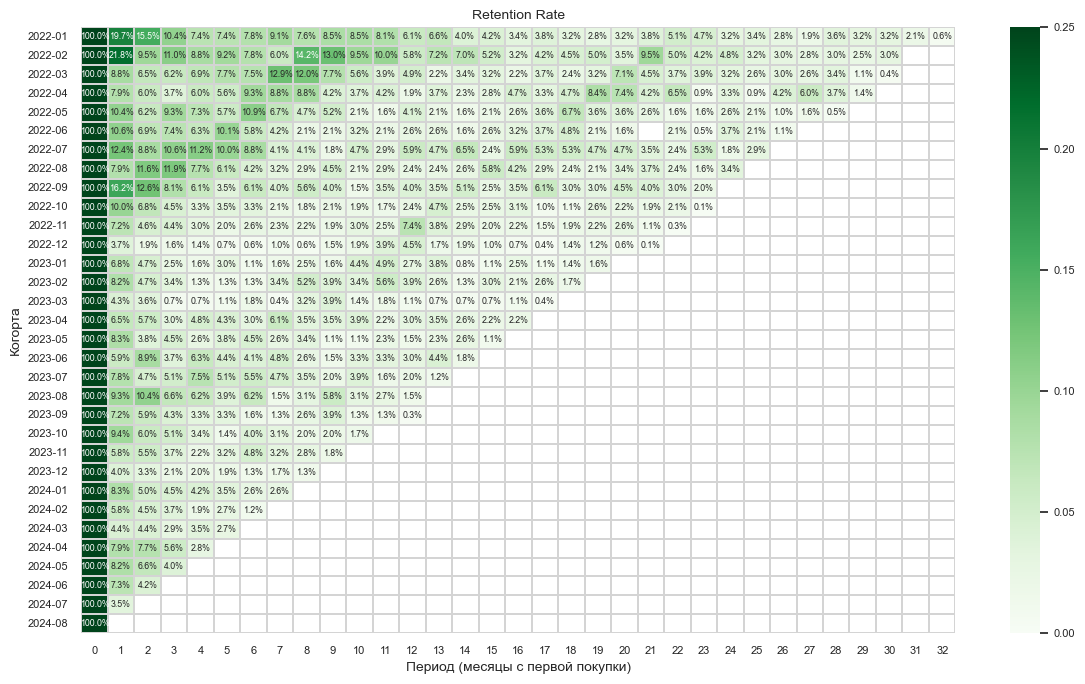

In [153]:
# Отформатируем индексы ретеншн-таблицы для визуализации
df_for_heatmap = retention_rate.copy()
df_for_heatmap.index = df_for_heatmap.index.strftime('%Y-%m')

# Построим визуализацию
sns.set_style("white")
plt.figure(figsize=(12, 7))
ax = sns.heatmap(df_for_heatmap, annot=True, fmt='.1%', cmap="Greens", vmin=0, vmax=0.25, 
                 linewidths=0.2, linecolor='#d4d4d4', annot_kws={"fontsize": 6.3})
ax.grid(False) 
plt.xlabel('Период (месяцы с первой покупки)', fontsize=10)
plt.ylabel('Когорта', fontsize=10)
plt.title('Retention Rate', fontsize=10)
plt.tight_layout()

In [154]:
# Рассчитаем взвешенное среднее значение retention за первый месяц
mean_retention_first_m = retention[1][retention[1].notna()].sum() / retention[0][retention[1].notna()].sum()*100
print(f'Средний retention за первый месяц: {mean_retention_first_m:.2f}%')

Средний retention за первый месяц: 8.05%


In [155]:
# Подготовим данные для построения кривой удержания клиентов
cohort_sizes = retention[0].astype(float)
weighted_values = []

for p in sorted(retention.columns):
    col = retention[p]
    num_returned = col[col.notna()].sum()          # сколько вернулось в период p (только когорты, у которых период p реально есть)
    num_base = cohort_sizes[col.notna()].sum()     # сколько было в нулевом периоде у тех же когорт
    weighted_values.append((p, (num_returned/num_base) if num_base > 0 else float('nan')))

weighted_retention = pd.DataFrame(weighted_values, columns=['period_n_m', 'weighted_retention'])
weighted_retention

period_n_m  weighted_retention
0            0            1.000000
1            1            0.080463
2            2            0.061125
3            3            0.048672
4            4            0.040506
5            5            0.038238
6            6            0.038763
7            7            0.037098
8            8            0.038798
9            9            0.037263
10          10            0.034723
11          11            0.036105
12          12            0.037458
13          13            0.034841
14          14            0.028133
15          15            0.026011
16          16            0.026325
17          17            0.023580
18          18            0.025673
19          19            0.028313
20          20            0.032029
21          21            0.029933
22          22            0.028558
23          23            0.024426
24          24            0.033844
25          25            0.026616
26          26            0.026887
27          27            0.027507
28          28            0.030946
29          29            0.021263
30          30            0.021690
31          31            0.021186
32          32            0.006356

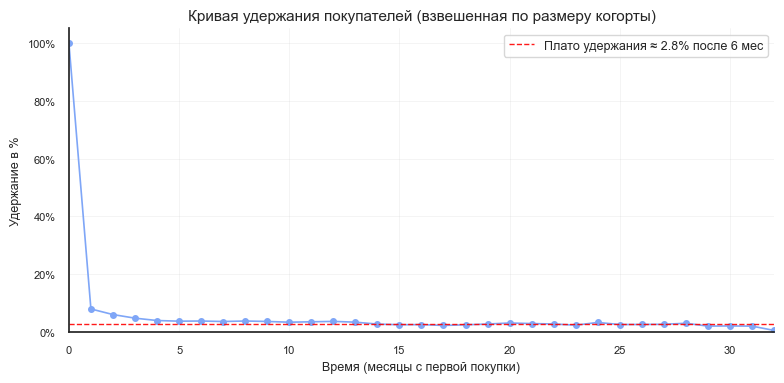

In [156]:
# Визуализируем средневзвешенный user retention в виде кривой удержания клиентов

x, y = weighted_retention['period_n_m'], weighted_retention['weighted_retention']
plt.figure(figsize=(8,4))
plt.plot(x, y, marker='o', markersize=4, linewidth=1.2, color='#7fa6f7')
plt.axhline(y=np.median(y[x >= 6]), color='red', linestyle='--', linewidth=1, alpha=0.9,
            label=f'Плато удержания ≈ {np.median(y[x >= 6]):.1%} после 6 мес')
plt.title('Кривая удержания покупателей (взвешенная по размеру когорты)', fontsize=11)
plt.xlabel('Время (месяцы с первой покупки)', fontsize=9)
plt.ylabel('Удержание в %', fontsize=9)
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.xlim(left=0, right=x.max())
plt.ylim(bottom=0)
plt.grid(True, which='major', axis='both', alpha=0.3, linewidth=0.5)
plt.legend(fontsize=9, frameon=True, framealpha=0.9, facecolor='white', edgecolor='lightgray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

<div 
style="font-size:0.9 rem; font-weight:500; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#E7F0F0; border:1px solid #e5e7eb; border-radius:8px;line-height:1.3;">     
    Анализ Revenue Retention по когортам
</div>

Посчитаем долю выручки, удержанной когортой, для оценки экономической ценности удержания пользователей

In [157]:
# Агрегируем данные по когортам и номеру периода и посчитаем выручку
for_revenue_retention = successful_orders.assign(period_n_m = (successful_orders.purch_day - successful_orders.cohort_day).dt.days // 30) \
                                         .groupby(['cohort', 'period_n_m'], as_index=False) \
                                         .agg(cohort_revenue=('rev', 'sum'))
for_revenue_retention

cohort  period_n_m  cohort_revenue
0   2022-01-01           0         1414297
1   2022-01-01           1          286995
2   2022-01-01           2          286069
3   2022-01-01           3          160357
4   2022-01-01           4          110439
..         ...         ...             ...
530 2024-06-01           1          196453
531 2024-06-01           2          115500
532 2024-07-01           0         2389090
533 2024-07-01           1           91546
534 2024-08-01           0         2705727

[535 rows x 3 columns]

In [158]:
# Создадим сводную таблицу для когортного анализа удержания выручки
revenue_retention = for_revenue_retention.pivot(index='cohort', columns='period_n_m', values='cohort_revenue')
revenue_retention

period_n_m         0         1         2         3         4         5   \
cohort                                                                    
2022-01-01  1414297.0  286995.0  286069.0  160357.0  110439.0  120886.0   
2022-02-01  1157029.0  301448.0  102606.0  149568.0  122398.0  106757.0   
2022-03-01  1386095.0  110541.0   92139.0   84907.0   82774.0   96553.0   
2022-04-01   651893.0   51660.0   41097.0   35640.0   53510.0   33649.0   
2022-05-01   567508.0   66078.0   35799.0   62457.0   73547.0   35389.0   
2022-06-01   557196.0   63195.0   49990.0   52481.0   36411.0   54075.0   
2022-07-01   497473.0   58687.0   41359.0   39332.0   73744.0   72217.0   
2022-08-01   941112.0   93184.0   97974.0  155871.0  107141.0   61176.0   
2022-09-01   573487.0   91872.0   87422.0   42239.0   35996.0   26132.0   
2022-10-01  1376948.0  222754.0  159425.0  105616.0   58488.0   67342.0   
2022-11-01  1904451.0  160284.0  116775.0  110359.0   64406.0   51783.0   
2022-12-01  2404952.0  107272.0   52251.0   51487.0   38296.0   25575.0   
2023-01-01  1032585.0   80099.0   45250.0   36156.0   21887.0   52863.0   
2023-02-01   601376.0   57019.0   36001.0   32146.0   10360.0   11797.0   
2023-03-01   761452.0   38702.0   36915.0    4780.0    5709.0   14318.0   
2023-04-01   627277.0   68782.0   61734.0   26309.0   48459.0   34899.0   
2023-05-01   878353.0  100388.0   44726.0   48378.0   24638.0   51875.0   
2023-06-01   973409.0   96635.0  124683.0   49718.0  102062.0   75416.0   
2023-07-01   918771.0   80517.0   56719.0   80854.0  115385.0   72190.0   
2023-08-01  1027830.0  138105.0  159341.0  170262.0   94176.0   52590.0   
2023-09-01   978995.0   94816.0   78039.0   54040.0   54494.0   68510.0   
2023-10-01  1419449.0  181497.0  103627.0   72624.0   83069.0   40149.0   
2023-11-01  2968682.0  204745.0  205321.0  133849.0   72533.0  126815.0   
2023-12-01  3101562.0  235438.0  182968.0   93074.0  104517.0   70896.0   
2024-01-01  1919942.0  179628.0  118391.0  110119.0  136810.0   76691.0   
2024-02-01  2175627.0  148699.0  113649.0  130403.0   43486.0   80527.0   
2024-03-01  2259401.0   98942.0  129743.0  102940.0  125879.0   95609.0   
2024-04-01  1887810.0  190021.0  128098.0  129702.0   75108.0       NaN   
2024-05-01  2156569.0  194734.0  143574.0  137443.0       NaN       NaN   
2024-06-01  2448546.0  196453.0  115500.0       NaN       NaN       NaN   
2024-07-01  2389090.0   91546.0       NaN       NaN       NaN       NaN   
2024-08-01  2705727.0       NaN       NaN       NaN       NaN       NaN   

period_n_m        6         7         8         9         10        11  \
cohort                                                                   
2022-01-01  113659.0  116822.0  103787.0  123501.0  140370.0  125272.0   
2022-02-01   76158.0   71935.0  175787.0  211043.0  154374.0  163562.0   
2022-03-01   87878.0  170113.0  191958.0  143208.0   70311.0   53528.0   
2022-04-01   48761.0   65000.0   62346.0   28331.0   32073.0   28777.0   
2022-05-01   77652.0   42064.0   22313.0   30663.0   10145.0    4788.0   
2022-06-01   21555.0   21017.0   12356.0    9387.0   21479.0   12658.0   
2022-07-01   62148.0   19203.0   30207.0    5209.0   19845.0   16595.0   
2022-08-01   54483.0   42178.0   41262.0   46583.0   27653.0   47124.0   
2022-09-01   53638.0   20492.0   41249.0   31167.0   18320.0   31225.0   
2022-10-01   78411.0   41722.0   38356.0   42380.0   48616.0   43372.0   
2022-11-01   76073.0   65642.0   59429.0   52330.0  103186.0  104691.0   
2022-12-01   20089.0   25376.0   34635.0   39368.0   72008.0  137377.0   
2023-01-01   11906.0   22977.0   40369.0   28845.0   73868.0   61214.0   
2023-02-01    8060.0   20303.0   63297.0   47392.0   76258.0   79097.0   
2023-03-01   24118.0    8480.0   45793.0   49789.0   20946.0   26751.0   
2023-04-01   40407.0   70516.0   38289.0   43489.0   51385.0   30839.0   
2023-05-01   50169.0   18706.0   38033.0   16458.0   31263.0   23814.0   
2023-06-01   66620.0   85958.0   55406.0   

In [159]:
# Вычислим удержание выручки по когортам в долях
revenue_retention_rate = revenue_retention.divide(revenue_retention.iloc[:, 0], axis=0)
revenue_retention_rate

period_n_m   0         1         2         3         4         5         6   \
cohort                                                                        
2022-01-01  1.0  0.202924  0.202269  0.113383  0.078088  0.085474  0.080364   
2022-02-01  1.0  0.260536  0.088681  0.129269  0.105786  0.092268  0.065822   
2022-03-01  1.0  0.079750  0.066474  0.061256  0.059717  0.069658  0.063400   
2022-04-01  1.0  0.079246  0.063043  0.054672  0.082084  0.051617  0.074799   
2022-05-01  1.0  0.116435  0.063081  0.110055  0.129596  0.062359  0.136830   
2022-06-01  1.0  0.113416  0.089717  0.094188  0.065347  0.097048  0.038685   
2022-07-01  1.0  0.117970  0.083138  0.079064  0.148237  0.145168  0.124927   
2022-08-01  1.0  0.099015  0.104105  0.165624  0.113845  0.065004  0.057892   
2022-09-01  1.0  0.160199  0.152439  0.073653  0.062767  0.045567  0.093530   
2022-10-01  1.0  0.161774  0.115781  0.076703  0.042477  0.048907  0.056946   
2022-11-01  1.0  0.084163  0.061317  0.057948  0.033819  0.027191  0.039945   
2022-12-01  1.0  0.044605  0.021726  0.021409  0.015924  0.010634  0.008353   
2023-01-01  1.0  0.077571  0.043822  0.035015  0.021196  0.051195  0.011530   
2023-02-01  1.0  0.094814  0.059864  0.053454  0.017227  0.019617  0.013403   
2023-03-01  1.0  0.050827  0.048480  0.006277  0.007498  0.018804  0.031674   
2023-04-01  1.0  0.109652  0.098416  0.041942  0.077253  0.055636  0.064417   
2023-05-01  1.0  0.114291  0.050920  0.055078  0.028050  0.059059  0.057117   
2023-06-01  1.0  0.099275  0.128089  0.051076  0.104850  0.077476  0.068440   
2023-07-01  1.0  0.087636  0.061734  0.088002  0.125586  0.078572  0.082626   
2023-08-01  1.0  0.134366  0.155027  0.165652  0.091626  0.051166  0.090484   
2023-09-01  1.0  0.096850  0.079713  0.055199  0.055663  0.069980  0.020977   
2023-10-01  1.0  0.127864  0.073005  0.051164  0.058522  0.028285  0.051264   
2023-11-01  1.0  0.068968  0.069162  0.045087  0.024433  0.042718  0.069037   
2023-12-01  1.0  0.075909  0.058992  0.030009  0.033698  0.022858  0.017130   
2024-01-01  1.0  0.093559  0.061664  0.057355  0.071257  0.039944  0.020306   
2024-02-01  1.0  0.068348  0.052237  0.059938  0.019988  0.037013  0.015343   
2024-03-01  1.0  0.043791  0.057424  0.045561  0.055713  0.042316       NaN   
2024-04-01  1.0  0.100657  0.067855  0.068705  0.039786       NaN       NaN   
2024-05-01  1.0  0.090298  0.066575  0.063732       NaN       NaN       NaN   
2024-06-01  1.0  0.080233  0.047171       NaN       NaN       NaN       NaN   
2024-07-01  1.0  0.038318       NaN       NaN       NaN       NaN       NaN   
2024-08-01  1.0       NaN       NaN       NaN       NaN       NaN       NaN   

period_n_m        7         8         9         10        11        12  \
cohort                                                                   
2022-01-01  0.082601  0.073384  0.087323  0.099251  0.088575  0.078069   
2022-02-01  0.062172  0.151930  0.182401  0.133423  0.141364  0.067488   
2022-03-01  0.122728  0.138488  0.103318  0.050726  0.038618  0.064304   
2022-04-01  0.099710  0.095638  0.043460  0.049200  0.044144  0.019520   
2022-05-01  0.074121  0.039318  0.054031  0.017876  0.008437  0.039892   
2022-06-01  0.037719  0.022175  0.016847  0.038548  0.022717  0.071425   
2022-07-01  0.038601  0.060721  0.010471  0.039892  0.033359  0.072637   
2022-08-01  0.044817  0.043844  0.049498  0.029383  0.050073  0.043523   
2022-09-01  0.035732  0.071927  0.054346  0.031945  0.054448  0.073805   
2022-10-01  0.030300  0.027856  0.030778  0.035307  0.031499  0.066760   
2022-11-01  0.034468  0.031205  0.027478  0.054181  0.054972  0.141987   
2022-12-01  0.010552  0.014402  0.016370  0.029942  0.057123  0.054544   
2023-01-01  0.022252  0.039095  0.027935  0.071537  0.059282  0.069687   
2023-02-01  0.033761  0.105254  0.078806  0.126806  0.131527  0.091046   
2023-03-01  0.011137  0.060139  0.065387  0.027508  0.035132  0.027801   
2023-04-01  0.112416  0.061040  0.069330  0.081918  0.0

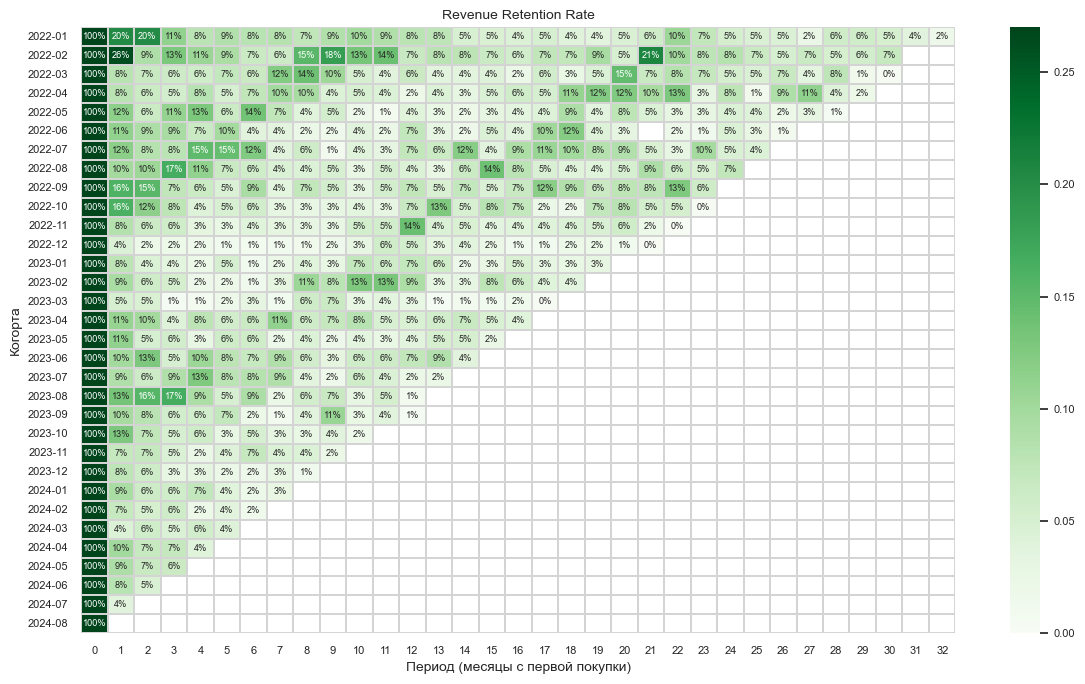

In [160]:
# Отформатируем индексы ретеншн-таблицы для визуализации
df_for_revenue_heatmap = revenue_retention_rate.copy()
df_for_revenue_heatmap.index = df_for_revenue_heatmap.index.strftime('%Y-%m')

# Построим визуализацию
sns.set_style("white")
plt.figure(figsize=(12, 7))
ax = sns.heatmap(df_for_revenue_heatmap, annot=True, fmt='.0%', cmap="Greens", vmin=0, vmax=0.27, 
                 linewidths=0.2, linecolor='#d4d4d4', annot_kws={"fontsize": 6.6})
ax.grid(False) 
plt.xlabel('Период (месяцы с первой покупки)', fontsize=10)
plt.ylabel('Когорта', fontsize=10)
plt.title('Revenue Retention Rate', fontsize=10)
plt.tight_layout()

In [161]:
# Рассчитаем средний Revenue retention за первый месяц
mean_rev_retention_first_m = revenue_retention[1][revenue_retention[1].notna()].sum()/revenue_retention[0][revenue_retention[1].notna()].sum()*100
 
print(f'Средний Revenue retention за первый месяц: {mean_rev_retention_first_m:.2f}%')

Средний Revenue retention за первый месяц: 9.31%


In [162]:
# Найдем когорту с самым высоким Revenue retention на первый месяц 
highest_rev_retention_1_month = revenue_retention_rate[1].idxmax().strftime('%Y-%m')
highest_rev_retention_value = revenue_retention_rate[1].max()*100

print(f'Когорта с самым высоким retention на первый месяц: {highest_rev_retention_1_month}, значение: {highest_rev_retention_value:.2f}%')

Когорта с самым высоким retention на первый месяц: 2022-02, значение: 26.05%


In [163]:
# Подготовим данные для построения кривой удержания клиентов по Revenue Retention
rev_cohort_sizes = revenue_retention[0].astype(float)
rev_weighted_values = []

for p in sorted(revenue_retention.columns):
    col = revenue_retention[p]
    num_returned = col[col.notna()].sum()          
    num_base = rev_cohort_sizes[col.notna()].sum()    
    rev_weighted_values.append((p, (num_returned/num_base) if num_base > 0 else float('nan')))

rev_weighted_retention = pd.DataFrame(rev_weighted_values, columns=['period_n_m', 'weighted_rev_retention'])
rev_weighted_retention

period_n_m  weighted_rev_retention
0            0                1.000000
1            1                0.093058
2            2                0.073302
3            3                0.062960
4            4                0.053449
5            5                0.047800
6            6                0.047671
7            7                0.044776
8            8                0.049943
9            9                0.050625
10          10                0.051275
11          11                0.055778
12          12                0.060395
13          13                0.052321
14          14                0.045340
15          15                0.047554
16          16                0.043654
17          17                0.044855
18          18                0.047009
19          19                0.050761
20          20                0.063168
21          21                0.060452
22          22                0.064431
23          23                0.050630
24          24                0.060860
25          25                0.044649
26          26                0.050733
27          27                0.048721
28          28                0.053837
29          29                0.038511
30          30                0.040242
31          31                0.038433
32          32                0.017308

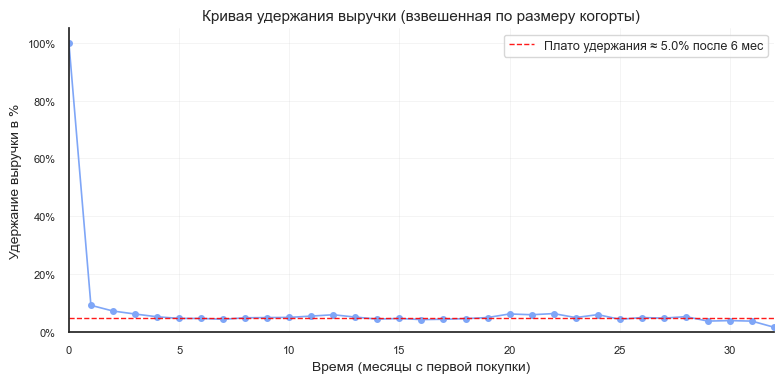

In [164]:
x, y = rev_weighted_retention['period_n_m'], rev_weighted_retention['weighted_rev_retention']
plt.figure(figsize=(8,4))

# Кривая удержания
plt.plot(x, y, marker='o', markersize=4, linewidth=1.2, color='#7fa6f7')

# Горизонтальная линия плато (считаем плато после 6-го месяца)
plt.axhline(y=np.median(y[x >= 6]), color='red', linestyle='--', linewidth=1, alpha=0.9,
            label=f'Плато удержания ≈ {np.median(y[x >= 6]):.1%} после 6 мес')
plt.title('Кривая удержания выручки (взвешенная по размеру когорты)', fontsize=11)
plt.xlabel('Время (месяцы с первой покупки)', fontsize=10)
plt.ylabel('Удержание выручки в %', fontsize=10)

# формат процентов по оси Y
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.xlim(left=0, right=x.max())
plt.ylim(bottom=0)

# лёгкая сетка
plt.grid(True, which='major', axis='both', alpha=0.3, linewidth=0.5)

# легенда в верхнем правом углу с мелким шрифтом и светлой подложкой
plt.legend(fontsize=9, frameon=True, framealpha=0.9, facecolor='white', edgecolor='lightgray')

# уберём лишние "жирные" рамки графика сверху и справа (более продуктовый стиль)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

<div 
style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#ebf1ee; border:1px solid #48735a; border-radius:8px; line-height:1.3;">

##### 🌿 Ключевые наблюдения по анализу удержания покупателей и выручки (User Retention + Revenue Retention)
---
Продукция, которую реализует бренд, не является товарами повседневного спроса:  
- часть ассортимента рассчитана на ежедневное или регулярное потребление
- часть на ритуалы и эмоциональное удовольствие
- часть на курсовой приём (витамины и БАД).
  
Из этого следует два ключевых паттерна поведения покупателей:  
- Покупатель пробует продукт 1 раз => высока доля однократных покупателей.  
- Если продукт понравился, то клиент возвращается и покупает регулярно => высокий ARPPU + UPT у вернувшихся клиентов (что подтвердилось в результате анализа данных ранее).
  
**Кривая удержания покупателецй демонстрирует резкий спад после первого месяца, низкое удержание после первой покупки (~8%) и стабилизацию на уровне примерно 3% начиная с 6-го месяца**. Такая форма кривой типична для подобного e-commerce. Основная часть когорт практически не демонстрирует долгосрочного повторного поведения. Небольшое плато говорит о наличии ядра постоянных клиентов, пусть и ограниченного по размеру, но генерирующего значительную часть выручки (это подтвердил анализ монетизации ранее).
Потенциал роста — в формировании привычки повторного потребления.

**Revenue Retention M1 ≈ 10%, к 6-му месяцу удерживается около 5% выручки.**  
Несмотря на низкое количественное удержание клиентов, выручка удерживается лучше, что указывает на наличие экономического PMF: продукт ценен для части аудитории, ядро лояльных клиентов делает более дорогие и более частые покупки.   

</div>


<div 
style="font-size:0.9rem; font-weight:400; color:#000000; margin:0.5em 0; padding:0.4em 0.8em; background:#ebf1ee; border:1px solid #48735a; border-radius:8px; line-height:1.3;">

##### 🌿 Итог по текущей модели бизнеса: сильные стороны и риски
---
Вся совокупность анализа (выручка, заказы, аудитория, монетизация, декомпозиция выручки, ретеншн) описывает бизнес-модель со следующими характеристиками:

**Сильные стороны:**  

- устойчивый рост выручки год к году;
- растущая база привлечения поддерживает масштабирование;
- ключевую часть дохода обеспечивают returning-клиенты с высоким ARPPU, AOV, UPT;
- рост AOV в первую очередь за счёт повышения средней цены товара в корзине.


**Риски и ограничения:**  

- низкое удержание после первой покупки усложняет рост без постоянного привлечения;
- частота покупок низкая и не увеличивается, что ограничивает LTV;
- сильная зависимость выручки от эффективности сезонных кампаний и привлечения новых клиентов;
- реальный рост в 2024 г. во многом обусловлен повышением средней цены товара, что может установить пределы эластичности спроса:


**Общий вывод:** 

Бизнес растёт за счёт активного притока новых клиентов и повышения среднего чека, а его устойчивость обеспечиваеся небольшим, но ценным ядром лояльных покупателей с сильной монетизацией. Главные точки роста — улучшение удержания в первые месяцы, формирование регулярного потребления и снижение зависимости от сезонности.

</div>
